# Import and process data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from scipy.stats import pearsonr
import copy

%run C:\Projects\Stock_price_prediction\Experiments\data_processing_functions.ipynb
%run C:\Projects\Stock_price_prediction\Experiments\feature_engineering.ipynb
%run C:\Projects\Stock_price_prediction\Experiments\training_functions.ipynb
%run C:\Projects\Stock_price_prediction\Experiments\CNN_Class_Retrain.ipynb
%run C:\Projects\Stock_price_prediction\Experiments\utils_CNN.ipynb

import random
import math
import gc
import os
import json

In [2]:
# Check if GPU is connected
print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_physical_devices('CPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [3]:
# For importing pre-processed data and further process here
data_path = 'C:/Projects/Stock_price_prediction/Experiments/WRDS_processed_20190101-20240531.csv'
TBill_path = 'C:/Projects/Stock_price_prediction/3monthTBill_2006-03-01_2024-07-12.csv'
sic_code_path = 'C:/Projects/Stock_price_prediction/Experiments/tickers&sics_20200101-20240531.csv'

# For importing processed data
processed_data_path = 'C:/Projects/Stock_price_prediction/Experiments/processed_data_20190101-20240531_40factors.csv'

In [4]:
basic_factors = ['cshoc', 'cshtrd', 'prccd', 'prchd', 'prcld', 'prcod', 'dol_vol', 'Mom_2day', 'Mom_3day', 'Mom_5day',
                 'MA_5day', 'MA_10day', 'close/MA10', 'close/MA5', 'open/MA10', 'open/MA5', 'STD_10day', 'H-L', 'RSI',
                 'MACD', 'mkt_cap']

TA_factors = [# Momentum indicators
              'momentum_stoch_rsi', 'momentum_stoch', 'momentum_ao', 'momentum_pvo', 'momentum_kama', 'momentum_wr',
              # Volume indicators
              'volume_adi', 'volume_em', 'volume_fi', 'volume_cmf', 'volume_vpt',
              # Volatility indicators
              'volatility_atr', 'volatility_bbh', 'volatility_dcw', 'volatility_ui',
              # Trend indicators
              'trend_adx', 'trend_aroon_up', 'trend_aroon_down', 'trend_ichimoku_a',
              # Other indicators
              'others_dr'
]

# Remove mkt_cap because it's not part of ML input
basic_factors.remove('mkt_cap')

# Remove factors that have low variance
basic_factors.remove('cshoc')
basic_factors.remove('dol_vol')

# Remove factors that have high correlation with the prcod
basic_factors.remove('prccd')
basic_factors.remove('prcld')
basic_factors.remove('prchd')
basic_factors.remove('MA_10day')
TA_factors.remove('trend_ichimoku_a')
TA_factors.remove('volatility_bbh')
TA_factors.remove('momentum_kama')

# Remove factors that have high correlation with momentum_stoch
TA_factors.remove('momentum_wr')

factors = basic_factors + TA_factors
print(f'There are {len(basic_factors)} basic factors')
print(f'There are {len(TA_factors)} TA factors')
print(f'There are {len(factors)} factors')

data = pd.read_csv(processed_data_path)
data = data.drop(columns=['Unnamed: 0'])
num_of_tokens = data.sic.nunique()
num_to_tic_dict, tic_to_num_dict = num_tic_dicts(data)

data = data.drop(columns=['DistinctRank', 'rank'])
data = portfolio(data)

data = data[['datadate', 'tic', 'conm', 'ret_d', 'TBill3m', 'excess_ret_d', 'rel_ret_d', 'sic', 'rank'] + factors]
data

There are 14 basic factors
There are 16 TA factors
There are 30 factors


datadate   tic                      conm     ret_d   TBill3m  \
0        2019-01-02     A  AGILENT TECHNOLOGIES INC -0.021975  0.000096   
1        2019-01-03     A  AGILENT TECHNOLOGIES INC  0.024185  0.000095   
2        2019-01-04     A  AGILENT TECHNOLOGIES INC  0.029707  0.000094   
3        2019-01-07     A  AGILENT TECHNOLOGIES INC  0.009025  0.000095   
4        2019-01-08     A  AGILENT TECHNOLOGIES INC  0.012463  0.000095   
...             ...   ...                       ...       ...       ...   
3128080  2024-05-24  ZYME             ZYMEWORKS INC -0.029545  0.000208   
3128081  2024-05-28  ZYME             ZYMEWORKS INC -0.010539  0.000208   
3128082  2024-05-29  ZYME             ZYMEWORKS INC -0.014201  0.000208   
3128083  2024-05-30  ZYME             ZYMEWORKS INC  0.000000  0.000208   
3128084  2024-05-31  ZYME             ZYMEWORKS INC  0.000000  0.000208   

         excess_ret_d  rel_ret_d   sic  rank     cshtrd  ...     volume_fi  \
0           -0.022071  -0.024338   0.0    -1  2078511.0  ...  0.000000e+00   
1            0.024090   0.000941   0.0     1  5383926.0  ... -5.222408e+06   
2            0.029613   0.009853   0.0     1  3119738.0  ... -5.118125e+06   
3            0.008930   0.000826   0.0     0  3221344.0  ... -3.673666e+06   
4            0.012368   0.013571   0.0     1  1578055.0  ... -2.709256e+06   
...               ...        ...   ...   ...        ...  ...           ...   
3128080     -0.029754  -0.012262  10.0    -1   310059.0  ... -8.559001e+03   
3128081     -0.010747  -0.010960  10.0    -1   319136.0  ... -3.689018e+03   
3128082     -0.014409  -0.022240  10.0    -1   314990.0  ... -1.486164e+04   
3128083     -0.000208   0.000000  10.0     0   284470.0  ... -1.639602e+04   
3128084     -0.000208   0.000000  10.0     0   840276.0  ... -2.845847e+04   

         volume_cmf    volume_vpt  volatility_atr  volatility_dcw  \
0          0.889764  0.000000e+00        0.000000        1.909774   
1          0.873863 -7.853245e+04        0.000000        6.922669   
2          0.321428 -1.470877e+05        0.000000        6.990618   
3          0.020760 -6.918029e+04        0.000000        8.290037   
4          0.036975 -2.230023e+04        0.000000        9.427661   
...             ...           ...             ...             ...   
3128080   -0.136613  1.795507e+07        0.464809       15.306476   
3128081   -0.098893  1.795800e+07        0.443828       15.149861   
3128082   -0.038112  1.794869e+07        0.437445       13.350025   
3128083    0.001738  1.794569e+07        0.409701       13.692239   
3128084   -0.053907  1.793376e+07        0.391721       14.625349   

         volatility_ui  trend_adx  trend_aroon_up  trend_aroon_down  others_dr  
0             0.000000   0.000000             0.0               0.0   0.000000  
1             0.000000   0.000000             0.0               4.0  -1.458647  
2             0.000000   0.000000             0.0               4.0  -2.197467  
3             0.000000   0.000000            12.0               4.0   2.418474  
4             0.000000   0.000000            16.0               4.0   2.970750  
...                ...        ...             ...               ...        ...  
3128080       3.658292  17.373844            68.0              20.0  -3.111111  
3128081       4.035618  16.784768            64.0              16.0   0.917431  
3128082       4.738244  16.989557            60.0              12.0  -2.954545  
3128083       5.459606  17.277894            56.0               8.0  -1.053864  
3128084       6.274627  17.809781            52.0               4.0  -1.420118  

[3128085 rows x 39 columns]

In [5]:
data.columns

Index(['datadate', 'tic', 'conm', 'ret_d', 'TBill3m', 'excess_ret_d',
       'rel_ret_d', 'sic', 'rank', 'cshtrd', 'prcod', 'Mom_2day', 'Mom_3day',
       'Mom_5day', 'MA_5day', 'close/MA10', 'close/MA5', 'open/MA10',
       'open/MA5', 'STD_10day', 'H-L', 'RSI', 'MACD', 'momentum_stoch_rsi',
       'momentum_stoch', 'momentum_ao', 'momentum_pvo', 'volume_adi',
       'volume_em', 'volume_fi', 'volume_cmf', 'volume_vpt', 'volatility_atr',
       'volatility_dcw', 'volatility_ui', 'trend_adx', 'trend_aroon_up',
       'trend_aroon_down', 'others_dr'],
      dtype='object')

In [6]:
# Whether to save the model after every training
save = True

# Set Seed
seed = 120

all_days = list(data['datadate'].unique())
num_of_ts = len(all_days)
batch_size = 4096 # Only for model.predict()
print(f'There are {num_of_ts} days in the dataset')

tickers = list(data.tic.unique())
nt = len(tickers)
print(f'There are {nt} tickers')
assert len(tickers) * num_of_ts == data.shape[0]

seq_length = 20 # Length of time-series
train_length = 100 # Length of training data
ftd = train_length # First train day
ltd = ftd+train_length-1 # Last train day
num_stocks = 10 # Choose the top {num_stocks} each day
num_of_models = 3

num_iters = math.floor((num_of_ts - 2*train_length) / seq_length)
print(f'There are {num_iters} iterations')

# Get risk-free rate for SR calculation
date_to_rfr_dict = dict(zip(data.datadate, data.TBill3m))

There are 1363 days in the dataset
There are 2295 tickers
There are 58 iterations


In [7]:
scce = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none')

def custom_loss(y_true, y_pred, ret_d):
    y_true = tf.cast(y_true, dtype=tf.float32)
    loss = tf.reduce_mean(scce(y_true, y_pred) * tf.minimum(tf.abs(ret_d), 1))
    return loss

# Numpy version of loss
def custom_loss_np(y_true, y_pred, ret_d):
    loss = np.mean(scce(y_true, y_pred) * np.minimum(abs(ret_d), 1))
    return loss

# Retrain

## Initializing variables

In [8]:
# Initialize portfolio_dict (rows are days, columns are pred and excess_return)
portfolio_dict = {}
portfolio_dict_index = [i for i in range(1, 11)] + ['H-L']

for i in range(num_of_models):
    portfolio_dict[f'orig_{i}'] = pd.DataFrame()
    portfolio_dict[f'retr_{i}'] = pd.DataFrame()
portfolio_dict['orig_ensemble'] = pd.DataFrame()
portfolio_dict['retr_ensemble'] = pd.DataFrame()
portfolio_dict['orig_equal'] = pd.DataFrame()
portfolio_dict['retr_equal'] = pd.DataFrame()

# Initialize SR-related variables
SR_dict = {}
for i in range(num_of_models):
    SR_dict[f'orig_{i}'] = pd.DataFrame(columns=['pred_score', 'avg_excess_ret', 'std_excess_ret', 'SR'])
    SR_dict[f'retr_{i}'] = pd.DataFrame(columns=['pred_score', 'avg_excess_ret', 'std_excess_ret', 'SR'])
SR_dict['orig_ensemble'] = pd.DataFrame(columns=['pred_score', 'avg_excess_ret', 'std_excess_ret', 'SR'])
SR_dict['retr_ensemble'] = pd.DataFrame(columns=['pred_score', 'avg_excess_ret', 'std_excess_ret', 'SR'])
SR_dict['orig_equal'] = pd.DataFrame(columns=['pred_score', 'avg_excess_ret', 'std_excess_ret', 'SR'])
SR_dict['retr_equal'] = pd.DataFrame(columns=['pred_score', 'avg_excess_ret', 'std_excess_ret', 'SR'])

pred_score_avg_dict = {}
excess_return_dict = {}
for i in range(num_of_models):
    pred_score_avg_dict[f'orig_{i}'] = 0
    pred_score_avg_dict[f'retr_{i}'] = 0
    excess_return_dict[f'orig_{i}'] = np.zeros((1, seq_length * num_iters))
    excess_return_dict[f'retr_{i}'] = np.zeros((1, seq_length * num_iters))
pred_score_avg_dict['orig_ensemble'] = np.zeros((1, ))
pred_score_avg_dict['retr_ensemble'] = np.zeros((1, ))
pred_score_avg_dict['orig_equal'] = np.zeros((1, ))
pred_score_avg_dict['retr_equal'] = np.zeros((1, ))
excess_return_dict['orig_ensemble'] = np.zeros((1, seq_length * num_iters))
excess_return_dict['retr_ensemble'] = np.zeros((1, seq_length * num_iters))
excess_return_dict['orig_equal'] = np.zeros((1, seq_length * num_iters))
excess_return_dict['retr_equal'] = np.zeros((1, seq_length * num_iters))

In [9]:
model_params = {
    # For training and validation
    'num_models': 3,
    'train_patience': 20,
    'plateau_patience': 5,
    'retrain_patience': 20,
    'validation_split': 0.2,
    'learning_rate': 1e-2,
    'epochs': 500,
    'batch_size': 1024,
    # Model inputs
    'target': keras.layers.Input(shape=1),
    'direction': keras.layers.Input(shape=1),
    'ret_d': keras.layers.Input(shape=1),
    'sic_input': keras.layers.Input(shape=1),
    # Categorical input dimension
    'embedding_dim': 128,
    # Convolution parameters
    'num_of_tokens': num_of_tokens,
    'filter_dims': [30],
    'kernel_sizes': [5],
    # Dense layer parameters
    'layer_dims': [64, 16],
    'output_dim': 5,
    'activation': "leaky_relu",
    # Regularization parameter
    'dropout_dense': 0.3
}

## Perform retrain based on top `num_stocks` SR condition

Iteration 1 of 58
Standardization data are from 2019-01-02 to 2019-05-24
Training data are from 2019-05-28 to 2019-10-16
Testing data are from 2019-09-20 to 2019-11-13
Training data have shape (185895, 20, 30), (185895,)
Testing data have shape (45900, 20, 30), (45900,)
top_stocks by original model 0 to buy on 2019-10-18 are ['BHP', 'CAL', 'KODK', 'SPB', 'PUMP', 'BYON', 'BKE', 'MRO', 'ZOM', 'DRIP']
top_stocks by retrained model 0 to buy on 2019-10-18 are ['BHP', 'CAL', 'KODK', 'SPB', 'PUMP', 'BYON', 'BKE', 'MRO', 'ZOM', 'DRIP']
Total asset on 2019-10-21 will be 1.0027648056085299
It should be the same as 1.00276480560853
Total asset on 2019-10-21 will be 1.0027648056085299
It should be the same as 1.00276480560853
Total asset on 2019-10-21 will be 1.0027648056085299
It should be the same as 1.00276480560853
top_stocks by original model 1 to buy on 2019-10-18 are ['DK', 'PCRX', 'GSAT', 'BKE', 'NOV', 'THO', 'GES', 'ACB', 'ATI', 'TOON']
top_stocks by retrained model 1 to buy on 2019-10-18

Total asset on 2019-10-23 will be 1.0172033981737658
It should be the same as 1.0172033981737658
Total asset on 2019-10-23 will be 1.0172033981737658
It should be the same as 1.0172033981737658
Total asset on 2019-10-23 will be 1.0172033981737658
It should be the same as 1.0172033981737658
top_stocks by original return weighted ensemble to buy on 2019-10-22 are ['MPLX', 'RRC', 'JEF', 'FANG', 'NFLX', 'EYE', 'VIRT', 'CNX', 'OVV', 'GPRE']
Total asset on 2019-10-23 will be 1.026153469696199
It should be the same as 1.0261534696961996
top_stocks by original equal weighted ensemble to buy on 2019-10-22 are ['MPLX', 'RRC', 'JEF', 'FANG', 'NFLX', 'EYE', 'VIRT', 'CNX', 'OVV', 'GPRE']
Total asset on 2019-10-23 will be 1.026153469696199
It should be the same as 1.0261534696961996
top_stocks by retrained return weighted ensemble to buy on 2019-10-22 are ['MPLX', 'RRC', 'JEF', 'FANG', 'NFLX', 'EYE', 'VIRT', 'CNX', 'OVV', 'GPRE']
Total asset on 2019-10-23 will be 1.026153469696199
It should be the s

Total asset on 2019-10-28 will be 1.0418322966941316
It should be the same as 1.0418322966941322
top_stocks by original model 0 to buy on 2019-10-28 are ['SPXU', 'CRL', 'DXCM', 'SPXS', 'BVN', 'CCL', 'CUK', 'DXD', 'SDS', 'SDOW']
top_stocks by retrained model 0 to buy on 2019-10-28 are ['SPXU', 'CRL', 'DXCM', 'SPXS', 'BVN', 'CCL', 'CUK', 'DXD', 'SDS', 'SDOW']
Total asset on 2019-10-29 will be 1.070878154375989
It should be the same as 1.0708781543759898
Total asset on 2019-10-29 will be 1.070878154375989
It should be the same as 1.0708781543759898
Total asset on 2019-10-29 will be 1.070878154375989
It should be the same as 1.0708781543759898
top_stocks by original model 1 to buy on 2019-10-28 are ['WTI', 'SSRM', 'OVV', 'USO', 'DNN', 'DXCM', 'JNUG', 'GIL', 'AHT', 'ASTH']
top_stocks by retrained model 1 to buy on 2019-10-28 are ['WTI', 'SSRM', 'OVV', 'USO', 'DNN', 'DXCM', 'JNUG', 'GIL', 'AHT', 'ASTH']
Total asset on 2019-10-29 will be 0.989064749851829
It should be the same as 0.9890647498

Total asset on 2019-11-01 will be 1.100350857755363
It should be the same as 1.1003508577553633
Total asset on 2019-11-01 will be 1.100350857755363
It should be the same as 1.1003508577553633
Total asset on 2019-11-01 will be 1.100350857755363
It should be the same as 1.1003508577553633
top_stocks by original model 1 to buy on 2019-10-31 are ['DXC', 'XOM', 'ASTH', 'KOLD', 'WOLF', 'MPLX', 'TPL', 'LC', 'NTLA', 'IBKR']
top_stocks by retrained model 1 to buy on 2019-10-31 are ['DXC', 'XOM', 'ASTH', 'KOLD', 'WOLF', 'MPLX', 'TPL', 'LC', 'NTLA', 'IBKR']
Total asset on 2019-11-01 will be 1.020597339038309
It should be the same as 1.0205973390383103
Total asset on 2019-11-01 will be 1.020597339038309
It should be the same as 1.0205973390383103
Total asset on 2019-11-01 will be 1.020597339038309
It should be the same as 1.0205973390383103
top_stocks by original model 2 to buy on 2019-10-31 are ['ASTH', 'NTLA', 'FATE', 'SABR', 'ATGE', 'FMS', 'LNG', 'CAL', 'EXEL', 'IBKR']
top_stocks by retrained m

top_stocks by original model 1 to buy on 2019-11-05 are ['BHP', 'NGVT', 'CNO', 'TSE', 'PICK', 'LC', 'MT', 'LEA', 'TMV', 'TECK']
top_stocks by retrained model 1 to buy on 2019-11-05 are ['BHP', 'NGVT', 'CNO', 'TSE', 'PICK', 'LC', 'MT', 'LEA', 'TMV', 'TECK']
Total asset on 2019-11-06 will be 1.065749815576242
It should be the same as 1.0657498155762428
Total asset on 2019-11-06 will be 1.065749815576242
It should be the same as 1.0657498155762428
Total asset on 2019-11-06 will be 1.065749815576242
It should be the same as 1.0657498155762428
top_stocks by original model 2 to buy on 2019-11-05 are ['CNO', 'KWEB', 'THRM', 'LYG', 'MU', 'ROG', 'LEA', 'RCL', 'EWH', 'TECK']
top_stocks by retrained model 2 to buy on 2019-11-05 are ['CNO', 'KWEB', 'THRM', 'LYG', 'MU', 'ROG', 'LEA', 'RCL', 'EWH', 'TECK']
Total asset on 2019-11-06 will be 1.093473076643656
It should be the same as 1.0934730766436558
Total asset on 2019-11-06 will be 1.093473076643656
It should be the same as 1.0934730766436558
Tota

Total asset on 2019-11-11 will be 1.0615262520553623
It should be the same as 1.0615262520553626
Total asset on 2019-11-11 will be 1.0615262520553623
It should be the same as 1.0615262520553626
Total asset on 2019-11-11 will be 1.0615262520553623
It should be the same as 1.0615262520553626
top_stocks by original return weighted ensemble to buy on 2019-11-08 are ['NWE', 'MDLZ', 'SUI', 'EQC', 'PAYX', 'APT', 'AUPH', 'AHT', 'DRIP', 'NNDM']
Total asset on 2019-11-11 will be 1.0786651801701548
It should be the same as 1.0786651801701554
top_stocks by original equal weighted ensemble to buy on 2019-11-08 are ['NWE', 'MDLZ', 'SUI', 'EQC', 'PAYX', 'APT', 'AUPH', 'AHT', 'DRIP', 'NNDM']
Total asset on 2019-11-11 will be 1.0786651801701548
It should be the same as 1.0786651801701554
top_stocks by retrained return weighted ensemble to buy on 2019-11-08 are ['NWE', 'MDLZ', 'SUI', 'EQC', 'PAYX', 'APT', 'AUPH', 'AHT', 'DRIP', 'NNDM']
Total asset on 2019-11-11 will be 1.0786651801701548
It should be th

Total asset on 2019-11-14 will be 1.0317268458890374
It should be the same as 1.031726845889038
top_stocks by original model 0 to buy on 2019-11-14 are ['WCN', 'TXT', 'COTY', 'RMBS', 'TSM', 'CUK', 'PUK', 'REZI', 'DNLI', 'SLCA']
top_stocks by retrained model 0 to buy on 2019-11-14 are ['WCN', 'TXT', 'COTY', 'RMBS', 'TSM', 'CUK', 'PUK', 'REZI', 'DNLI', 'SLCA']
Total asset on 2019-11-15 will be 1.104729654525106
It should be the same as 1.104729654525106
Total asset on 2019-11-15 will be 1.104729654525106
It should be the same as 1.104729654525106
Total asset on 2019-11-15 will be 1.104729654525106
It should be the same as 1.104729654525106
top_stocks by original model 1 to buy on 2019-11-14 are ['LBRT', 'CIB', 'PSMT', 'NFLX', 'DNLI', 'REZI', 'TSM', 'AMR', 'WDAY', 'FCEL']
top_stocks by retrained model 1 to buy on 2019-11-14 are ['LBRT', 'CIB', 'PSMT', 'NFLX', 'DNLI', 'REZI', 'TSM', 'AMR', 'WDAY', 'FCEL']
Total asset on 2019-11-15 will be 0.9961850635727935
It should be the same as 0.99618

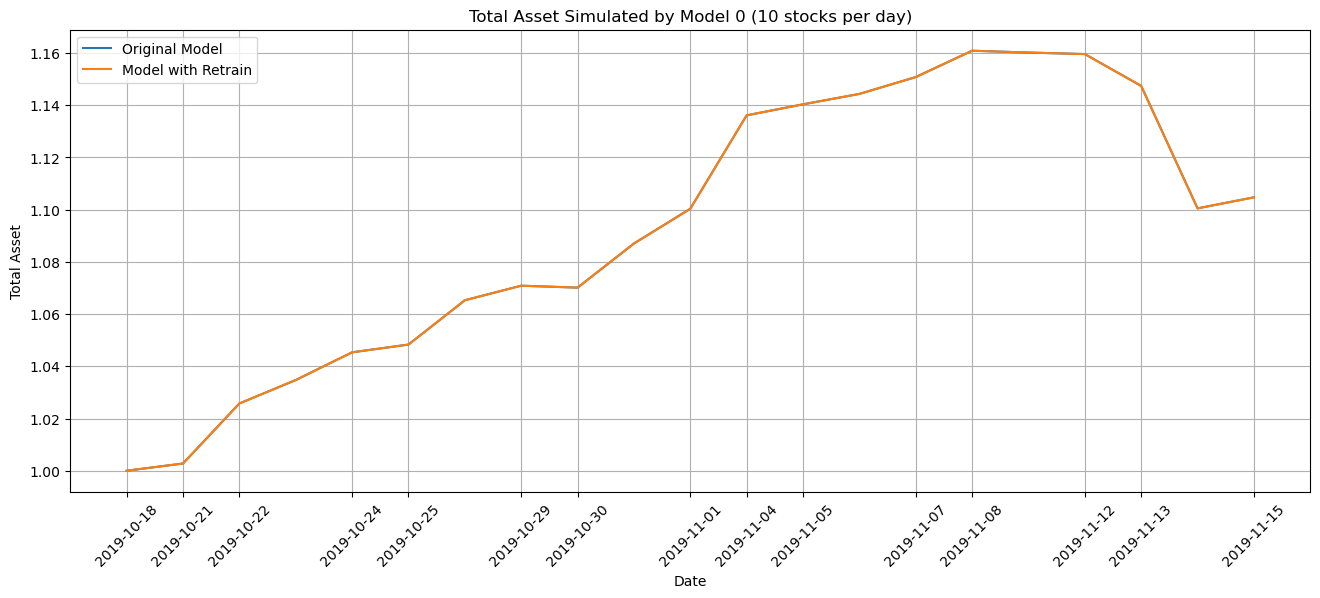

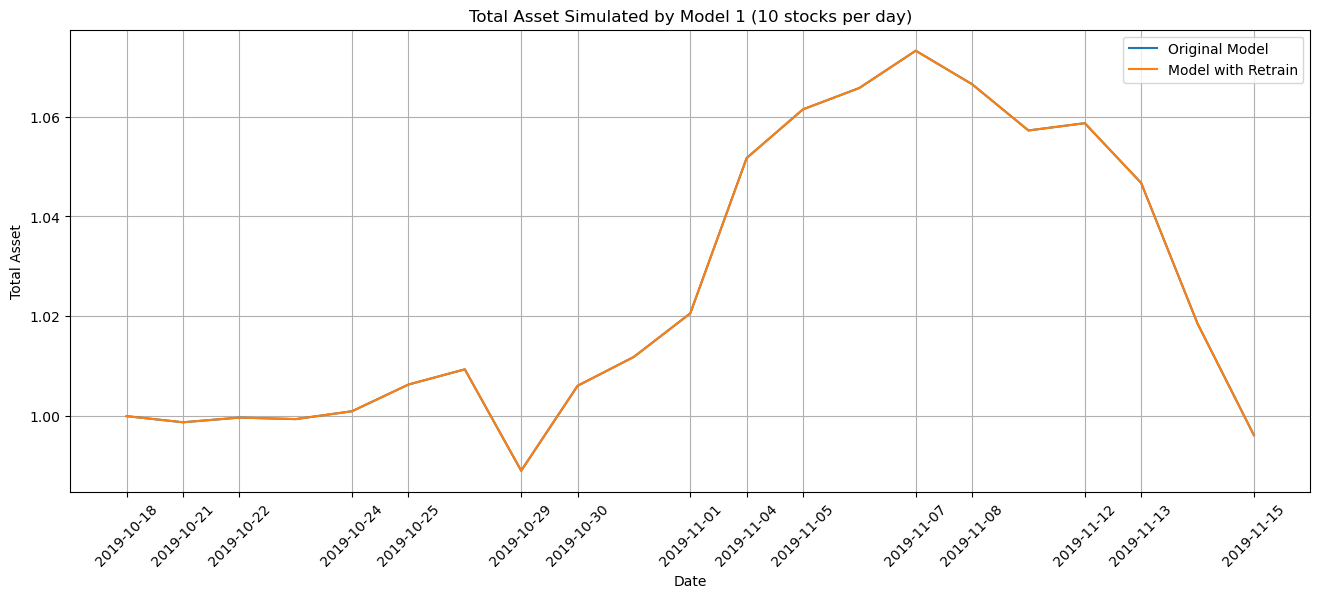

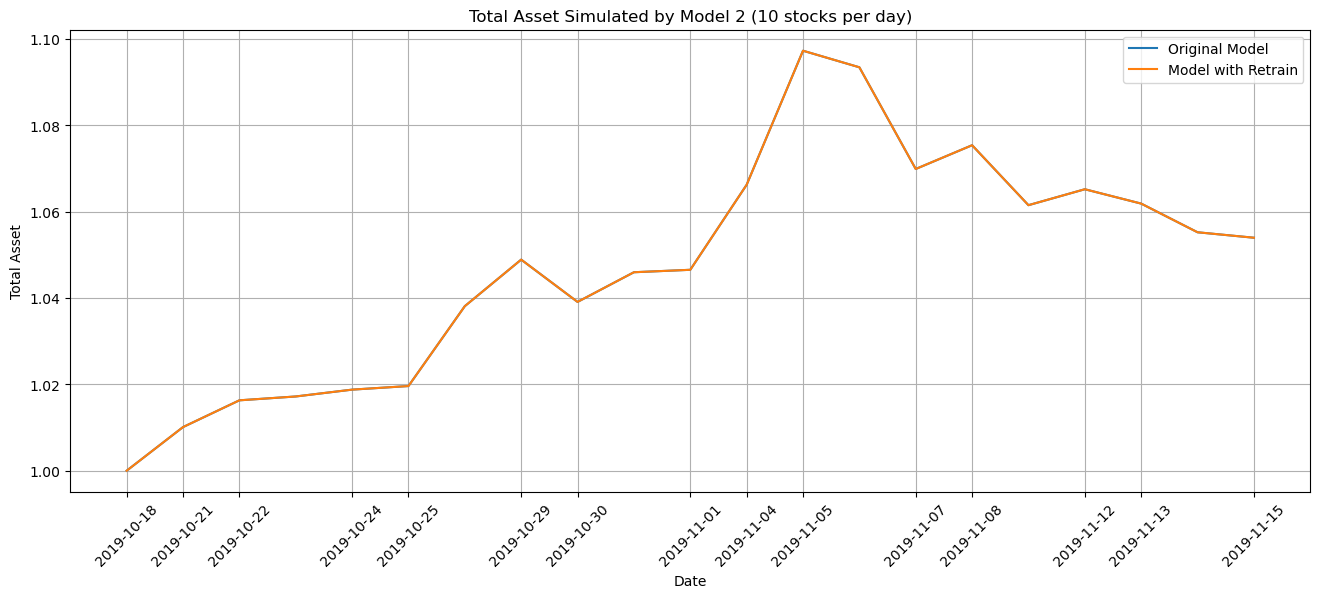

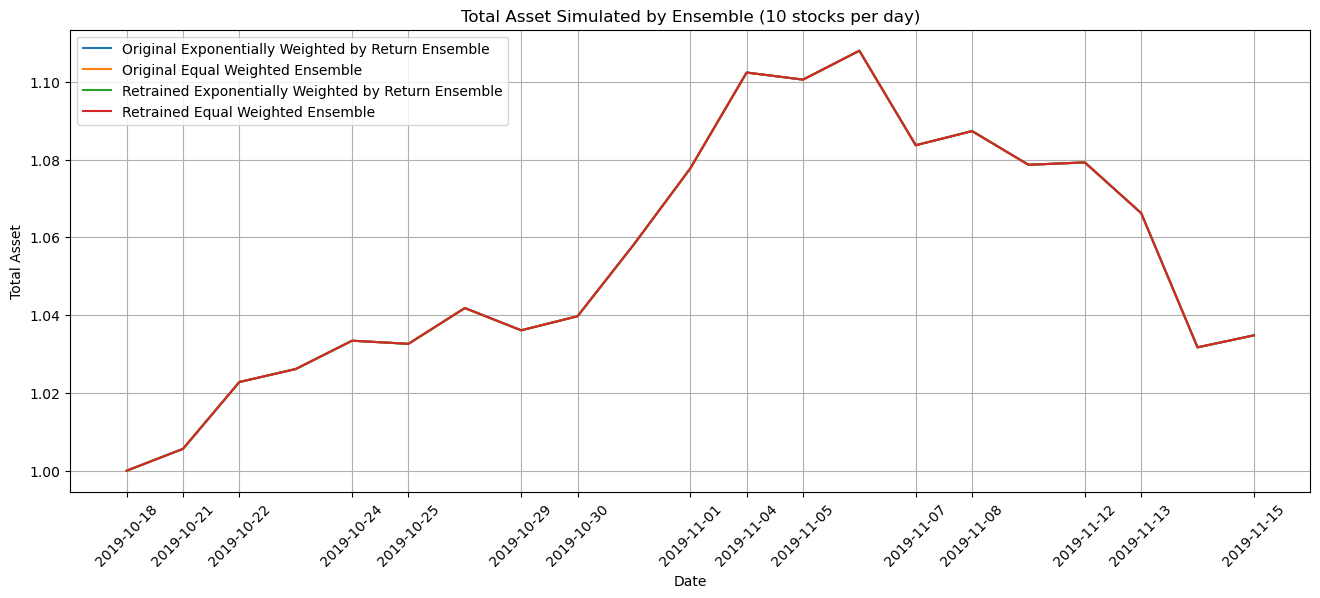

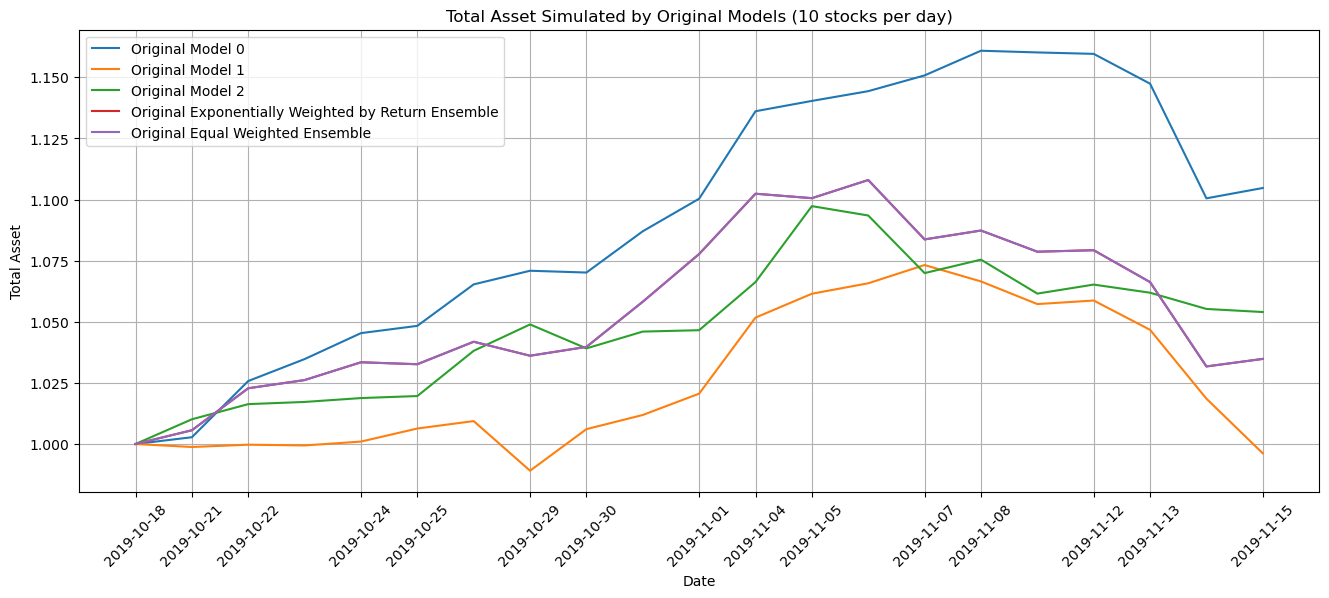

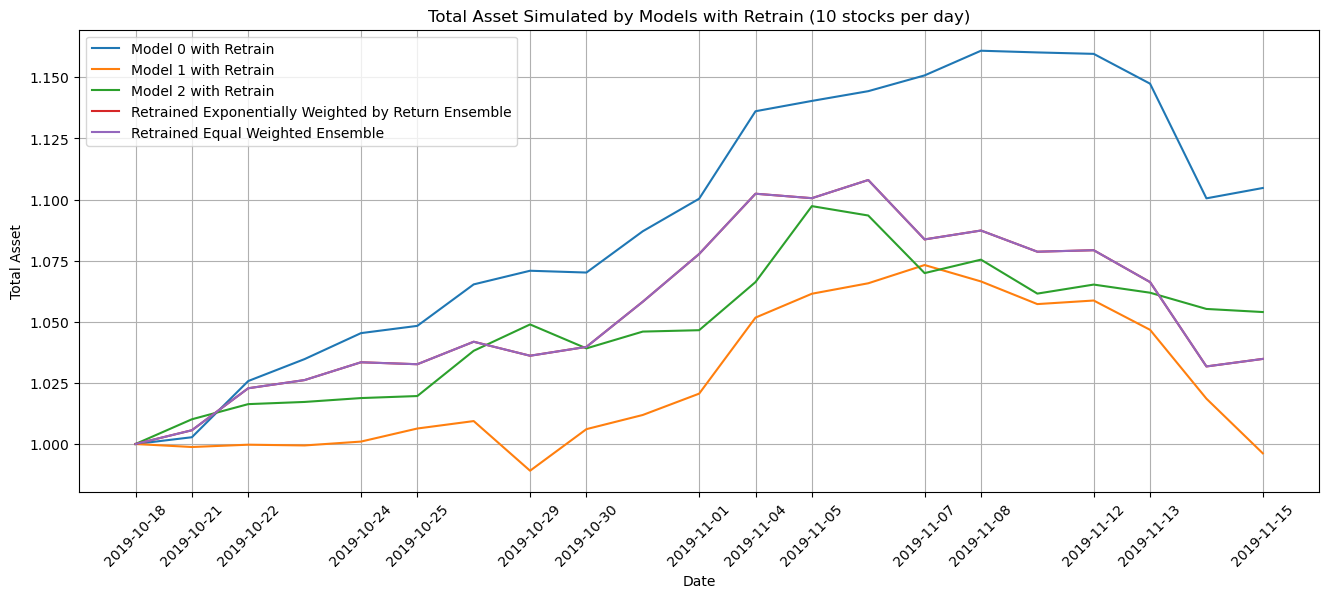

Iteration 2 of 58
Standardization data are from 2019-01-31 to 2019-06-24
Training data are from 2019-06-25 to 2019-11-13
Testing data are from 2019-10-18 to 2019-12-12
Training data have shape (185895, 20, 30), (185895,)
Testing data have shape (45900, 20, 30), (45900,)
Weight of original model 0 is 0.3511656414071027
Weight of retrained model 0 is 0.3511656414071027
Weight of original model 1 is 0.31504435361435446
Weight of retrained model 1 is 0.31504435361435446
Weight of original model 2 is 0.33379000497854266
Weight of retrained model 2 is 0.33379000497854266
top_stocks by original model 0 to buy on 2019-11-15 are ['OPK', 'NTES', 'TENB', 'FLWS', 'RDFN', 'GILD', 'UHAL', 'DINO', 'RNG', 'IBIO']
top_stocks by retrained model 0 to buy on 2019-11-15 are ['OPK', 'NTES', 'TENB', 'FLWS', 'RDFN', 'GILD', 'UHAL', 'DINO', 'RNG', 'IBIO']
Total asset on 2019-11-18 will be 1.090636729925007
It should be the same as 1.090636729925007
Total asset on 2019-11-18 will be 1.090636729925007
It should 

Total asset on 2019-11-20 will be 1.0225826465383343
It should be the same as 1.0225826465383345
top_stocks by original model 0 to buy on 2019-11-20 are ['DCPH', 'WSFS', 'CRON', 'ACLS', 'WK', 'ADNT', 'CHGG', 'DRIP', 'YELP', 'IBIO']
top_stocks by retrained model 0 to buy on 2019-11-20 are ['DCPH', 'WSFS', 'CRON', 'ACLS', 'WK', 'ADNT', 'CHGG', 'DRIP', 'YELP', 'IBIO']
Total asset on 2019-11-21 will be 1.093719146335849
It should be the same as 1.093719146335849
Total asset on 2019-11-21 will be 1.093719146335849
It should be the same as 1.093719146335849
Total asset on 2019-11-21 will be 1.093719146335849
It should be the same as 1.093719146335849
top_stocks by original model 1 to buy on 2019-11-20 are ['PRTA', 'HCSG', 'VSAT', 'SGOL', 'TOON', 'AMR', 'PRPL', 'ARCH', 'NNDM', 'YELP']
top_stocks by retrained model 1 to buy on 2019-11-20 are ['PRTA', 'HCSG', 'VSAT', 'SGOL', 'TOON', 'AMR', 'PRPL', 'ARCH', 'NNDM', 'YELP']
Total asset on 2019-11-21 will be 0.9806074804210962
It should be the same

top_stocks by original model 1 to buy on 2019-11-25 are ['BPMC', 'ANY', 'R', 'ARCH', 'CCOI', 'AWI', 'YPF', 'CCJ', 'ETSY', 'FTI']
top_stocks by retrained model 1 to buy on 2019-11-25 are ['BPMC', 'ANY', 'R', 'ARCH', 'CCOI', 'AWI', 'YPF', 'CCJ', 'ETSY', 'FTI']
Total asset on 2019-11-26 will be 0.9725766222671249
It should be the same as 0.9725766222671273
Total asset on 2019-11-26 will be 0.9725766222671249
It should be the same as 0.9725766222671273
Total asset on 2019-11-26 will be 0.9725766222671249
It should be the same as 0.9725766222671273
top_stocks by original model 2 to buy on 2019-11-25 are ['COP', 'WSM', 'AWI', 'NVMI', 'R', 'PCG', 'DEO', 'SIL', 'FTI', 'HPQ']
top_stocks by retrained model 2 to buy on 2019-11-25 are ['COP', 'WSM', 'AWI', 'NVMI', 'R', 'PCG', 'DEO', 'SIL', 'FTI', 'HPQ']
Total asset on 2019-11-26 will be 1.0538450057964015
It should be the same as 1.0538450057964017
Total asset on 2019-11-26 will be 1.0538450057964015
It should be the same as 1.0538450057964017
Tot

Total asset on 2019-12-02 will be 1.0505411150914976
It should be the same as 1.050541115091498
Total asset on 2019-12-02 will be 1.0505411150914976
It should be the same as 1.050541115091498
Total asset on 2019-12-02 will be 1.0505411150914976
It should be the same as 1.050541115091498
top_stocks by original return weighted ensemble to buy on 2019-11-29 are ['ROK', 'RELX', 'WOLF', 'BFH', 'IHG', 'CBRL', 'TPL', 'MEOH', 'AZN', 'TNK']
Total asset on 2019-12-02 will be 1.0212720058559421
It should be the same as 1.021272005855942
top_stocks by original equal weighted ensemble to buy on 2019-11-29 are ['ROK', 'RELX', 'WOLF', 'BFH', 'IHG', 'CBRL', 'TPL', 'MEOH', 'AZN', 'TNK']
Total asset on 2019-12-02 will be 1.0224008080207676
It should be the same as 1.0224008080207667
top_stocks by retrained return weighted ensemble to buy on 2019-11-29 are ['ROK', 'RELX', 'WOLF', 'BFH', 'IHG', 'CBRL', 'TPL', 'MEOH', 'AZN', 'TNK']
Total asset on 2019-12-02 will be 1.0212720058559421
It should be the same 

Total asset on 2019-12-05 will be 1.1366605669964962
It should be the same as 1.136660566996495
top_stocks by retrained equal weighted ensemble to buy on 2019-12-04 are ['FTGC', 'FXN', 'ALLO', 'GLNG', 'CDLX', 'AMKR', 'GDDY', 'OXY', 'TENB', 'BIL']
Total asset on 2019-12-05 will be 1.1379332834878364
It should be the same as 1.1379332834878355
top_stocks by original model 0 to buy on 2019-12-05 are ['EVBG', 'SSNC', 'VRNS', 'AEHR', 'CYBR', 'HIBB', 'TREE', 'IHG', 'MMYT', 'PDD']
top_stocks by retrained model 0 to buy on 2019-12-05 are ['EVBG', 'SSNC', 'VRNS', 'AEHR', 'CYBR', 'HIBB', 'TREE', 'IHG', 'MMYT', 'PDD']
Total asset on 2019-12-06 will be 1.2231955563165624
It should be the same as 1.2231955563165633
Total asset on 2019-12-06 will be 1.2231955563165624
It should be the same as 1.2231955563165633
Total asset on 2019-12-06 will be 1.2231955563165624
It should be the same as 1.2231955563165633
top_stocks by original model 1 to buy on 2019-12-05 are ['SIG', 'BRKR', 'MMS', 'VOYA', 'AAL', 

top_stocks by original model 0 to buy on 2019-12-10 are ['HMY', 'LUMN', 'CHGG', 'FCEL', 'AMR', 'AR', 'ZYME', 'XRX', 'ROKU', 'AXSM']
top_stocks by retrained model 0 to buy on 2019-12-10 are ['HMY', 'LUMN', 'CHGG', 'FCEL', 'AMR', 'AR', 'ZYME', 'XRX', 'ROKU', 'AXSM']
Total asset on 2019-12-11 will be 1.257861296263352
It should be the same as 1.257861296263353
Total asset on 2019-12-11 will be 1.257861296263352
It should be the same as 1.257861296263353
Total asset on 2019-12-11 will be 1.257861296263352
It should be the same as 1.257861296263353
top_stocks by original model 1 to buy on 2019-12-10 are ['CYH', 'EXEL', 'COMM', 'RILY', 'APT', 'BGS', 'XRX', 'NNDM', 'PTGX', 'IBIO']
top_stocks by retrained model 1 to buy on 2019-12-10 are ['CYH', 'EXEL', 'COMM', 'RILY', 'APT', 'BGS', 'XRX', 'NNDM', 'PTGX', 'IBIO']
Total asset on 2019-12-11 will be 1.0743072105852398
It should be the same as 1.074307210585242
Total asset on 2019-12-11 will be 1.0743072105852398
It should be the same as 1.0743072

top_stocks by original model 1 to buy on 2019-12-13 are ['PAA', 'MPLX', 'SUPN', 'AM', 'WES', 'AVNS', 'HESM', 'ENLC', 'IBIO', 'TOON']
top_stocks by retrained model 1 to buy on 2019-12-13 are ['PAA', 'MPLX', 'SUPN', 'AM', 'WES', 'AVNS', 'HESM', 'ENLC', 'IBIO', 'TOON']
Total asset on 2019-12-16 will be 1.0299622307409544
It should be the same as 1.0299622307409566
Total asset on 2019-12-16 will be 1.0299622307409544
It should be the same as 1.0299622307409566
Total asset on 2019-12-16 will be 1.0299622307409544
It should be the same as 1.0299622307409566
top_stocks by original model 2 to buy on 2019-12-13 are ['WES', 'ERY', 'CQP', 'BKE', 'HESM', 'ETRN', 'CRK', 'MPLX', 'AM', 'ENLC']
top_stocks by retrained model 2 to buy on 2019-12-13 are ['WES', 'ERY', 'CQP', 'BKE', 'HESM', 'ETRN', 'CRK', 'MPLX', 'AM', 'ENLC']
Total asset on 2019-12-16 will be 1.079290499497273
It should be the same as 1.0792904994972734
Total asset on 2019-12-16 will be 1.079290499497273
It should be the same as 1.079290

Total asset on 2019-12-18 will be 1.1397491029886408
It should be the same as 1.1397491029886408
top_stocks by retrained equal weighted ensemble to buy on 2019-12-17 are ['MOS', 'AXL', 'ALB', 'BGFV', 'TEX', 'FDX', 'LZB', 'GPS', 'ALTM', 'MOD']
Total asset on 2019-12-18 will be 1.1401198891943645
It should be the same as 1.1401198891943627
top_stocks by original model 0 to buy on 2019-12-18 are ['TDC', 'HOG', 'MKTX', 'EWM', 'EEMV', 'BJ', 'JNPR', 'LZB', 'EBS', 'KOD']
top_stocks by retrained model 0 to buy on 2019-12-18 are ['TDC', 'HOG', 'MKTX', 'EWM', 'EEMV', 'BJ', 'JNPR', 'LZB', 'EBS', 'KOD']
Total asset on 2019-12-19 will be 1.332091628972054
It should be the same as 1.3320916289720552
Total asset on 2019-12-19 will be 1.332091628972054
It should be the same as 1.3320916289720552
Total asset on 2019-12-19 will be 1.332091628972054
It should be the same as 1.3320916289720552
top_stocks by original model 1 to buy on 2019-12-18 are ['MUR', 'EEMV', 'TEX', 'ASND', 'CC', 'EBS', 'BA', 'JNPR',

top_stocks by original model 0 to buy on 2019-12-23 are ['XRX', 'URBN', 'ACLS', 'TBF', 'AEM', 'ARWR', 'TBT', 'TMV', 'TNK', 'IBIO']
top_stocks by retrained model 0 to buy on 2019-12-23 are ['XRX', 'URBN', 'ACLS', 'TBF', 'AEM', 'ARWR', 'TBT', 'TMV', 'TNK', 'IBIO']
Total asset on 2019-12-24 will be 1.3775934261922005
It should be the same as 1.3775934261922016
Total asset on 2019-12-24 will be 1.3775934261922005
It should be the same as 1.3775934261922016
Total asset on 2019-12-24 will be 1.3775934261922005
It should be the same as 1.3775934261922016
top_stocks by original model 1 to buy on 2019-12-23 are ['AVAV', 'CENN', 'XOM', 'URBN', 'DDD', 'CBRL', 'PBI', 'ADT', 'TBT', 'TMV']
top_stocks by retrained model 1 to buy on 2019-12-23 are ['AVAV', 'CENN', 'XOM', 'URBN', 'DDD', 'CBRL', 'PBI', 'ADT', 'TBT', 'TMV']
Total asset on 2019-12-24 will be 1.0315252686373242
It should be the same as 1.0315252686373262
Total asset on 2019-12-24 will be 1.0315252686373242
It should be the same as 1.031525

top_stocks by original model 1 to buy on 2019-12-27 are ['VRNT', 'IDCC', 'CARG', 'TS', 'MVIS', 'VSTO', 'WWW', 'PAYC', 'SKY', 'SAGE']
top_stocks by retrained model 1 to buy on 2019-12-27 are ['VRNT', 'IDCC', 'CARG', 'TS', 'MVIS', 'VSTO', 'WWW', 'PAYC', 'SKY', 'SAGE']
Total asset on 2019-12-30 will be 1.0427165414403445
It should be the same as 1.0427165414403472
Total asset on 2019-12-30 will be 1.0427165414403445
It should be the same as 1.0427165414403472
Total asset on 2019-12-30 will be 1.0427165414403445
It should be the same as 1.0427165414403472
top_stocks by original model 2 to buy on 2019-12-27 are ['PAYC', 'WWW', 'VSTO', 'SKY', 'KOD', 'GVA', 'OLLI', 'ZD', 'COLM', 'MVIS']
top_stocks by retrained model 2 to buy on 2019-12-27 are ['PAYC', 'WWW', 'VSTO', 'SKY', 'KOD', 'GVA', 'OLLI', 'ZD', 'COLM', 'MVIS']
Total asset on 2019-12-30 will be 1.1300371395230573
It should be the same as 1.1300371395230573
Total asset on 2019-12-30 will be 1.1300371395230573
It should be the same as 1.13

top_stocks by original model 2 to buy on 2020-01-02 are ['VKTX', 'RH', 'GTHX', 'WIX', 'ADT', 'UPS', 'SAGE', 'VTNR', 'BNDX', 'KOD']
top_stocks by retrained model 2 to buy on 2020-01-02 are ['VKTX', 'RH', 'GTHX', 'WIX', 'ADT', 'UPS', 'SAGE', 'VTNR', 'BNDX', 'KOD']
Total asset on 2020-01-03 will be 1.1220477467159384
It should be the same as 1.1220477467159373
Total asset on 2020-01-03 will be 1.1220477467159384
It should be the same as 1.1220477467159373
Total asset on 2020-01-03 will be 1.1220477467159384
It should be the same as 1.1220477467159373
top_stocks by original return weighted ensemble to buy on 2020-01-02 are ['VKTX', 'EVH', 'ADT', 'SNN', 'ADNT', 'VTNR', 'BNDX', 'SAVA', 'SAGE', 'KOD']
Total asset on 2020-01-03 will be 1.1531516418950554
It should be the same as 1.153151641895055
top_stocks by original equal weighted ensemble to buy on 2020-01-02 are ['UPS', 'EVH', 'SNN', 'ADT', 'ADNT', 'VTNR', 'SAVA', 'BNDX', 'SAGE', 'KOD']
Total asset on 2020-01-03 will be 1.144157434748737


Total asset on 2020-01-08 will be 1.1165046152091482
It should be the same as 1.1165046152091487
top_stocks by retrained equal weighted ensemble to buy on 2020-01-07 are ['SPR', 'GPRE', 'RYTM', 'RGLD', 'RUSHA', 'PTGX', 'GIII', 'AXSM', 'VANI', 'KOD']
Total asset on 2020-01-08 will be 1.106579226877356
It should be the same as 1.1065792268773558
top_stocks by original model 0 to buy on 2020-01-08 are ['UCTT', 'AMKR', 'GPRE', 'IOVA', 'PARR', 'HOUS', 'ADT', 'BTAI', 'VANI', 'SAVA']
top_stocks by retrained model 0 to buy on 2020-01-08 are ['UCTT', 'AMKR', 'GPRE', 'IOVA', 'PARR', 'HOUS', 'ADT', 'BTAI', 'VANI', 'SAVA']
Total asset on 2020-01-09 will be 1.2533341424714273
It should be the same as 1.2533341424714282
Total asset on 2020-01-09 will be 1.2533341424714273
It should be the same as 1.2533341424714282
Total asset on 2020-01-09 will be 1.2533341424714273
It should be the same as 1.2533341424714282
top_stocks by original model 1 to buy on 2020-01-08 are ['ICUI', 'MOS', 'EGHT', 'PARR', 'P

top_stocks by original model 0 to buy on 2020-01-13 are ['SBH', 'OLLI', 'CPRI', 'EWS', 'IFF', 'CLF', 'AXSM', 'NUE', 'EXPRQ', 'SAVA']
top_stocks by retrained model 0 to buy on 2020-01-13 are ['SBH', 'OLLI', 'CPRI', 'EWS', 'IFF', 'CLF', 'AXSM', 'NUE', 'EXPRQ', 'SAVA']
Total asset on 2020-01-14 will be 1.2304141972500136
It should be the same as 1.2304141972500147
Total asset on 2020-01-14 will be 1.2304141972500136
It should be the same as 1.2304141972500147
Total asset on 2020-01-14 will be 1.2304141972500136
It should be the same as 1.2304141972500147
top_stocks by original model 1 to buy on 2020-01-13 are ['CWH', 'IFF', 'CPRI', 'LIVN', 'OLLI', 'EXPRQ', 'NUE', 'QGEN', 'CLF', 'SAVA']
top_stocks by retrained model 1 to buy on 2020-01-13 are ['CWH', 'IFF', 'CPRI', 'LIVN', 'OLLI', 'EXPRQ', 'NUE', 'QGEN', 'CLF', 'SAVA']
Total asset on 2020-01-14 will be 0.9788595524541283
It should be the same as 0.9788595524541314
Total asset on 2020-01-14 will be 0.9788595524541283
It should be the same a

top_stocks by original model 2 to buy on 2020-01-15 are ['NCLH', 'GOGL', 'AVNS', 'DVAX', 'LIVN', 'AXSM', 'QTWO', 'ZOM', 'TNK', 'KOD']
top_stocks by retrained model 2 to buy on 2020-01-15 are ['NCLH', 'GOGL', 'AVNS', 'DVAX', 'LIVN', 'AXSM', 'QTWO', 'ZOM', 'TNK', 'KOD']
Total asset on 2020-01-16 will be 1.108491992225515
It should be the same as 1.1084919922255139
Total asset on 2020-01-16 will be 1.108491992225515
It should be the same as 1.1084919922255139
Total asset on 2020-01-16 will be 1.108491992225515
It should be the same as 1.1084919922255139
top_stocks by original return weighted ensemble to buy on 2020-01-15 are ['NTLA', 'DVAX', 'ENR', 'RYTM', 'TCBI', 'AXSM', 'ARWR', 'QTWO', 'ZOM', 'KOD']
Total asset on 2020-01-16 will be 1.136717656268699
It should be the same as 1.1367176562686996
top_stocks by original equal weighted ensemble to buy on 2020-01-15 are ['DVAX', 'NTLA', 'ENR', 'RYTM', 'TCBI', 'AXSM', 'QTWO', 'ARWR', 'ZOM', 'KOD']
Total asset on 2020-01-16 will be 1.1086097687

Total asset on 2020-01-22 will be 1.1069179967075622
It should be the same as 1.1069179967075629
top_stocks by retrained equal weighted ensemble to buy on 2020-01-21 are ['PARA', 'MNRO', 'ARWR', 'ZYME', 'OXM', 'EXPRQ', 'VANI', 'ESGU', 'AXSM', 'KOD']
Total asset on 2020-01-22 will be 1.078048962843644
It should be the same as 1.0780489628436434
top_stocks by original model 0 to buy on 2020-01-22 are ['APT', 'SON', 'EGO', 'SENS', 'PRTA', 'IRWD', 'SGOL', 'ARWR', 'KOD', 'AXSM']
top_stocks by retrained model 0 to buy on 2020-01-22 are ['APT', 'SON', 'EGO', 'SENS', 'PRTA', 'IRWD', 'SGOL', 'ARWR', 'KOD', 'AXSM']
Total asset on 2020-01-23 will be 1.2456930347036423
It should be the same as 1.2456930347036437
Total asset on 2020-01-23 will be 1.2456930347036423
It should be the same as 1.2456930347036437
Total asset on 2020-01-23 will be 1.2456930347036423
It should be the same as 1.2456930347036437
top_stocks by original model 1 to buy on 2020-01-22 are ['SENS', 'CTRA', 'SFIX', 'KOD', 'ACB', '

top_stocks by original model 0 to buy on 2020-01-27 are ['AZN', 'OIH', 'AG', 'LBRT', 'NCLH', 'DVAX', 'KOD', 'HMY', 'AXSM', 'APT']
top_stocks by retrained model 0 to buy on 2020-01-27 are ['AZN', 'OIH', 'AG', 'LBRT', 'NCLH', 'DVAX', 'KOD', 'HMY', 'AXSM', 'APT']
Total asset on 2020-01-28 will be 1.2231378662178054
It should be the same as 1.2231378662178065
Total asset on 2020-01-28 will be 1.2231378662178054
It should be the same as 1.2231378662178065
Total asset on 2020-01-28 will be 1.2231378662178054
It should be the same as 1.2231378662178065
top_stocks by original model 1 to buy on 2020-01-27 are ['ENPH', 'NOV', 'SSRM', 'AG', 'NXE', 'SNDX', 'AR', 'HMY', 'GFI', 'APT']
top_stocks by retrained model 1 to buy on 2020-01-27 are ['ENPH', 'NOV', 'SSRM', 'AG', 'NXE', 'SNDX', 'AR', 'HMY', 'GFI', 'APT']
Total asset on 2020-01-28 will be 0.8862370707864792
It should be the same as 0.8862370707864828
Total asset on 2020-01-28 will be 0.8862370707864792
It should be the same as 0.88623707078648

Total asset on 2020-01-31 will be 1.1922555123498437
It should be the same as 1.1922555123498446
Total asset on 2020-01-31 will be 1.1922555123498437
It should be the same as 1.1922555123498446
Total asset on 2020-01-31 will be 1.1922555123498437
It should be the same as 1.1922555123498446
top_stocks by original model 1 to buy on 2020-01-30 are ['MSM', 'ODP', 'ITCI', 'SLB', 'KOLD', 'EXPRQ', 'AMR', 'AXSM', 'VANI', 'APT']
top_stocks by retrained model 1 to buy on 2020-01-30 are ['MSM', 'ODP', 'ITCI', 'SLB', 'KOLD', 'EXPRQ', 'AMR', 'AXSM', 'VANI', 'APT']
Total asset on 2020-01-31 will be 0.836997787632651
It should be the same as 0.8369977876326543
Total asset on 2020-01-31 will be 0.836997787632651
It should be the same as 0.8369977876326543
Total asset on 2020-01-31 will be 0.836997787632651
It should be the same as 0.8369977876326543
top_stocks by original model 2 to buy on 2020-01-30 are ['PSLV', 'SLB', 'FTI', 'KOLD', 'BLDP', 'OIH', 'VANI', 'CODX', 'SBSW', 'AXSM']
top_stocks by retrai

top_stocks by original model 1 to buy on 2020-02-04 are ['OXM', 'NVR', 'CODX', 'AAP', 'CLNE', 'SUN', 'HBI', 'ITCI', 'MTDR', 'IBIO']
top_stocks by retrained model 1 to buy on 2020-02-04 are ['OXM', 'NVR', 'CODX', 'AAP', 'CLNE', 'SUN', 'HBI', 'ITCI', 'MTDR', 'IBIO']
Total asset on 2020-02-05 will be 0.8424210764956074
It should be the same as 0.8424210764956103
Total asset on 2020-02-05 will be 0.8424210764956074
It should be the same as 0.8424210764956103
Total asset on 2020-02-05 will be 0.8424210764956074
It should be the same as 0.8424210764956103
top_stocks by original model 2 to buy on 2020-02-04 are ['AEO', 'URBN', 'ASB', 'GSAT', 'NVR', 'NVDA', 'AXSM', 'PAGS', 'GUSH', 'IBIO']
top_stocks by retrained model 2 to buy on 2020-02-04 are ['AEO', 'URBN', 'ASB', 'GSAT', 'NVR', 'NVDA', 'AXSM', 'PAGS', 'GUSH', 'IBIO']
Total asset on 2020-02-05 will be 1.076393745516393
It should be the same as 1.0763937455163934
Total asset on 2020-02-05 will be 1.076393745516393
It should be the same as 1.

Total asset on 2020-02-10 will be 0.8586804998246619
It should be the same as 0.858680499824665
Total asset on 2020-02-10 will be 0.8586804998246619
It should be the same as 0.858680499824665
Total asset on 2020-02-10 will be 0.8586804998246619
It should be the same as 0.858680499824665
top_stocks by original model 2 to buy on 2020-02-07 are ['ILF', 'CLS', 'SBSW', 'ACMR', 'BBD', 'VKTX', 'SEDG', 'BLDP', 'AXSM', 'SAVA']
top_stocks by retrained model 2 to buy on 2020-02-07 are ['ILF', 'CLS', 'SBSW', 'ACMR', 'BBD', 'VKTX', 'SEDG', 'BLDP', 'AXSM', 'SAVA']
Total asset on 2020-02-10 will be 1.0902970944491588
It should be the same as 1.0902970944491583
Total asset on 2020-02-10 will be 1.0902970944491588
It should be the same as 1.0902970944491583
Total asset on 2020-02-10 will be 1.0902970944491588
It should be the same as 1.0902970944491583
top_stocks by original return weighted ensemble to buy on 2020-02-07 are ['HUYA', 'BIDU', 'SBSW', 'ARWR', 'BBD', 'VKTX', 'SSRM', 'SAVA', 'BLDP', 'AXSM']

top_stocks by original model 2 to buy on 2020-02-12 are ['FL', 'CTLT', 'AXSM', 'TPR', 'SSRM', 'OXY', 'GEN', 'OVV', 'TSLA', 'APT']
top_stocks by retrained model 2 to buy on 2020-02-12 are ['FL', 'CTLT', 'AXSM', 'TPR', 'SSRM', 'OXY', 'GEN', 'OVV', 'TSLA', 'APT']
Total asset on 2020-02-13 will be 1.1284589216656624
It should be the same as 1.1284589216656618
Total asset on 2020-02-13 will be 1.1284589216656624
It should be the same as 1.1284589216656618
Total asset on 2020-02-13 will be 1.1284589216656624
It should be the same as 1.1284589216656618
top_stocks by original return weighted ensemble to buy on 2020-02-12 are ['GEN', 'FL', 'HUYA', 'OXY', 'TSLA', 'CTLT', 'BOIL', 'CNX', 'OVV', 'APT']
Total asset on 2020-02-13 will be 1.108761250095184
It should be the same as 1.1087612500951853
top_stocks by original equal weighted ensemble to buy on 2020-02-12 are ['GEN', 'FL', 'TSLA', 'HUYA', 'OXY', 'CTLT', 'BOIL', 'CNX', 'OVV', 'APT']
Total asset on 2020-02-13 will be 1.0628198935378081
It sho

Total asset on 2020-02-18 will be 1.0568363240229353
It should be the same as 1.0568363240229348
top_stocks by original model 0 to buy on 2020-02-18 are ['NWL', 'SM', 'BB', 'FNKO', 'ANGI', 'GPRO', 'PR', 'PPL', 'VXRT', 'BTAI']
top_stocks by retrained model 0 to buy on 2020-02-18 are ['NWL', 'SM', 'BB', 'FNKO', 'ANGI', 'GPRO', 'PR', 'PPL', 'VXRT', 'BTAI']
Total asset on 2020-02-19 will be 1.301920631229414
It should be the same as 1.3019206312294163
Total asset on 2020-02-19 will be 1.301920631229414
It should be the same as 1.3019206312294163
Total asset on 2020-02-19 will be 1.301920631229414
It should be the same as 1.3019206312294163
top_stocks by original model 1 to buy on 2020-02-18 are ['OKTA', 'ASR', 'SSTK', 'KPTI', 'COHU', 'PTCT', 'ASND', 'BTAI', 'TSLA', 'TNK']
top_stocks by retrained model 1 to buy on 2020-02-18 are ['OKTA', 'ASR', 'SSTK', 'KPTI', 'COHU', 'PTCT', 'ASND', 'BTAI', 'TSLA', 'TNK']
Total asset on 2020-02-19 will be 0.9516905063589227
It should be the same as 0.95169

Total asset on 2020-02-24 will be 1.2686513843792007
It should be the same as 1.2686513843792036
Total asset on 2020-02-24 will be 1.2686513843792007
It should be the same as 1.2686513843792036
Total asset on 2020-02-24 will be 1.2686513843792007
It should be the same as 1.2686513843792036
top_stocks by original model 1 to buy on 2020-02-21 are ['WDAY', 'SMAR', 'INVH', 'VRSK', 'IAG', 'CABO', 'CDE', 'YY', 'IBIO', 'HRL']
top_stocks by retrained model 1 to buy on 2020-02-21 are ['WDAY', 'SMAR', 'INVH', 'VRSK', 'IAG', 'CABO', 'CDE', 'YY', 'IBIO', 'HRL']
Total asset on 2020-02-24 will be 0.9224128773048633
It should be the same as 0.9224128773048668
Total asset on 2020-02-24 will be 0.9224128773048633
It should be the same as 0.9224128773048668
Total asset on 2020-02-24 will be 0.9224128773048633
It should be the same as 0.9224128773048668
top_stocks by original model 2 to buy on 2020-02-21 are ['KOD', 'IBIO', 'ACB', 'BLDP', 'ZOM', 'TSLA', 'APT', 'SAVA', 'AUPH', 'VXRT']
top_stocks by retrai

Total asset on 2020-02-27 will be 0.8582970958765778
It should be the same as 0.8582970958765812
Total asset on 2020-02-27 will be 0.8582970958765778
It should be the same as 0.8582970958765812
Total asset on 2020-02-27 will be 0.8582970958765778
It should be the same as 0.8582970958765812
top_stocks by original model 2 to buy on 2020-02-26 are ['OXY', 'DBI', 'OGI', 'BOIL', 'TUP', 'TSLA', 'SAVA', 'AUPH', 'APT', 'VXRT']
top_stocks by retrained model 2 to buy on 2020-02-26 are ['OXY', 'DBI', 'OGI', 'BOIL', 'TUP', 'TSLA', 'SAVA', 'AUPH', 'APT', 'VXRT']
Total asset on 2020-02-27 will be 1.3000931420618327
It should be the same as 1.3000931420618325
Total asset on 2020-02-27 will be 1.3000931420618327
It should be the same as 1.3000931420618325
Total asset on 2020-02-27 will be 1.3000931420618327
It should be the same as 1.3000931420618325
top_stocks by original return weighted ensemble to buy on 2020-02-26 are ['YELP', 'DBI', 'TNK', 'TUP', 'VXRT', 'BOIL', 'ASND', 'RGNX', 'OXY', 'APT']
Tota

Total asset on 2020-03-03 will be 1.443706824979396
It should be the same as 1.4437068249793963
Total asset on 2020-03-03 will be 1.443706824979396
It should be the same as 1.4437068249793963
top_stocks by original return weighted ensemble to buy on 2020-03-02 are ['PI', 'EXPO', 'KOD', 'FLOT', 'GDDY', 'GEN', 'BLDP', 'ALT', 'APT', 'TSLA']
Total asset on 2020-03-03 will be 1.1858263807682967
It should be the same as 1.1858263807682985
top_stocks by original equal weighted ensemble to buy on 2020-03-02 are ['HSY', 'KOD', 'EXPO', 'FLOT', 'GEN', 'GDDY', 'BLDP', 'ALT', 'APT', 'TSLA']
Total asset on 2020-03-03 will be 1.0087253774692337
It should be the same as 1.0087253774692324
top_stocks by retrained return weighted ensemble to buy on 2020-03-02 are ['PI', 'EXPO', 'KOD', 'FLOT', 'GDDY', 'GEN', 'BLDP', 'ALT', 'APT', 'TSLA']
Total asset on 2020-03-03 will be 1.1858263807682967
It should be the same as 1.1858263807682985
top_stocks by retrained equal weighted ensemble to buy on 2020-03-02 are

Total asset on 2020-03-06 will be 1.2964128958238301
It should be the same as 1.2964128958238321
top_stocks by retrained equal weighted ensemble to buy on 2020-03-05 are ['AMR', 'BTAI', 'NIO', 'DUST', 'TOON', 'CODX', 'SIG', 'IBIO', 'INO', 'TNK']
Total asset on 2020-03-06 will be 1.0717173393915504
It should be the same as 1.071717339391549
top_stocks by original model 0 to buy on 2020-03-06 are ['MYGN', 'KURA', 'AR', 'PLUG', 'TOON', 'TNK', 'ZOM', 'INO', 'TSLA', 'VANI']
top_stocks by retrained model 0 to buy on 2020-03-06 are ['MYGN', 'KURA', 'AR', 'PLUG', 'TOON', 'TNK', 'ZOM', 'INO', 'TSLA', 'VANI']
Total asset on 2020-03-09 will be 1.768409021802895
It should be the same as 1.7684090218028972
Total asset on 2020-03-09 will be 1.768409021802895
It should be the same as 1.7684090218028972
Total asset on 2020-03-09 will be 1.768409021802895
It should be the same as 1.7684090218028972
top_stocks by original model 1 to buy on 2020-03-06 are ['AMR', 'TDOC', 'AY', 'SIG', 'SPMB', 'MVIS', 'UTH

top_stocks by original model 0 to buy on 2020-03-11 are ['NVRO', 'VTLE', 'HZO', 'ACB', 'IBIO', 'PTEN', 'ZOM', 'NNDM', 'INO', 'APT']
top_stocks by retrained model 0 to buy on 2020-03-11 are ['NVRO', 'VTLE', 'HZO', 'ACB', 'IBIO', 'PTEN', 'ZOM', 'NNDM', 'INO', 'APT']
Total asset on 2020-03-12 will be 1.5465031693647577
It should be the same as 1.54650316936476
Total asset on 2020-03-12 will be 1.5465031693647577
It should be the same as 1.54650316936476
Total asset on 2020-03-12 will be 1.5465031693647577
It should be the same as 1.54650316936476
top_stocks by original model 1 to buy on 2020-03-11 are ['SMAR', 'CHRS', 'CVCO', 'ALRM', 'EMB', 'BAC.PL', 'OVV', 'CODX', 'INO', 'APT']
top_stocks by retrained model 1 to buy on 2020-03-11 are ['SMAR', 'CHRS', 'CVCO', 'ALRM', 'EMB', 'BAC.PL', 'OVV', 'CODX', 'INO', 'APT']
Total asset on 2020-03-12 will be 0.784098289315753
It should be the same as 0.7840982893157561
Total asset on 2020-03-12 will be 0.784098289315753
It should be the same as 0.7840

top_stocks by original model 2 to buy on 2020-03-13 are ['SPMB', 'TMF', 'MUB', 'CODX', 'BOND', 'SCHZ', 'HYMB', 'FMB', 'VTEB', 'APT']
top_stocks by retrained model 2 to buy on 2020-03-13 are ['SPMB', 'TMF', 'MUB', 'CODX', 'BOND', 'SCHZ', 'HYMB', 'FMB', 'VTEB', 'APT']
Total asset on 2020-03-16 will be 1.3481156076883085
It should be the same as 1.3481156076883094
Total asset on 2020-03-16 will be 1.3481156076883085
It should be the same as 1.3481156076883094
Total asset on 2020-03-16 will be 1.3481156076883085
It should be the same as 1.3481156076883094
top_stocks by original return weighted ensemble to buy on 2020-03-13 are ['BOND', 'FBND', 'VTEB', 'SHM', 'SPIB', 'SPAB', 'ITM', 'HYMB', 'SPMB', 'FMB']
Total asset on 2020-03-16 will be 1.155110724610037
It should be the same as 1.1551107246100392
top_stocks by original equal weighted ensemble to buy on 2020-03-13 are ['BOND', 'FBND', 'SHM', 'SPIB', 'VTEB', 'SPAB', 'ITM', 'HYMB', 'SPMB', 'FMB']
Total asset on 2020-03-16 will be 0.972253988

Total asset on 2020-03-19 will be 1.2372808503735102
It should be the same as 1.2372808503735127
top_stocks by retrained equal weighted ensemble to buy on 2020-03-18 are ['JDST', 'JPST', 'APT', 'GSY', 'FLRN', 'NEAR', 'MINT', 'INO', 'DRIP', 'FTSM']
Total asset on 2020-03-19 will be 1.0424020392766036
It should be the same as 1.0424020392766027
top_stocks by original model 0 to buy on 2020-03-19 are ['SHM', 'SPIB', 'BKLN', 'SPSB', 'ITM', 'PULS', 'INO', 'FPE', 'FLOT', 'FTSM']
top_stocks by retrained model 0 to buy on 2020-03-19 are ['SHM', 'SPIB', 'BKLN', 'SPSB', 'ITM', 'PULS', 'INO', 'FPE', 'FLOT', 'FTSM']
Total asset on 2020-03-20 will be 1.7377036549698863
It should be the same as 1.7377036549698897
Total asset on 2020-03-20 will be 1.7377036549698863
It should be the same as 1.7377036549698897
Total asset on 2020-03-20 will be 1.7377036549698863
It should be the same as 1.7377036549698897
top_stocks by original model 1 to buy on 2020-03-19 are ['PGX', 'TNK', 'VWOB', 'SHM', 'BAB', 'GSY

Total asset on 2020-03-25 will be 1.7259393918839536
It should be the same as 1.7259393918839565
Total asset on 2020-03-25 will be 1.7259393918839536
It should be the same as 1.7259393918839565
Total asset on 2020-03-25 will be 1.7259393918839536
It should be the same as 1.7259393918839565
top_stocks by original model 1 to buy on 2020-03-24 are ['TWM', 'SRTY', 'YANG', 'JPST', 'TZA', 'VIXY', 'DRIP', 'UVXY', 'ERY', 'BIL']
top_stocks by retrained model 1 to buy on 2020-03-24 are ['TWM', 'SRTY', 'YANG', 'JPST', 'TZA', 'VIXY', 'DRIP', 'UVXY', 'ERY', 'BIL']
Total asset on 2020-03-25 will be 0.8778236863529955
It should be the same as 0.8778236863529989
Total asset on 2020-03-25 will be 0.8778236863529955
It should be the same as 0.8778236863529989
Total asset on 2020-03-25 will be 0.8778236863529955
It should be the same as 0.8778236863529989
top_stocks by original model 2 to buy on 2020-03-24 are ['DRIP', 'VIXY', 'HE', 'TZA', 'INO', 'UVXY', 'SCO', 'BIL', 'ERY', 'FTSM']
top_stocks by retrain

top_stocks by original model 1 to buy on 2020-03-27 are ['SPSB', 'IGSB', 'SLQD', 'FTSM', 'TZA', 'JMST', 'VNLA', 'ITM', 'NEAR', 'SCO']
top_stocks by retrained model 1 to buy on 2020-03-27 are ['SPSB', 'IGSB', 'SLQD', 'FTSM', 'TZA', 'JMST', 'VNLA', 'ITM', 'NEAR', 'SCO']
Total asset on 2020-03-30 will be 1.1417349135930137
It should be the same as 1.1417349135930168
Total asset on 2020-03-30 will be 1.1417349135930137
It should be the same as 1.1417349135930168
Total asset on 2020-03-30 will be 1.1417349135930137
It should be the same as 1.1417349135930168
top_stocks by original model 2 to buy on 2020-03-27 are ['DRIP', 'ITM', 'JPST', 'BIL', 'GSY', 'INO', 'FLRN', 'FLOT', 'ERY', 'FTSM']
top_stocks by retrained model 2 to buy on 2020-03-27 are ['DRIP', 'ITM', 'JPST', 'BIL', 'GSY', 'INO', 'FLRN', 'FLOT', 'ERY', 'FTSM']
Total asset on 2020-03-30 will be 1.4613646414420187
It should be the same as 1.4613646414420198
Total asset on 2020-03-30 will be 1.4613646414420187
It should be the same as 

top_stocks by original model 2 to buy on 2020-04-01 are ['BXMT', 'JMST', 'CIM', 'JPST', 'INO', 'PMT', 'BIL', 'ERY', 'FPE', 'FLOT']
top_stocks by retrained model 2 to buy on 2020-04-01 are ['BXMT', 'JMST', 'CIM', 'JPST', 'INO', 'PMT', 'BIL', 'ERY', 'FPE', 'FLOT']
Total asset on 2020-04-02 will be 1.37857616987054
It should be the same as 1.3785761698705414
Total asset on 2020-04-02 will be 1.37857616987054
It should be the same as 1.3785761698705414
Total asset on 2020-04-02 will be 1.37857616987054
It should be the same as 1.3785761698705414
top_stocks by original return weighted ensemble to buy on 2020-04-01 are ['BXMT', 'BKLN', 'JMST', 'FLOT', 'CIM', 'BIL', 'PMT', 'INO', 'FPE', 'ERY']
Total asset on 2020-04-02 will be 1.544585388325272
It should be the same as 1.5445853883252758
top_stocks by original equal weighted ensemble to buy on 2020-04-01 are ['BXMT', 'ABR', 'STWD', 'JMST', 'INO', 'CIM', 'PMT', 'BIL', 'FPE', 'ERY']
Total asset on 2020-04-02 will be 1.2726858641157803
It should

Total asset on 2020-04-07 will be 1.3689214698029066
It should be the same as 1.3689214698029046
top_stocks by original model 0 to buy on 2020-04-07 are ['FCPT', 'SRLN', 'HYMB', 'BXMT', 'ARI', 'INO', 'NYMT', 'PMT', 'APT', 'MFA']
top_stocks by retrained model 0 to buy on 2020-04-07 are ['FCPT', 'SRLN', 'HYMB', 'BXMT', 'ARI', 'INO', 'NYMT', 'PMT', 'APT', 'MFA']
Total asset on 2020-04-08 will be 2.2731155780914634
It should be the same as 2.273115578091468
Total asset on 2020-04-08 will be 2.2731155780914634
It should be the same as 2.273115578091468
Total asset on 2020-04-08 will be 2.2731155780914634
It should be the same as 2.273115578091468
top_stocks by original model 1 to buy on 2020-04-07 are ['CHX', 'ARI', 'PBA', 'JETS', 'PAGP', 'HESM', 'KOLD', 'PAA', 'VANI', 'PMT']
top_stocks by retrained model 1 to buy on 2020-04-07 are ['CHX', 'ARI', 'PBA', 'JETS', 'PAGP', 'HESM', 'KOLD', 'PAA', 'VANI', 'PMT']
Total asset on 2020-04-08 will be 1.163656669703276
It should be the same as 1.163656

Iteration 7 of 58
Standardization data are from 2019-06-25 to 2019-11-13
Training data are from 2019-11-14 to 2020-04-08
Testing data are from 2020-03-13 to 2020-05-07
Training data have shape (185895, 20, 30), (185895,)
Testing data have shape (45900, 20, 30), (45900,)
Weight of original model 0 is 0.5824054294962145
Weight of retrained model 0 is 0.5824054294962145
Weight of original model 1 is 0.16591994165535728
Weight of retrained model 1 is 0.16591994165535728
Weight of original model 2 is 0.25167462884842823
Weight of retrained model 2 is 0.25167462884842823
top_stocks by original model 0 to buy on 2020-04-13 are ['FPE', 'JPST', 'HYLS', 'BKLN', 'SAVA', 'INO', 'FLRN', 'DRIP', 'FTSM', 'APT']
top_stocks by retrained model 0 to buy on 2020-04-13 are ['FPE', 'JPST', 'HYLS', 'BKLN', 'SAVA', 'INO', 'FLRN', 'DRIP', 'FTSM', 'APT']
Total asset on 2020-04-14 will be 2.581866365502647
It should be the same as 2.5818663655026524
Total asset on 2020-04-14 will be 2.581866365502647
It should b

Total asset on 2020-04-16 will be 1.794508596636107
It should be the same as 1.794508596636105
top_stocks by original model 0 to buy on 2020-04-16 are ['BKLN', 'IGSB', 'GSY', 'MFA', 'NEAR', 'FPE', 'FLRN', 'FTSM', 'FLOT', 'APT']
top_stocks by retrained model 0 to buy on 2020-04-16 are ['BKLN', 'IGSB', 'GSY', 'MFA', 'NEAR', 'FPE', 'FLRN', 'FTSM', 'FLOT', 'APT']
Total asset on 2020-04-17 will be 2.622224653557884
It should be the same as 2.622224653557889
Total asset on 2020-04-17 will be 2.622224653557884
It should be the same as 2.622224653557889
Total asset on 2020-04-17 will be 2.622224653557884
It should be the same as 2.622224653557889
top_stocks by original model 1 to buy on 2020-04-16 are ['PMT', 'PFF', 'NEAR', 'BKLN', 'JPST', 'FLRN', 'FPE', 'FLOT', 'FTSM', 'APT']
top_stocks by retrained model 1 to buy on 2020-04-16 are ['PMT', 'PFF', 'NEAR', 'BKLN', 'JPST', 'FLRN', 'FPE', 'FLOT', 'FTSM', 'APT']
Total asset on 2020-04-17 will be 1.308457304046189
It should be the same as 1.3084573

top_stocks by original model 1 to buy on 2020-04-21 are ['SRLN', 'PULS', 'MINT', 'PMT', 'IVR', 'RWT', 'NYMT', 'MFA', 'APT', 'FTSM']
top_stocks by retrained model 1 to buy on 2020-04-21 are ['SRLN', 'PULS', 'MINT', 'PMT', 'IVR', 'RWT', 'NYMT', 'MFA', 'APT', 'FTSM']
Total asset on 2020-04-22 will be 1.3625326713158998
It should be the same as 1.362532671315902
Total asset on 2020-04-22 will be 1.3625326713158998
It should be the same as 1.362532671315902
Total asset on 2020-04-22 will be 1.3625326713158998
It should be the same as 1.362532671315902
top_stocks by original model 2 to buy on 2020-04-21 are ['PULS', 'FTSM', 'GSY', 'NEAR', 'IVR', 'RWT', 'NYMT', 'FLRN', 'MINT', 'FLOT']
top_stocks by retrained model 2 to buy on 2020-04-21 are ['PULS', 'FTSM', 'GSY', 'NEAR', 'IVR', 'RWT', 'NYMT', 'FLRN', 'MINT', 'FLOT']
Total asset on 2020-04-22 will be 1.7912880295689086
It should be the same as 1.7912880295689109
Total asset on 2020-04-22 will be 1.7912880295689086
It should be the same as 1.7

top_stocks by original model 2 to buy on 2020-04-24 are ['VNLA', 'ICSH', 'SPSB', 'TNK', 'FTSM', 'GSY', 'MINT', 'FLRN', 'NEAR', 'FLOT']
top_stocks by retrained model 2 to buy on 2020-04-24 are ['VNLA', 'ICSH', 'SPSB', 'TNK', 'FTSM', 'GSY', 'MINT', 'FLRN', 'NEAR', 'FLOT']
Total asset on 2020-04-27 will be 1.7780853494328885
It should be the same as 1.7780853494328912
Total asset on 2020-04-27 will be 1.7780853494328885
It should be the same as 1.7780853494328912
Total asset on 2020-04-27 will be 1.7780853494328885
It should be the same as 1.7780853494328912
top_stocks by original return weighted ensemble to buy on 2020-04-24 are ['SAVA', 'INO', 'FPE', 'APT', 'GSY', 'FTSM', 'MINT', 'FLRN', 'NEAR', 'FLOT']
Total asset on 2020-04-27 will be 2.1461174181250406
It should be the same as 2.146117418125045
top_stocks by original equal weighted ensemble to buy on 2020-04-24 are ['SPSB', 'INO', 'FPE', 'APT', 'GSY', 'MINT', 'FTSM', 'FLRN', 'NEAR', 'FLOT']
Total asset on 2020-04-27 will be 1.8756723

Total asset on 2020-04-30 will be 1.8887211593474391
It should be the same as 1.8887211593474376
top_stocks by original model 0 to buy on 2020-04-30 are ['PULS', 'BIL', 'SAVA', 'MINT', 'FLRN', 'NEAR', 'FLOT', 'FTSM', 'MFA', 'APT']
top_stocks by retrained model 0 to buy on 2020-04-30 are ['PULS', 'BIL', 'SAVA', 'MINT', 'FLRN', 'NEAR', 'FLOT', 'FTSM', 'MFA', 'APT']
Total asset on 2020-05-01 will be 2.6417485771143974
It should be the same as 2.6417485771144014
Total asset on 2020-05-01 will be 2.6417485771143974
It should be the same as 2.6417485771144014
Total asset on 2020-05-01 will be 2.6417485771143974
It should be the same as 2.6417485771144014
top_stocks by original model 1 to buy on 2020-04-30 are ['FPE', 'GSY', 'MINT', 'INO', 'FLRN', 'MFA', 'NEAR', 'FTSM', 'FLOT', 'APT']
top_stocks by retrained model 1 to buy on 2020-04-30 are ['FPE', 'GSY', 'MINT', 'INO', 'FLRN', 'MFA', 'NEAR', 'FTSM', 'FLOT', 'APT']
Total asset on 2020-05-01 will be 1.3144383081535362
It should be the same as 

top_stocks by original model 1 to buy on 2020-05-05 are ['INO', 'RWT', 'IVR', 'MINT', 'NYMT', 'NEAR', 'FLRN', 'FLOT', 'MFA', 'APT']
top_stocks by retrained model 1 to buy on 2020-05-05 are ['INO', 'RWT', 'IVR', 'MINT', 'NYMT', 'NEAR', 'FLRN', 'FLOT', 'MFA', 'APT']
Total asset on 2020-05-06 will be 1.3384888454111243
It should be the same as 1.3384888454111266
Total asset on 2020-05-06 will be 1.3384888454111243
It should be the same as 1.3384888454111266
Total asset on 2020-05-06 will be 1.3384888454111243
It should be the same as 1.3384888454111266
top_stocks by original model 2 to buy on 2020-05-05 are ['IVR', 'RWT', 'PR', 'ENLC', 'AMR', 'FLRN', 'CODX', 'FLOT', 'OIH', 'MINT']
top_stocks by retrained model 2 to buy on 2020-05-05 are ['IVR', 'RWT', 'PR', 'ENLC', 'AMR', 'FLRN', 'CODX', 'FLOT', 'OIH', 'MINT']
Total asset on 2020-05-06 will be 1.7386807206443904
It should be the same as 1.7386807206443922
Total asset on 2020-05-06 will be 1.7386807206443904
It should be the same as 1.7386

top_stocks by original model 2 to buy on 2020-05-08 are ['BL', 'EQX', 'TLT', 'TMF', 'CODX', 'ANSS', 'EA', 'MINT', 'FLOT', 'MVIS']
top_stocks by retrained model 2 to buy on 2020-05-08 are ['BL', 'EQX', 'TLT', 'TMF', 'CODX', 'ANSS', 'EA', 'MINT', 'FLOT', 'MVIS']
Total asset on 2020-05-11 will be 1.6611900858659816
It should be the same as 1.6611900858659843
Total asset on 2020-05-11 will be 1.6611900858659816
It should be the same as 1.6611900858659843
Total asset on 2020-05-11 will be 1.6611900858659816
It should be the same as 1.6611900858659843
top_stocks by original return weighted ensemble to buy on 2020-05-08 are ['FTSM', 'SAVA', 'RWT', 'INO', 'FLRN', 'MFA', 'APT', 'NEAR', 'MINT', 'FLOT']
Total asset on 2020-05-11 will be 2.077715017788089
It should be the same as 2.0777150177880923
top_stocks by original equal weighted ensemble to buy on 2020-05-08 are ['FTSM', 'INO', 'SAVA', 'MFA', 'RWT', 'FLRN', 'APT', 'NEAR', 'MINT', 'FLOT']
Total asset on 2020-05-11 will be 1.8478924608632241


top_stocks by original model 0 to buy on 2020-05-13 are ['HYMB', 'MVIS', 'USO', 'AKR', 'ZOM', 'ALT', 'IVR', 'MFA', 'CODX', 'APT']
top_stocks by retrained model 0 to buy on 2020-05-13 are ['HYMB', 'MVIS', 'USO', 'AKR', 'ZOM', 'ALT', 'IVR', 'MFA', 'CODX', 'APT']
Total asset on 2020-05-14 will be 3.0281864565247365
It should be the same as 3.0281864565247387
Total asset on 2020-05-14 will be 3.0281864565247365
It should be the same as 3.0281864565247387
Total asset on 2020-05-14 will be 3.0281864565247365
It should be the same as 3.0281864565247387
top_stocks by original model 1 to buy on 2020-05-13 are ['VCLT', 'FTSM', 'SQQQ', 'RWT', 'MSGS', 'AGO', 'QID', 'PSQ', 'AKR', 'IVR']
top_stocks by retrained model 1 to buy on 2020-05-13 are ['VCLT', 'FTSM', 'SQQQ', 'RWT', 'MSGS', 'AGO', 'QID', 'PSQ', 'AKR', 'IVR']
Total asset on 2020-05-14 will be 1.3190143064729274
It should be the same as 1.3190143064729303
Total asset on 2020-05-14 will be 1.3190143064729274
It should be the same as 1.31901430

top_stocks by original model 1 to buy on 2020-05-18 are ['NGG', 'CHTR', 'VICR', 'AMH', 'KSA', 'WSO', 'FLOT', 'STM', 'USO', 'UCO']
top_stocks by retrained model 1 to buy on 2020-05-18 are ['NGG', 'CHTR', 'VICR', 'AMH', 'KSA', 'WSO', 'FLOT', 'STM', 'USO', 'UCO']
Total asset on 2020-05-19 will be 1.315451862255424
It should be the same as 1.315451862255427
Total asset on 2020-05-19 will be 1.315451862255424
It should be the same as 1.315451862255427
Total asset on 2020-05-19 will be 1.315451862255424
It should be the same as 1.315451862255427
top_stocks by original model 2 to buy on 2020-05-18 are ['PDI', 'UCO', 'MSGS', 'USO', 'XHR', 'PMT', 'BKLN', 'ARI', 'IVR', 'NYMT']
top_stocks by retrained model 2 to buy on 2020-05-18 are ['PDI', 'UCO', 'MSGS', 'USO', 'XHR', 'PMT', 'BKLN', 'ARI', 'IVR', 'NYMT']
Total asset on 2020-05-19 will be 1.5709352157387904
It should be the same as 1.5709352157387937
Total asset on 2020-05-19 will be 1.5709352157387904
It should be the same as 1.5709352157387937

top_stocks by original model 2 to buy on 2020-05-21 are ['SRLN', 'SNY', 'SUB', 'ESPR', 'VNLA', 'VANI', 'JJSF', 'BKLN', 'SCO', 'CENN']
top_stocks by retrained model 2 to buy on 2020-05-21 are ['SRLN', 'SNY', 'SUB', 'ESPR', 'VNLA', 'VANI', 'JJSF', 'BKLN', 'SCO', 'CENN']
Total asset on 2020-05-22 will be 1.5943462926333039
It should be the same as 1.5943462926333067
Total asset on 2020-05-22 will be 1.5943462926333039
It should be the same as 1.5943462926333067
Total asset on 2020-05-22 will be 1.5943462926333039
It should be the same as 1.5943462926333067
top_stocks by original return weighted ensemble to buy on 2020-05-21 are ['HUM', 'EWJ', 'SCO', 'JJSF', 'HYMB', 'CENN', 'CODX', 'MFA', 'ZOM', 'APT']
Total asset on 2020-05-22 will be 2.2130008002441275
It should be the same as 2.2130008002441315
top_stocks by original equal weighted ensemble to buy on 2020-05-21 are ['ESPR', 'SNY', 'KOLD', 'SUB', 'EWJ', 'BKLN', 'SCO', 'JJSF', 'ZOM', 'CENN']
Total asset on 2020-05-22 will be 1.88056876524

Total asset on 2020-05-28 will be 1.843898682254096
It should be the same as 1.8438986822540953
top_stocks by original model 0 to buy on 2020-05-28 are ['SYK', 'ES', 'FE', 'HYMB', 'INO', 'ALT', 'JETS', 'CODX', 'MFA', 'APT']
top_stocks by retrained model 0 to buy on 2020-05-28 are ['SYK', 'ES', 'FE', 'HYMB', 'INO', 'ALT', 'JETS', 'CODX', 'MFA', 'APT']
Total asset on 2020-05-29 will be 3.3243105904506796
It should be the same as 3.324310590450682
Total asset on 2020-05-29 will be 3.3243105904506796
It should be the same as 3.324310590450682
Total asset on 2020-05-29 will be 3.3243105904506796
It should be the same as 3.324310590450682
top_stocks by original model 1 to buy on 2020-05-28 are ['SYK', 'CVNA', 'PRTA', 'WMT', 'CODX', 'AWK', 'ES', 'MDT', 'APT', 'JETS']
top_stocks by retrained model 1 to buy on 2020-05-28 are ['SYK', 'CVNA', 'PRTA', 'WMT', 'CODX', 'AWK', 'ES', 'MDT', 'APT', 'JETS']
Total asset on 2020-05-29 will be 1.2863792754540073
It should be the same as 1.2863792754540102
T

top_stocks by original model 1 to buy on 2020-06-02 are ['PSQ', 'IBN', 'MVIS', 'KOLD', 'AMN', 'GRFS', 'UUP', 'SH', 'SPDN', 'IVR']
top_stocks by retrained model 1 to buy on 2020-06-02 are ['PSQ', 'IBN', 'MVIS', 'KOLD', 'AMN', 'GRFS', 'UUP', 'SH', 'SPDN', 'IVR']
Total asset on 2020-06-03 will be 1.3127861726504053
It should be the same as 1.3127861726504075
Total asset on 2020-06-03 will be 1.3127861726504053
It should be the same as 1.3127861726504075
Total asset on 2020-06-03 will be 1.3127861726504053
It should be the same as 1.3127861726504075
top_stocks by original model 2 to buy on 2020-06-02 are ['TCBI', 'UUP', 'KOLD', 'HPQ', 'VANI', 'BKLN', 'USO', 'HYMB', 'SCO', 'GRFS']
top_stocks by retrained model 2 to buy on 2020-06-02 are ['TCBI', 'UUP', 'KOLD', 'HPQ', 'VANI', 'BKLN', 'USO', 'HYMB', 'SCO', 'GRFS']
Total asset on 2020-06-03 will be 1.6394858672199744
It should be the same as 1.6394858672199775
Total asset on 2020-06-03 will be 1.6394858672199744
It should be the same as 1.6394

top_stocks by original model 2 to buy on 2020-06-05 are ['SCO', 'FIBK', 'INSW', 'ASB', 'ABCB', 'AUB', 'WTM', 'HMC', 'TFIN', 'AMN']
top_stocks by retrained model 2 to buy on 2020-06-05 are ['SCO', 'FIBK', 'INSW', 'ASB', 'ABCB', 'AUB', 'WTM', 'HMC', 'TFIN', 'AMN']
Total asset on 2020-06-08 will be 1.9284358553753325
It should be the same as 1.9284358553753351
Total asset on 2020-06-08 will be 1.9284358553753325
It should be the same as 1.9284358553753351
Total asset on 2020-06-08 will be 1.9284358553753325
It should be the same as 1.9284358553753351
top_stocks by original return weighted ensemble to buy on 2020-06-05 are ['CBU', 'STNG', 'INSW', 'AGO', 'TFIN', 'MFA', 'APT', 'CODX', 'ZOM', 'JETS']
Total asset on 2020-06-08 will be 2.5968329432418775
It should be the same as 2.596832943241882
top_stocks by original equal weighted ensemble to buy on 2020-06-05 are ['TM', 'AMN', 'AGO', 'HMC', 'CBU', 'STNG', 'TFIN', 'INSW', 'ZOM', 'JETS']
Total asset on 2020-06-08 will be 2.086783577407876
It 

Total asset on 2020-06-10 will be 2.073392081374851
It should be the same as 2.073392081374849
top_stocks by original model 0 to buy on 2020-06-10 are ['BLK', 'VIAV', 'CVLT', 'ATRA', 'KPTI', 'VSAT', 'GRFS', 'DEA', 'ZOM', 'APT']
top_stocks by retrained model 0 to buy on 2020-06-10 are ['BLK', 'VIAV', 'CVLT', 'ATRA', 'KPTI', 'VSAT', 'GRFS', 'DEA', 'ZOM', 'APT']
Total asset on 2020-06-11 will be 3.167308336108913
It should be the same as 3.1673083361089165
Total asset on 2020-06-11 will be 3.167308336108913
It should be the same as 3.1673083361089165
Total asset on 2020-06-11 will be 3.167308336108913
It should be the same as 3.1673083361089165
top_stocks by original model 1 to buy on 2020-06-10 are ['DEA', 'EPI', 'BMRN', 'CCOI', 'WERN', 'SAVA', 'GEN', 'STM', 'HLNE', 'KEYS']
top_stocks by retrained model 1 to buy on 2020-06-10 are ['DEA', 'EPI', 'BMRN', 'CCOI', 'WERN', 'SAVA', 'GEN', 'STM', 'HLNE', 'KEYS']
Total asset on 2020-06-11 will be 1.4363001365174275
It should be the same as 1.436

Total asset on 2020-06-16 will be 3.3337933132745556
It should be the same as 3.333793313274559
Total asset on 2020-06-16 will be 3.3337933132745556
It should be the same as 3.333793313274559
Total asset on 2020-06-16 will be 3.3337933132745556
It should be the same as 3.333793313274559
top_stocks by original model 1 to buy on 2020-06-15 are ['STM', 'ESGE', 'SCO', 'ZUO', 'NVS', 'DVAX', 'SNDX', 'BDX', 'JETS', 'TOON']
top_stocks by retrained model 1 to buy on 2020-06-15 are ['STM', 'ESGE', 'SCO', 'ZUO', 'NVS', 'DVAX', 'SNDX', 'BDX', 'JETS', 'TOON']
Total asset on 2020-06-16 will be 1.411272925890278
It should be the same as 1.4112729258902825
Total asset on 2020-06-16 will be 1.411272925890278
It should be the same as 1.4112729258902825
Total asset on 2020-06-16 will be 1.411272925890278
It should be the same as 1.4112729258902825
top_stocks by original model 2 to buy on 2020-06-15 are ['EVH', 'LBRDA', 'PSQ', 'SRNE', 'UL', 'BOIL', 'UNG', 'MRK', 'BDX', 'ZOM']
top_stocks by retrained model

top_stocks by original model 2 to buy on 2020-06-18 are ['RAMP', 'EWS', 'GRFS', 'ZD', 'CLB', 'ERJ', 'UCO', 'USO', 'VANI', 'TOON']
top_stocks by retrained model 2 to buy on 2020-06-18 are ['RAMP', 'EWS', 'GRFS', 'ZD', 'CLB', 'ERJ', 'UCO', 'USO', 'VANI', 'TOON']
Total asset on 2020-06-19 will be 1.7441657642414106
It should be the same as 1.744165764241414
Total asset on 2020-06-19 will be 1.7441657642414106
It should be the same as 1.744165764241414
Total asset on 2020-06-19 will be 1.7441657642414106
It should be the same as 1.744165764241414
top_stocks by original return weighted ensemble to buy on 2020-06-18 are ['DVAX', 'ZD', 'GNW', 'BDX', 'RAMP', 'ERJ', 'DOX', 'GRFS', 'VANI', 'TOON']
Total asset on 2020-06-19 will be 2.2928859101202614
It should be the same as 2.2928859101202677
top_stocks by original equal weighted ensemble to buy on 2020-06-18 are ['GNW', 'ZD', 'RAMP', 'USO', 'DOX', 'ERJ', 'ZOM', 'GRFS', 'VANI', 'TOON']
Total asset on 2020-06-19 will be 1.8037425211413636
It shou

Total asset on 2020-06-24 will be 1.8597150811188898
It should be the same as 1.8597150811188867
top_stocks by original model 0 to buy on 2020-06-24 are ['M', 'SPR', 'SVC', 'RGA', 'JETS', 'DRIP', 'MFA', 'IVR', 'VANI', 'APT']
top_stocks by retrained model 0 to buy on 2020-06-24 are ['M', 'SPR', 'SVC', 'RGA', 'JETS', 'DRIP', 'MFA', 'IVR', 'VANI', 'APT']
Total asset on 2020-06-25 will be 3.2262272776795013
It should be the same as 3.2262272776795053
Total asset on 2020-06-25 will be 3.2262272776795013
It should be the same as 3.2262272776795053
Total asset on 2020-06-25 will be 3.2262272776795013
It should be the same as 3.2262272776795053
top_stocks by original model 1 to buy on 2020-06-24 are ['FXN', 'TWM', 'NG', 'DXD', 'TZA', 'VANI', 'RWM', 'SRTY', 'DOG', 'DRIP']
top_stocks by retrained model 1 to buy on 2020-06-24 are ['FXN', 'TWM', 'NG', 'DXD', 'TZA', 'VANI', 'RWM', 'SRTY', 'DOG', 'DRIP']
Total asset on 2020-06-25 will be 1.3630582987338098
It should be the same as 1.3630582987338142

Total asset on 2020-06-30 will be 3.315011951508363
It should be the same as 3.315011951508368
Total asset on 2020-06-30 will be 3.315011951508363
It should be the same as 3.315011951508368
Total asset on 2020-06-30 will be 3.315011951508363
It should be the same as 3.315011951508368
top_stocks by original model 1 to buy on 2020-06-29 are ['MCRB', 'PFE', 'IRWD', 'XYLD', 'DEA', 'STM', 'ABM', 'DOX', 'NBR', 'OIH']
top_stocks by retrained model 1 to buy on 2020-06-29 are ['MCRB', 'PFE', 'IRWD', 'XYLD', 'DEA', 'STM', 'ABM', 'DOX', 'NBR', 'OIH']
Total asset on 2020-06-30 will be 1.4108543837435483
It should be the same as 1.4108543837435523
Total asset on 2020-06-30 will be 1.4108543837435483
It should be the same as 1.4108543837435523
Total asset on 2020-06-30 will be 1.4108543837435483
It should be the same as 1.4108543837435523
top_stocks by original model 2 to buy on 2020-06-29 are ['FWRD', 'HUBG', 'ALLY', 'PFE', 'ATO', 'SLAB', 'AMN', 'XYLD', 'EZA', 'CENN']
top_stocks by retrained model 

top_stocks by original model 2 to buy on 2020-07-02 are ['SABR', 'SUN', 'HTGC', 'PFGC', 'SYY', 'NMIH', 'IVR', 'KBH', 'RWT', 'JETS']
top_stocks by retrained model 2 to buy on 2020-07-02 are ['SABR', 'SUN', 'HTGC', 'PFGC', 'SYY', 'NMIH', 'IVR', 'KBH', 'RWT', 'JETS']
Total asset on 2020-07-06 will be 1.615262967903301
It should be the same as 1.6152629679033053
Total asset on 2020-07-06 will be 1.615262967903301
It should be the same as 1.6152629679033053
Total asset on 2020-07-06 will be 1.615262967903301
It should be the same as 1.6152629679033053
top_stocks by original return weighted ensemble to buy on 2020-07-02 are ['ESNT', 'PFGC', 'SABR', 'MTG', 'RITM', 'KBH', 'NMIH', 'HTGC', 'TOON', 'JETS']
Total asset on 2020-07-06 will be 2.342189523953486
It should be the same as 2.3421895239534924
top_stocks by original equal weighted ensemble to buy on 2020-07-02 are ['MTG', 'RITM', 'SABR', 'PFGC', 'TOON', 'HTGC', 'KBH', 'SYY', 'NMIH', 'JETS']
Total asset on 2020-07-06 will be 1.8508438330501

Iteration 10 of 58
Standardization data are from 2019-09-19 to 2020-02-11
Training data are from 2020-02-12 to 2020-07-06
Testing data are from 2020-06-09 to 2020-08-03
Training data have shape (185895, 20, 30), (185895,)
Testing data have shape (45900, 20, 30), (45900,)
Weight of original model 0 is 0.6134661976541357
Weight of retrained model 0 is 0.6134661976541357
Weight of original model 1 is 0.1927484687598903
Weight of retrained model 1 is 0.1927484687598903
Weight of original model 2 is 0.19378533358597397
Weight of retrained model 2 is 0.19378533358597397
top_stocks by original model 0 to buy on 2020-07-08 are ['SPXS', 'OKE', 'SDOW', 'FAZ', 'ZD', 'IDEX', 'MFA', 'FXN', 'JETS', 'DRIP']
top_stocks by retrained model 0 to buy on 2020-07-08 are ['SPXS', 'OKE', 'SDOW', 'FAZ', 'ZD', 'IDEX', 'MFA', 'FXN', 'JETS', 'DRIP']
Total asset on 2020-07-09 will be 3.2482351060261125
It should be the same as 3.2482351060261188
Total asset on 2020-07-09 will be 3.2482351060261125
It should be the

top_stocks by original model 0 to buy on 2020-07-13 are ['NSA', 'SRE', 'USO', 'VET', 'ESRT', 'CXW', 'ZOM', 'JETS', 'MFA', 'DRIP']
top_stocks by retrained model 0 to buy on 2020-07-13 are ['NSA', 'SRE', 'USO', 'VET', 'ESRT', 'CXW', 'ZOM', 'JETS', 'MFA', 'DRIP']
Total asset on 2020-07-14 will be 3.18460116275817
It should be the same as 3.184601162758178
Total asset on 2020-07-14 will be 3.18460116275817
It should be the same as 3.184601162758178
Total asset on 2020-07-14 will be 3.18460116275817
It should be the same as 3.184601162758178
top_stocks by original model 1 to buy on 2020-07-13 are ['RSG', 'AMLP', 'ARI', 'LAUR', 'ATI', 'NBR', 'PWR', 'FXN', 'SUNWQ', 'ZOM']
top_stocks by retrained model 1 to buy on 2020-07-13 are ['RSG', 'AMLP', 'ARI', 'LAUR', 'ATI', 'NBR', 'PWR', 'FXN', 'SUNWQ', 'ZOM']
Total asset on 2020-07-14 will be 1.3908243164483631
It should be the same as 1.390824316448367
Total asset on 2020-07-14 will be 1.3908243164483631
It should be the same as 1.390824316448367
To

Total asset on 2020-07-17 will be 1.4950229778252562
It should be the same as 1.4950229778252606
Total asset on 2020-07-17 will be 1.4950229778252562
It should be the same as 1.4950229778252606
Total asset on 2020-07-17 will be 1.4950229778252562
It should be the same as 1.4950229778252606
top_stocks by original model 2 to buy on 2020-07-16 are ['MPC', 'LTC', 'ARCC', 'SBRA', 'HA', 'ARR', 'RTX', 'T', 'NYMT', 'AFG']
top_stocks by retrained model 2 to buy on 2020-07-16 are ['MPC', 'LTC', 'ARCC', 'SBRA', 'HA', 'ARR', 'RTX', 'T', 'NYMT', 'AFG']
Total asset on 2020-07-17 will be 1.593432748737013
It should be the same as 1.5934327487370177
Total asset on 2020-07-17 will be 1.593432748737013
It should be the same as 1.5934327487370177
Total asset on 2020-07-17 will be 1.593432748737013
It should be the same as 1.5934327487370177
top_stocks by original return weighted ensemble to buy on 2020-07-16 are ['CNK', 'CHEF', 'LUV', 'HLX', 'ARCC', 'SPG', 'AFG', 'HXL', 'NYMT', 'CIM']
Total asset on 2020

Total asset on 2020-07-22 will be 1.6241264099625554
It should be the same as 1.6241264099625599
Total asset on 2020-07-22 will be 1.6241264099625554
It should be the same as 1.6241264099625599
Total asset on 2020-07-22 will be 1.6241264099625554
It should be the same as 1.6241264099625599
top_stocks by original return weighted ensemble to buy on 2020-07-21 are ['FRT', 'SPG', 'KIM', 'USFD', 'CUK', 'HSBC', 'EPR', 'SABR', 'DRIP', 'CIM']
Total asset on 2020-07-22 will be 2.227231696450415
It should be the same as 2.2272316964504215
top_stocks by original equal weighted ensemble to buy on 2020-07-21 are ['EPR', 'MHK', 'PFGC', 'USFD', 'CUK', 'SABR', 'HSBC', 'RWT', 'CIM', 'DRIP']
Total asset on 2020-07-22 will be 1.9185046039363294
It should be the same as 1.9185046039363292
top_stocks by retrained return weighted ensemble to buy on 2020-07-21 are ['FRT', 'SPG', 'KIM', 'USFD', 'CUK', 'HSBC', 'EPR', 'SABR', 'DRIP', 'CIM']
Total asset on 2020-07-22 will be 2.227231696450415
It should be the sa

Total asset on 2020-07-27 will be 1.9013338618177518
It should be the same as 1.9013338618177509
top_stocks by original model 0 to buy on 2020-07-27 are ['VET', 'AMCX', 'SPG', 'FUN', 'USFD', 'BAP', 'PSEC', 'JETS', 'MFA', 'AHT']
top_stocks by retrained model 0 to buy on 2020-07-27 are ['VET', 'AMCX', 'SPG', 'FUN', 'USFD', 'BAP', 'PSEC', 'JETS', 'MFA', 'AHT']
Total asset on 2020-07-28 will be 3.180150760409102
It should be the same as 3.180150760409111
Total asset on 2020-07-28 will be 3.180150760409102
It should be the same as 3.180150760409111
Total asset on 2020-07-28 will be 3.180150760409102
It should be the same as 3.180150760409111
top_stocks by original model 1 to buy on 2020-07-27 are ['OIH', 'SUNWQ', 'ARR', 'CPA', 'SPG', 'ABEV', 'SNV', 'PSEC', 'YELP', 'AHT']
top_stocks by retrained model 1 to buy on 2020-07-27 are ['OIH', 'SUNWQ', 'ARR', 'CPA', 'SPG', 'ABEV', 'SNV', 'PSEC', 'YELP', 'AHT']
Total asset on 2020-07-28 will be 1.477218337775245
It should be the same as 1.47721833777

top_stocks by original model 1 to buy on 2020-07-30 are ['TWO', 'USFD', 'JBGS', 'HSBC', 'AGO', 'VNO', 'ABR', 'ARI', 'BXP', 'SLG']
top_stocks by retrained model 1 to buy on 2020-07-30 are ['TWO', 'USFD', 'JBGS', 'HSBC', 'AGO', 'VNO', 'ABR', 'ARI', 'BXP', 'SLG']
Total asset on 2020-07-31 will be 1.523005280611418
It should be the same as 1.523005280611422
Total asset on 2020-07-31 will be 1.523005280611418
It should be the same as 1.523005280611422
Total asset on 2020-07-31 will be 1.523005280611418
It should be the same as 1.523005280611422
top_stocks by original model 2 to buy on 2020-07-30 are ['CATY', 'PDM', 'DVY', 'SLG', 'MAIN', 'FSK', 'SYY', 'BXP', 'REM', 'NYMT']
top_stocks by retrained model 2 to buy on 2020-07-30 are ['CATY', 'PDM', 'DVY', 'SLG', 'MAIN', 'FSK', 'SYY', 'BXP', 'REM', 'NYMT']
Total asset on 2020-07-31 will be 1.6246380608022088
It should be the same as 1.624638060802213
Total asset on 2020-07-31 will be 1.6246380608022088
It should be the same as 1.624638060802213
T

top_stocks by original model 2 to buy on 2020-08-04 are ['SDOW', 'SITC', 'AWI', 'AER', 'DRI', 'CCL', 'LW', 'BCO', 'RCL', 'KODK']
top_stocks by retrained model 2 to buy on 2020-08-04 are ['SDOW', 'SITC', 'AWI', 'AER', 'DRI', 'CCL', 'LW', 'BCO', 'RCL', 'KODK']
Total asset on 2020-08-05 will be 1.6835218540256214
It should be the same as 1.6835218540256254
Total asset on 2020-08-05 will be 1.6835218540256214
It should be the same as 1.6835218540256254
Total asset on 2020-08-05 will be 1.6835218540256214
It should be the same as 1.6835218540256254
top_stocks by original return weighted ensemble to buy on 2020-08-04 are ['MFA', 'IVR', 'HXL', 'AWI', 'LW', 'SABR', 'USFD', 'AHT', 'PK', 'KODK']
Total asset on 2020-08-05 will be 2.204315634758687
It should be the same as 2.204315634758695
top_stocks by original equal weighted ensemble to buy on 2020-08-04 are ['CUK', 'IVR', 'USFD', 'AHT', 'LW', 'CCL', 'AWI', 'RCL', 'PK', 'KODK']
Total asset on 2020-08-05 will be 1.9952943562194085
It should be t

Total asset on 2020-08-07 will be 2.2097203518261046
It should be the same as 2.209720351826111
top_stocks by retrained equal weighted ensemble to buy on 2020-08-06 are ['MATX', 'VLO', 'HSBC', 'SNV', 'BKD', 'BKU', 'CVI', 'KNDI', 'MARA', 'KODK']
Total asset on 2020-08-07 will be 2.0155535653963956
It should be the same as 2.0155535653963965
top_stocks by original model 0 to buy on 2020-08-07 are ['TCBI', 'CORT', 'CUBI', 'ENR', 'ACLS', 'ODP', 'GOLF', 'OIH', 'NBR', 'KODK']
top_stocks by retrained model 0 to buy on 2020-08-07 are ['TCBI', 'CORT', 'CUBI', 'ENR', 'ACLS', 'ODP', 'GOLF', 'OIH', 'NBR', 'KODK']
Total asset on 2020-08-10 will be 3.103943521744086
It should be the same as 3.103943521744096
Total asset on 2020-08-10 will be 3.103943521744086
It should be the same as 3.103943521744096
Total asset on 2020-08-10 will be 3.103943521744086
It should be the same as 3.103943521744096
top_stocks by original model 1 to buy on 2020-08-07 are ['FE', 'TDOC', 'ALT', 'NAVI', 'ASX', 'ACLS', 'ENR'

top_stocks by original model 0 to buy on 2020-08-12 are ['MOMO', 'HMC', 'DHR', 'FAZ', 'CZR', 'NFLX', 'GOGL', 'MUFG', 'MARA', 'MCRB']
top_stocks by retrained model 0 to buy on 2020-08-12 are ['MOMO', 'HMC', 'DHR', 'FAZ', 'CZR', 'NFLX', 'GOGL', 'MUFG', 'MARA', 'MCRB']
Total asset on 2020-08-13 will be 3.094910379358112
It should be the same as 3.0949103793581227
Total asset on 2020-08-13 will be 3.094910379358112
It should be the same as 3.0949103793581227
Total asset on 2020-08-13 will be 3.094910379358112
It should be the same as 3.0949103793581227
top_stocks by original model 1 to buy on 2020-08-12 are ['SONO', 'GOLF', 'BZUN', 'FAZ', 'LGIH', 'ALT', 'FE', 'NFLX', 'GOGL', 'MARA']
top_stocks by retrained model 1 to buy on 2020-08-12 are ['SONO', 'GOLF', 'BZUN', 'FAZ', 'LGIH', 'ALT', 'FE', 'NFLX', 'GOGL', 'MARA']
Total asset on 2020-08-13 will be 1.4562479039725182
It should be the same as 1.456247903972522
Total asset on 2020-08-13 will be 1.4562479039725182
It should be the same as 1.45

Total asset on 2020-08-18 will be 3.10861835660795
It should be the same as 3.1086183566079613
Total asset on 2020-08-18 will be 3.10861835660795
It should be the same as 3.1086183566079613
Total asset on 2020-08-18 will be 3.10861835660795
It should be the same as 3.1086183566079613
top_stocks by original model 1 to buy on 2020-08-17 are ['ICUI', 'TELL', 'CRS', 'CSCO', 'XELA', 'OIH', 'DFEN', 'FHB', 'NBR', 'MCRB']
top_stocks by retrained model 1 to buy on 2020-08-17 are ['ICUI', 'TELL', 'CRS', 'CSCO', 'XELA', 'OIH', 'DFEN', 'FHB', 'NBR', 'MCRB']
Total asset on 2020-08-18 will be 1.4596355535434862
It should be the same as 1.45963555354349
Total asset on 2020-08-18 will be 1.4596355535434862
It should be the same as 1.45963555354349
Total asset on 2020-08-18 will be 1.4596355535434862
It should be the same as 1.45963555354349
top_stocks by original model 2 to buy on 2020-08-17 are ['NBR', 'JBT', 'JLL', 'AEG', 'BPOP', 'HSBC', 'CUBI', 'CRS', 'KODK', 'MCRB']
top_stocks by retrained model 2

top_stocks by original model 2 to buy on 2020-08-20 are ['SBH', 'EFV', 'DFEN', 'VSH', 'DCI', 'TSE', 'MUFG', 'BP', 'CALM', 'MARA']
top_stocks by retrained model 2 to buy on 2020-08-20 are ['SBH', 'EFV', 'DFEN', 'VSH', 'DCI', 'TSE', 'MUFG', 'BP', 'CALM', 'MARA']
Total asset on 2020-08-21 will be 1.551734609688139
It should be the same as 1.551734609688144
Total asset on 2020-08-21 will be 1.551734609688139
It should be the same as 1.551734609688144
Total asset on 2020-08-21 will be 1.551734609688139
It should be the same as 1.551734609688144
top_stocks by original return weighted ensemble to buy on 2020-08-20 are ['KSS', 'ALGT', 'SBH', 'HA', 'LUV', 'PIPR', 'SAN', 'MUFG', 'BP', 'CALM']
Total asset on 2020-08-21 will be 2.0520502720083864
It should be the same as 2.0520502720083935
top_stocks by original equal weighted ensemble to buy on 2020-08-20 are ['ALGT', 'HA', 'ZD', 'PIPR', 'SBH', 'SAN', 'LUV', 'MUFG', 'BP', 'CALM']
Total asset on 2020-08-21 will be 1.7856652622832532
It should be t

Total asset on 2020-08-26 will be 1.8409879845270076
It should be the same as 1.8409879845270098
top_stocks by original model 0 to buy on 2020-08-26 are ['BAP', 'HOLX', 'RWT', 'GNW', 'MTSI', 'XRX', 'BMRN', 'VST', 'CIB', 'GLPG']
top_stocks by retrained model 0 to buy on 2020-08-26 are ['BAP', 'HOLX', 'RWT', 'GNW', 'MTSI', 'XRX', 'BMRN', 'VST', 'CIB', 'GLPG']
Total asset on 2020-08-27 will be 3.1097920238123424
It should be the same as 3.1097920238123553
Total asset on 2020-08-27 will be 3.1097920238123424
It should be the same as 3.1097920238123553
Total asset on 2020-08-27 will be 3.1097920238123424
It should be the same as 3.1097920238123553
top_stocks by original model 1 to buy on 2020-08-26 are ['GFF', 'BOIL', 'MDRX', 'CNK', 'HAE', 'GLPG', 'VST', 'MGM', 'IBN', 'KODK']
top_stocks by retrained model 1 to buy on 2020-08-26 are ['GFF', 'BOIL', 'MDRX', 'CNK', 'HAE', 'GLPG', 'VST', 'MGM', 'IBN', 'KODK']
Total asset on 2020-08-27 will be 1.443405689801827
It should be the same as 1.4434056

Total asset on 2020-09-01 will be 3.1217013378503102
It should be the same as 3.121701337850325
Total asset on 2020-09-01 will be 3.1217013378503102
It should be the same as 3.121701337850325
Total asset on 2020-09-01 will be 3.1217013378503102
It should be the same as 3.121701337850325
top_stocks by original model 1 to buy on 2020-08-31 are ['FNF', 'SRE', 'CXW', 'ARI', 'ING', 'KODK', 'SPWR', 'HLIT', 'KRG', 'GEVO']
top_stocks by retrained model 1 to buy on 2020-08-31 are ['FNF', 'SRE', 'CXW', 'ARI', 'ING', 'KODK', 'SPWR', 'HLIT', 'KRG', 'GEVO']
Total asset on 2020-09-01 will be 1.5501191795306086
It should be the same as 1.5501191795306122
Total asset on 2020-09-01 will be 1.5501191795306086
It should be the same as 1.5501191795306122
Total asset on 2020-09-01 will be 1.5501191795306086
It should be the same as 1.5501191795306122
top_stocks by original model 2 to buy on 2020-08-31 are ['EXPD', 'WBD', 'TM', 'BCO', 'BMA', 'MUFG', 'MARA', 'GEVO', 'KNDI', 'KODK']
top_stocks by retrained mo

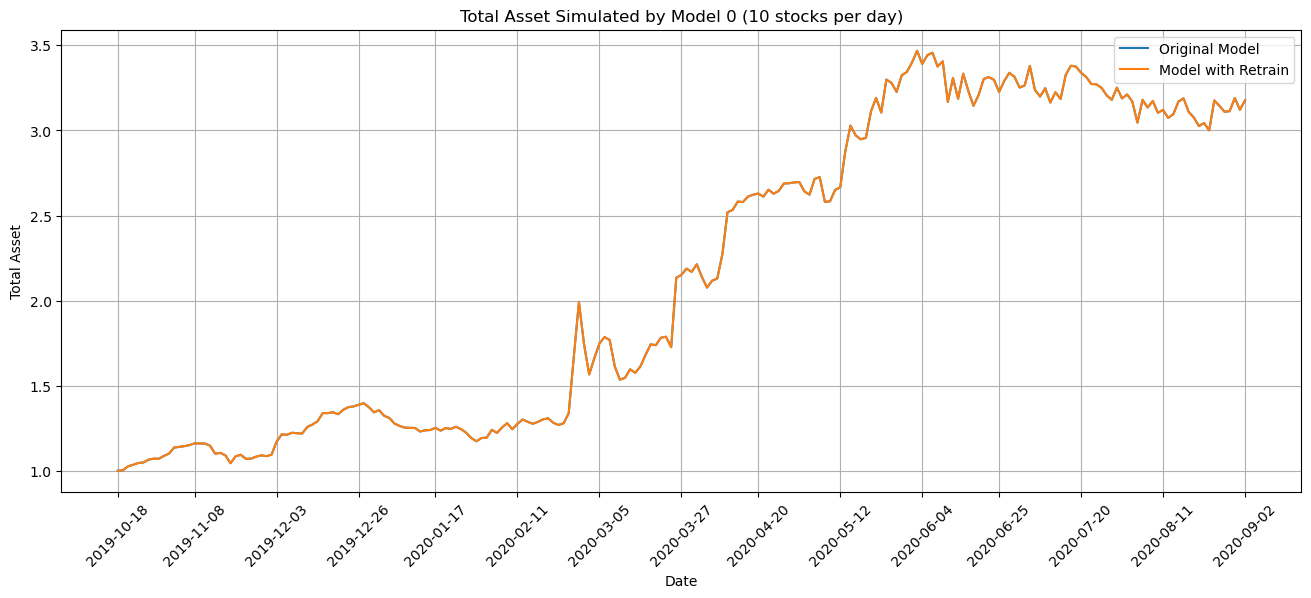

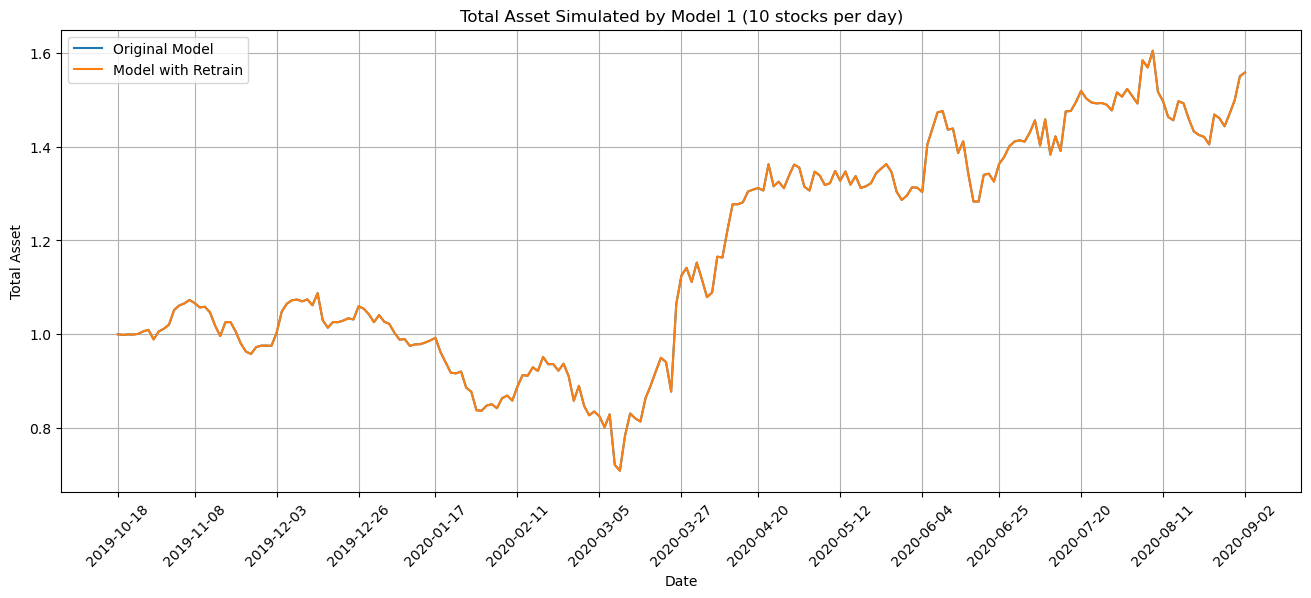

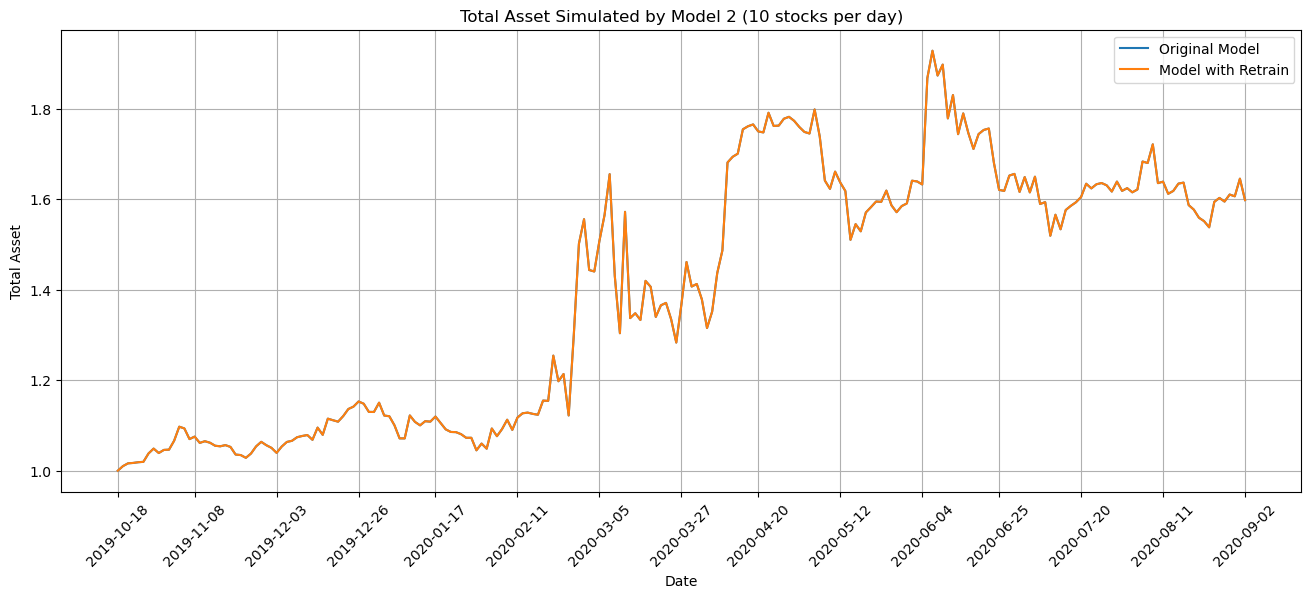

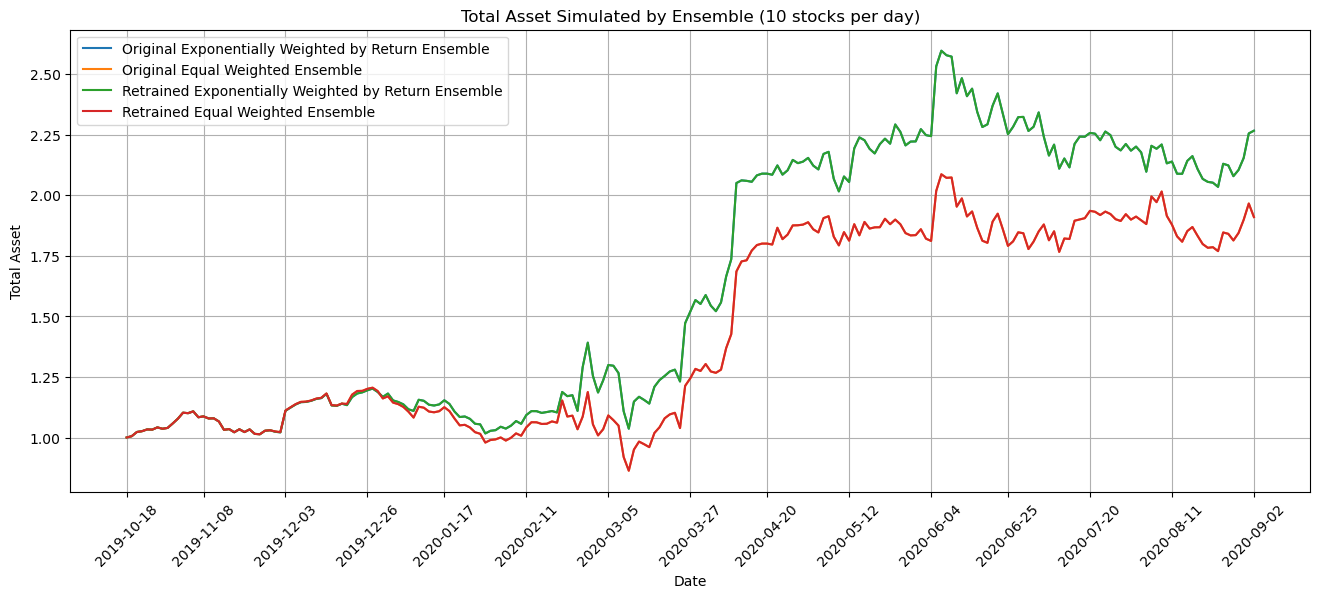

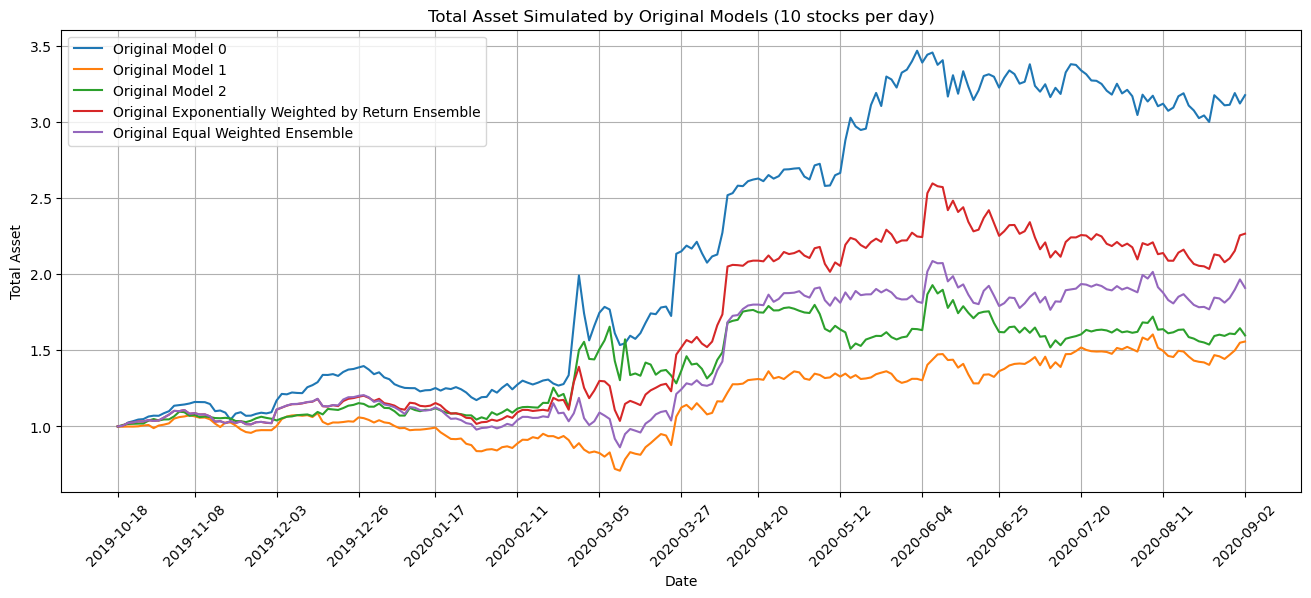

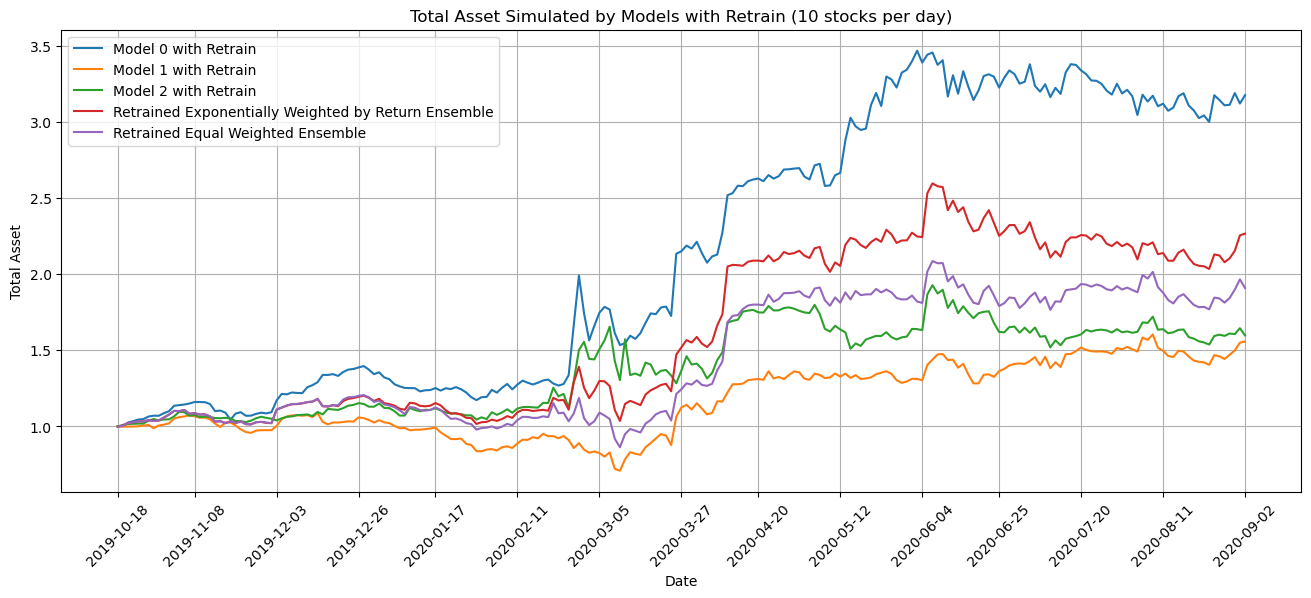

Iteration 12 of 58
Standardization data are from 2019-11-14 to 2020-04-08
Training data are from 2020-04-09 to 2020-08-31
Testing data are from 2020-08-05 to 2020-09-29
Training data have shape (185895, 20, 30), (185895,)
Testing data have shape (45900, 20, 30), (45900,)
Weight of original model 0 is 0.42695364548797515
Weight of retrained model 0 is 0.42695364548797515
Weight of original model 1 is 0.38030894739469717
Weight of retrained model 1 is 0.38030894739469717
Weight of original model 2 is 0.1927374071173276
Weight of retrained model 2 is 0.1927374071173276
top_stocks by original model 0 to buy on 2020-09-02 are ['ANF', 'CHEF', 'COLM', 'DNLI', 'MGM', 'BYON', 'KNDI', 'KODK', 'MARA', 'GEVO']
top_stocks by retrained model 0 to buy on 2020-09-02 are ['ANF', 'CHEF', 'COLM', 'DNLI', 'MGM', 'BYON', 'KNDI', 'KODK', 'MARA', 'GEVO']
Total asset on 2020-09-03 will be 3.0717445744026204
It should be the same as 3.0717445744026355
Total asset on 2020-09-03 will be 3.0717445744026204
It sho

top_stocks by original model 0 to buy on 2020-09-08 are ['AZPN', 'ALT', 'IBN', 'PII', 'MSTR', 'ICUI', 'KNDI', 'KODK', 'MCRB', 'MARA']
top_stocks by retrained model 0 to buy on 2020-09-08 are ['AZPN', 'ALT', 'IBN', 'PII', 'MSTR', 'ICUI', 'KNDI', 'KODK', 'MCRB', 'MARA']
Total asset on 2020-09-09 will be 3.002581574431688
It should be the same as 3.0025815744317037
Total asset on 2020-09-09 will be 3.002581574431688
It should be the same as 3.0025815744317037
Total asset on 2020-09-09 will be 3.002581574431688
It should be the same as 3.0025815744317037
top_stocks by original model 1 to buy on 2020-09-08 are ['SAP', 'MOMO', 'ICUI', 'ARKQ', 'QCLN', 'SMAR', 'BABA', 'MVIS', 'KODK', 'ZUO']
top_stocks by retrained model 1 to buy on 2020-09-08 are ['SAP', 'MOMO', 'ICUI', 'ARKQ', 'QCLN', 'SMAR', 'BABA', 'MVIS', 'KODK', 'ZUO']
Total asset on 2020-09-09 will be 1.5016685316645006
It should be the same as 1.5016685316645035
Total asset on 2020-09-09 will be 1.5016685316645006
It should be the same 

top_stocks by original model 1 to buy on 2020-09-11 are ['JBL', 'SOXL', 'DAY', 'HOMB', 'FI', 'AAOI', 'MARA', 'KNDI', 'MCRB', 'KODK']
top_stocks by retrained model 1 to buy on 2020-09-11 are ['JBL', 'SOXL', 'DAY', 'HOMB', 'FI', 'AAOI', 'MARA', 'KNDI', 'MCRB', 'KODK']
Total asset on 2020-09-14 will be 1.528217482354057
It should be the same as 1.52821748235406
Total asset on 2020-09-14 will be 1.528217482354057
It should be the same as 1.52821748235406
Total asset on 2020-09-14 will be 1.528217482354057
It should be the same as 1.52821748235406
top_stocks by original model 2 to buy on 2020-09-11 are ['ZUO', 'NBR', 'ODP', 'CSL', 'BOH', 'HLIT', 'HOMB', 'TV', 'QDEL', 'KODK']
top_stocks by retrained model 2 to buy on 2020-09-11 are ['ZUO', 'NBR', 'ODP', 'CSL', 'BOH', 'HLIT', 'HOMB', 'TV', 'QDEL', 'KODK']
Total asset on 2020-09-14 will be 1.544501019720981
It should be the same as 1.5445010197209859
Total asset on 2020-09-14 will be 1.544501019720981
It should be the same as 1.544501019720985

Total asset on 2020-09-17 will be 1.607890762667896
It should be the same as 1.607890762667899
Total asset on 2020-09-17 will be 1.607890762667896
It should be the same as 1.607890762667899
Total asset on 2020-09-17 will be 1.607890762667896
It should be the same as 1.607890762667899
top_stocks by original model 2 to buy on 2020-09-16 are ['CZR', 'CINF', 'BKU', 'TNL', 'RTX', 'HWM', 'BKE', 'SBH', 'WYNN', 'LVS']
top_stocks by retrained model 2 to buy on 2020-09-16 are ['CZR', 'CINF', 'BKU', 'TNL', 'RTX', 'HWM', 'BKE', 'SBH', 'WYNN', 'LVS']
Total asset on 2020-09-17 will be 1.528967094572204
It should be the same as 1.528967094572209
Total asset on 2020-09-17 will be 1.528967094572204
It should be the same as 1.528967094572209
Total asset on 2020-09-17 will be 1.528967094572204
It should be the same as 1.528967094572209
top_stocks by original return weighted ensemble to buy on 2020-09-16 are ['KBR', 'BKE', 'VRNT', 'AAL', 'WYNN', 'VRE', 'MARA', 'KNDI', 'BYON', 'LVS']
Total asset on 2020-09

Total asset on 2020-09-22 will be 1.4734303276380363
It should be the same as 1.4734303276380412
Total asset on 2020-09-22 will be 1.4734303276380363
It should be the same as 1.4734303276380412
Total asset on 2020-09-22 will be 1.4734303276380363
It should be the same as 1.4734303276380412
top_stocks by original return weighted ensemble to buy on 2020-09-21 are ['CWK', 'VNO', 'FXN', 'TTE', 'MCRB', 'KNDI', 'BYON', 'URBN', 'PGRE', 'EL']
Total asset on 2020-09-22 will be 2.2714086771371083
It should be the same as 2.271408677137115
top_stocks by original equal weighted ensemble to buy on 2020-09-21 are ['CBRE', 'STX', 'FXN', 'CWK', 'GRFS', 'VNO', 'TTE', 'PGRE', 'URBN', 'EL']
Total asset on 2020-09-22 will be 1.9126734665842373
It should be the same as 1.9126734665842402
top_stocks by retrained return weighted ensemble to buy on 2020-09-21 are ['CWK', 'VNO', 'FXN', 'TTE', 'MCRB', 'KNDI', 'BYON', 'URBN', 'PGRE', 'EL']
Total asset on 2020-09-22 will be 2.2714086771371083
It should be the sam

Total asset on 2020-09-25 will be 1.7995093440119376
It should be the same as 1.7995093440119416
top_stocks by original model 0 to buy on 2020-09-25 are ['ARKG', 'NVDA', 'MARA', 'ARKK', 'ARKQ', 'OIH', 'KNDI', 'BYON', 'MCRB', 'KODK']
top_stocks by retrained model 0 to buy on 2020-09-25 are ['ARKG', 'NVDA', 'MARA', 'ARKK', 'ARKQ', 'OIH', 'KNDI', 'BYON', 'MCRB', 'KODK']
Total asset on 2020-09-28 will be 3.296228915902763
It should be the same as 3.29622891590278
Total asset on 2020-09-28 will be 3.296228915902763
It should be the same as 3.29622891590278
Total asset on 2020-09-28 will be 3.296228915902763
It should be the same as 3.29622891590278
top_stocks by original model 1 to buy on 2020-09-25 are ['AR', 'SUNWQ', 'ECPG', 'GEVO', 'RILY', 'SRNE', 'KNDI', 'MCRB', 'MARA', 'KODK']
top_stocks by retrained model 1 to buy on 2020-09-25 are ['AR', 'SUNWQ', 'ECPG', 'GEVO', 'RILY', 'SRNE', 'KNDI', 'MCRB', 'MARA', 'KODK']
Total asset on 2020-09-28 will be 1.5285432186578503
It should be the same 

top_stocks by original model 1 to buy on 2020-09-30 are ['JBT', 'GES', 'ESRT', 'QDEL', 'PARR', 'MARA', 'KNDI', 'BYON', 'GEVO', 'MCRB']
top_stocks by retrained model 1 to buy on 2020-09-30 are ['JBT', 'GES', 'ESRT', 'QDEL', 'PARR', 'MARA', 'KNDI', 'BYON', 'GEVO', 'MCRB']
Total asset on 2020-10-01 will be 1.5902851339270827
It should be the same as 1.5902851339270856
Total asset on 2020-10-01 will be 1.5902851339270827
It should be the same as 1.5902851339270856
Total asset on 2020-10-01 will be 1.5902851339270827
It should be the same as 1.5902851339270856
top_stocks by original model 2 to buy on 2020-09-30 are ['BOX', 'CINF', 'IRT', 'BYON', 'GTES', 'FBP', 'JBT', 'GES', 'FUL', 'TFIN']
top_stocks by retrained model 2 to buy on 2020-09-30 are ['BOX', 'CINF', 'IRT', 'BYON', 'GTES', 'FBP', 'JBT', 'GES', 'FUL', 'TFIN']
Total asset on 2020-10-01 will be 1.485125075176989
It should be the same as 1.4851250751769947
Total asset on 2020-10-01 will be 1.485125075176989
It should be the same as 1.

Total asset on 2020-04-24 will be 1.655404332037502
It should be the same as 1.6554043320375025
Total asset on 2020-04-27 will be 1.7201814934672244
It should be the same as 1.720181493467225
Total asset on 2020-04-28 will be 1.7452475504808458
It should be the same as 1.7452475504808467
Total asset on 2020-04-29 will be 1.8747949107126909
It should be the same as 1.8747949107126913
Total asset on 2020-04-30 will be 2.044500840528233
It should be the same as 2.0445008405282334
Total asset on 2020-05-01 will be 2.0091554684357793
It should be the same as 2.0091554684357793
Total asset on 2020-05-04 will be 1.929857204143984
It should be the same as 1.9298572041439845
Total asset on 2020-05-05 will be 2.01561209557899
It should be the same as 2.0156120955789905
Total asset on 2020-05-06 will be 1.918804368358481
It should be the same as 1.918804368358482
Total asset on 2020-05-07 will be 1.8205041549557177
It should be the same as 1.8205041549557186
Total asset on 2020-05-08 will be 1.83

Epoch 10/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0520 - val_loss: 0.0464 - lr: 0.0050
Epoch 11/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0515 - val_loss: 0.0469 - lr: 0.0050
Epoch 12/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0514 - val_loss: 0.0462 - lr: 0.0050
Epoch 13/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0513 - val_loss: 0.0471 - lr: 0.0050
Epoch 14/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0508 - val_loss: 0.0465 - lr: 0.0050
Epoch 15/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0502 - val_loss: 0.0462 - lr: 0.0025
Epoch 16/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0500 - val_loss: 0.0471 - lr: 0.0025
Epoch 17/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0498 - val_loss: 0.0473 - lr: 0.0025
Epoch 18/500
146/146 [==============================] - 1s 5ms/step - loss: 0.05

Epoch 36/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0456 - val_loss: 0.0429 - lr: 0.0010
Epoch 36: early stopping
Train loss is 0.0376722477376461
Test loss is 0.03205251321196556
Total asset on 2020-07-09 will be 1.9115393738331525
It should be the same as 1.9115393738331543
Total asset on 2020-07-10 will be 1.8131921186607658
It should be the same as 1.8131921186607673
Total asset on 2020-07-13 will be 1.8873223028108015
It should be the same as 1.8873223028108035
Total asset on 2020-07-14 will be 1.850712494630619
It should be the same as 1.850712494630621
Total asset on 2020-07-15 will be 1.9302542956587927
It should be the same as 1.9302542956587951
Total asset on 2020-07-16 will be 1.938441374211204
It should be the same as 1.9384413742112068
Total asset on 2020-07-17 will be 1.9655211599399711
It should be the same as 1.9655211599399738
Total asset on 2020-07-20 will be 1.9809049834842065
It should be the same as 1.9809049834842096
Total asset on 2020-0

146/146 [==============================] - 1s 5ms/step - loss: 0.0344 - val_loss: 0.0231 - lr: 0.0100
Epoch 4/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0340 - val_loss: 0.0236 - lr: 0.0100
Epoch 5/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0334 - val_loss: 0.0231 - lr: 0.0100
Epoch 6/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0332 - val_loss: 0.0237 - lr: 0.0100
Epoch 7/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0330 - val_loss: 0.0235 - lr: 0.0100
Epoch 8/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0330 - val_loss: 0.0234 - lr: 0.0100
Epoch 9/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0322 - val_loss: 0.0231 - lr: 0.0050
Epoch 10/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0320 - val_loss: 0.0231 - lr: 0.0050
Epoch 11/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0319 - val_loss: 0.02

Epoch 19/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0272 - val_loss: 0.0308 - lr: 0.0025
Epoch 20/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0270 - val_loss: 0.0310 - lr: 0.0012
Epoch 21/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0270 - val_loss: 0.0306 - lr: 0.0012
Epoch 22/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0269 - val_loss: 0.0305 - lr: 0.0012
Epoch 23/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0269 - val_loss: 0.0310 - lr: 0.0012
Epoch 24/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0268 - val_loss: 0.0308 - lr: 0.0012
Epoch 24: early stopping
Train loss is 0.03378821164369583
Test loss is 0.03449738770723343
Total asset on 2020-10-02 will be 1.8864390730606921
It should be the same as 1.8864390730606964
Total asset on 2020-10-05 will be 1.9494302740799208
It should be the same as 1.9494302740799252
Total asset on 2020-10-0

Total asset on 2020-10-05 will be 1.994134603652188
It should be the same as 1.994134603652192
top_stocks by original model 0 to buy on 2020-10-05 are ['ZYME', 'TME', 'TTMI', 'GBIL', 'FXN', 'PETS', 'EURN', 'FAZ', 'FLR', 'AZN']
top_stocks by retrained model 0 to buy on 2020-10-05 are ['ZYME', 'TME', 'TTMI', 'GBIL', 'FXN', 'PETS', 'EURN', 'FAZ', 'FLR', 'AZN']
Total asset on 2020-10-06 will be 3.556163065898466
It should be the same as 3.5561630658984846
Total asset on 2020-10-06 will be 3.556163065898466
It should be the same as 3.5561630658984846
Total asset on 2020-10-06 will be 3.556163065898466
It should be the same as 3.5561630658984846
top_stocks by original model 1 to buy on 2020-10-05 are ['JD', 'BGS', 'TBT', 'NVO', 'XYLD', 'CLDX', 'TME', 'VRNT', 'INO', 'GBIL']
top_stocks by retrained model 1 to buy on 2020-10-05 are ['JD', 'BGS', 'TBT', 'NVO', 'XYLD', 'CLDX', 'TME', 'VRNT', 'INO', 'GBIL']
Total asset on 2020-10-06 will be 1.6236699895485251
It should be the same as 1.62366998954

Total asset on 2020-10-09 will be 1.6433619606610232
It should be the same as 1.6433619606610268
Total asset on 2020-10-09 will be 1.6433619606610232
It should be the same as 1.6433619606610268
Total asset on 2020-10-09 will be 1.6433619606610232
It should be the same as 1.6433619606610268
top_stocks by original model 2 to buy on 2020-10-08 are ['VAC', 'DIN', 'SNBR', 'EVRI', 'BYD', 'PLAY', 'MLCO', 'CRI', 'SONO', 'GNW']
top_stocks by retrained model 2 to buy on 2020-10-08 are ['RIO', 'MLCO', 'SONO', 'CX', 'GFF', 'TECK', 'VTLE', 'GBIL', 'VRE', 'SUNWQ']
Total asset on 2020-10-09 will be 1.5748248634880226
It should be the same as 1.5748248634880277
Total asset on 2020-10-09 will be 1.5860279805222375
It should be the same as 1.5860279805222426
top_stocks by original return weighted ensemble to buy on 2020-10-08 are ['EXTR', 'BYD', 'MTCH', 'GOOGL', 'DIN', 'GBIL', 'GOOG', 'GNW', 'SONO', 'MLCO']
Total asset on 2020-10-09 will be 2.604999297163137
It should be the same as 2.604999297163146
to

Total asset on 2020-10-14 will be 2.1042630157379474
It should be the same as 2.104263015737952
top_stocks by original model 0 to buy on 2020-10-14 are ['QCLN', 'SBH', 'SEDG', 'SQQQ', 'TAN', 'GLNG', 'CWEN', 'MRCY', 'PBW', 'ICLN']
top_stocks by retrained model 0 to buy on 2020-10-14 are ['QCLN', 'SBH', 'SEDG', 'SQQQ', 'TAN', 'GLNG', 'CWEN', 'MRCY', 'PBW', 'ICLN']
Total asset on 2020-10-15 will be 3.751502611322389
It should be the same as 3.7515026113224086
Total asset on 2020-10-15 will be 3.751502611322389
It should be the same as 3.7515026113224086
Total asset on 2020-10-15 will be 3.751502611322389
It should be the same as 3.7515026113224086
top_stocks by original model 1 to buy on 2020-10-14 are ['KBH', 'BJRI', 'TOL', 'SAP', 'NSTGQ', 'MRCY', 'VRTS', 'LEN', 'TME', 'BWXT']
top_stocks by retrained model 1 to buy on 2020-10-14 are ['KBH', 'BJRI', 'TOL', 'SAP', 'NSTGQ', 'MRCY', 'VRTS', 'LEN', 'TME', 'BWXT']
Total asset on 2020-10-15 will be 1.670289795021821
It should be the same as 1.6

top_stocks by original model 1 to buy on 2020-10-19 are ['BTI', 'MASI', 'WDAY', 'YANG', 'MBUU', 'PAR', 'CABO', 'HTHT', 'HELE', 'NVS']
top_stocks by retrained model 1 to buy on 2020-10-19 are ['BTI', 'MASI', 'WDAY', 'YANG', 'MBUU', 'PAR', 'CABO', 'HTHT', 'HELE', 'NVS']
Total asset on 2020-10-20 will be 1.7013726307983004
It should be the same as 1.7013726307983033
Total asset on 2020-10-20 will be 1.7013726307983004
It should be the same as 1.7013726307983033
Total asset on 2020-10-20 will be 1.7013726307983004
It should be the same as 1.7013726307983033
top_stocks by original model 2 to buy on 2020-10-19 are ['HELE', 'EQC', 'WDAY', 'BB', 'TECL', 'META', 'AAPL', 'TQQQ', 'VRTX', 'ORA']
top_stocks by retrained model 2 to buy on 2020-10-19 are ['WDAY', 'EQC', 'META', 'TECL', 'NEOG', 'PTLC', 'VTNR', 'VRTX', 'ORA', 'ILMN']
Total asset on 2020-10-20 will be 1.580880087575845
It should be the same as 1.5808800875758513
Total asset on 2020-10-20 will be 1.6270165515317754
It should be the same 

Total asset on 2020-10-23 will be 1.6037169672285816
It should be the same as 1.6037169672285876
Total asset on 2020-10-23 will be 1.6800846750053586
It should be the same as 1.6800846750053637
top_stocks by original return weighted ensemble to buy on 2020-10-22 are ['JBL', 'VYX', 'PHG', 'TDC', 'LYG', 'ALSN', 'KEY', 'ESRT', 'IART', 'ALLE']
Total asset on 2020-10-23 will be 2.7167208253498067
It should be the same as 2.7167208253498174
top_stocks by original equal weighted ensemble to buy on 2020-10-22 are ['PPBI', 'VYX', 'TDC', 'KEY', 'PHG', 'LYG', 'ALSN', 'ESRT', 'IART', 'ALLE']
Total asset on 2020-10-23 will be 2.2153040381622566
It should be the same as 2.215304038162263
top_stocks by retrained return weighted ensemble to buy on 2020-10-22 are ['ZION', 'LABU', 'KEY', 'GPK', 'IART', 'VYX', 'PPBI', 'ESRT', 'TCOM', 'ALLE']
Total asset on 2020-10-23 will be 2.725925756838909
It should be the same as 2.725925756838918
top_stocks by retrained equal weighted ensemble to buy on 2020-10-22 a

Total asset on 2020-10-28 will be 2.1040430579068965
It should be the same as 2.104043057906902
top_stocks by original model 0 to buy on 2020-10-28 are ['PVH', 'VFC', 'JWN', 'OMC', 'JBL', 'RL', 'MHK', 'SBH', 'GLNG', 'ODP']
top_stocks by retrained model 0 to buy on 2020-10-28 are ['PVH', 'VFC', 'JWN', 'OMC', 'JBL', 'RL', 'MHK', 'SBH', 'GLNG', 'ODP']
Total asset on 2020-10-29 will be 3.528323443905498
It should be the same as 3.528323443905517
Total asset on 2020-10-29 will be 3.528323443905498
It should be the same as 3.528323443905517
Total asset on 2020-10-29 will be 3.528323443905498
It should be the same as 3.528323443905517
top_stocks by original model 1 to buy on 2020-10-28 are ['MAN', 'SYY', 'AVB', 'VOD', 'COLM', 'IGT', 'SSD', 'CW', 'ODP', 'SAP']
top_stocks by retrained model 1 to buy on 2020-10-28 are ['MAN', 'SYY', 'AVB', 'VOD', 'COLM', 'IGT', 'SSD', 'CW', 'ODP', 'SAP']
Total asset on 2020-10-29 will be 1.6728529916088537
It should be the same as 1.672852991608857
Total asset o

top_stocks by original model 0 to buy on 2020-10-29 are ['INTC', 'HELE', 'BOIL', 'GLPG', 'NYT', 'FAF', 'GRFS', 'MRIN', 'VTNR', 'GBIL']
top_stocks by retrained model 0 to buy on 2020-10-29 are ['INTC', 'HELE', 'BOIL', 'GLPG', 'NYT', 'FAF', 'GRFS', 'MRIN', 'VTNR', 'GBIL']
Total asset on 2020-10-30 will be 3.5481468395936635
It should be the same as 3.548146839593683
Total asset on 2020-10-30 will be 3.5481468395936635
It should be the same as 3.548146839593683
Total asset on 2020-10-30 will be 3.5481468395936635
It should be the same as 3.548146839593683
top_stocks by original model 1 to buy on 2020-10-29 are ['FMS', 'ABEV', 'TWOU', 'CLX', 'DNN', 'KMB', 'QLYS', 'NYT', 'LOPE', 'LRN']
top_stocks by retrained model 1 to buy on 2020-10-29 are ['FMS', 'ABEV', 'TWOU', 'CLX', 'DNN', 'KMB', 'QLYS', 'NYT', 'LOPE', 'LRN']
Total asset on 2020-10-30 will be 1.6601725996162475
It should be the same as 1.660172599616251
Total asset on 2020-10-30 will be 1.6601725996162475
It should be the same as 1.66

Total asset on 2020-11-04 will be 3.631701402888721
It should be the same as 3.6317014028887398
Total asset on 2020-11-04 will be 3.631701402888721
It should be the same as 3.6317014028887398
Total asset on 2020-11-04 will be 3.631701402888721
It should be the same as 3.6317014028887398
top_stocks by original model 1 to buy on 2020-11-03 are ['DDS', 'SIMO', 'ITGR', 'SSD', 'TFX', 'AMKR', 'GOOGL', 'ILMN', 'GOOG', 'GMED']
top_stocks by retrained model 1 to buy on 2020-11-03 are ['DDS', 'SIMO', 'ITGR', 'SSD', 'TFX', 'AMKR', 'GOOGL', 'ILMN', 'GOOG', 'GMED']
Total asset on 2020-11-04 will be 1.7378623681121887
It should be the same as 1.737862368112192
Total asset on 2020-11-04 will be 1.7378623681121887
It should be the same as 1.737862368112192
Total asset on 2020-11-04 will be 1.7378623681121887
It should be the same as 1.737862368112192
top_stocks by original model 2 to buy on 2020-11-03 are ['CNMD', 'HLIT', 'GMED', 'AXTA', 'DBA', 'GRPN', 'GWRE', 'SUNWQ', 'GEVO', 'KODK']
top_stocks by re

top_stocks by original model 1 to buy on 2020-11-06 are ['SPOT', 'QLD', 'ADBE', 'ADUS', 'AZO', 'CENX', 'META', 'ARKW', 'ANGI', 'LBRT']
top_stocks by retrained model 1 to buy on 2020-11-06 are ['SPOT', 'QLD', 'ADBE', 'ADUS', 'AZO', 'CENX', 'META', 'ARKW', 'ANGI', 'LBRT']
Total asset on 2020-11-09 will be 1.9484202170337273
It should be the same as 1.9484202170337304
Total asset on 2020-11-09 will be 1.9484202170337273
It should be the same as 1.9484202170337304
Total asset on 2020-11-09 will be 1.9484202170337273
It should be the same as 1.9484202170337304
top_stocks by original model 2 to buy on 2020-11-06 are ['PDBC', 'IGF', 'EFX', 'MSI', 'DBO', 'TQQQ', 'LBRT', 'SUNWQ', 'GEVO', 'KODK']
top_stocks by retrained model 2 to buy on 2020-11-06 are ['ANSS', 'TECK', 'TX', 'AEM', 'BEP', 'KHC', 'FTV', 'PNM', 'ANGI', 'LBRT']
Total asset on 2020-11-09 will be 1.6644231400282912
It should be the same as 1.664423140028297
Total asset on 2020-11-09 will be 1.7360095079996873
It should be the same as

top_stocks by original model 2 to buy on 2020-11-11 are ['NYCB', 'QID', 'JKS', 'SQQQ', 'SENS', 'BIL', 'UUP', 'SUNWQ', 'GEVO', 'KODK']
top_stocks by retrained model 2 to buy on 2020-11-11 are ['UHS', 'GRPN', 'TECS', 'BIL', 'QID', 'PSQ', 'NYCB', 'SQQQ', 'NOK', 'KNX']
Total asset on 2020-11-12 will be 1.66858412712411
It should be the same as 1.668584127124116
Total asset on 2020-11-12 will be 1.708596546895796
It should be the same as 1.7085965468958013
Total asset on 2020-11-12 will be 2.197168442550337
It should be the same as 2.1971684425503435
top_stocks by original return weighted ensemble to buy on 2020-11-11 are ['UBSI', 'CMA', 'BBVA', 'SENS', 'GATX', 'UUP', 'RGR', 'ZION', 'BIL', 'NYCB']
Total asset on 2020-11-12 will be 2.9027315920217225
It should be the same as 2.9027315920217345
top_stocks by original equal weighted ensemble to buy on 2020-11-11 are ['SQQQ', 'UBSI', 'BBVA', 'RGR', 'GATX', 'SENS', 'ZION', 'UUP', 'BIL', 'NYCB']
Total asset on 2020-11-12 will be 2.398875421724151

Total asset on 2020-11-17 will be 2.413377742579007
It should be the same as 2.413377742579015
top_stocks by original model 0 to buy on 2020-11-17 are ['NEM', 'AGI', 'WPM', 'PAAS', 'BTG', 'FNV', 'NUGT', 'CLDX', 'SILJ', 'SSRM']
top_stocks by retrained model 0 to buy on 2020-11-17 are ['NEM', 'AGI', 'WPM', 'PAAS', 'BTG', 'FNV', 'NUGT', 'CLDX', 'SILJ', 'SSRM']
Total asset on 2020-11-18 will be 3.8986086659877737
It should be the same as 3.898608665987793
Total asset on 2020-11-18 will be 3.8986086659877737
It should be the same as 3.898608665987793
Total asset on 2020-11-18 will be 3.8986086659877737
It should be the same as 3.898608665987793
top_stocks by original model 1 to buy on 2020-11-17 are ['SILJ', 'AGI', 'GOLD', 'WPM', 'BAP', 'BCRX', 'QGEN', 'FNV', 'VIAV', 'SSRM']
top_stocks by retrained model 1 to buy on 2020-11-17 are ['SILJ', 'AGI', 'GOLD', 'WPM', 'BAP', 'BCRX', 'QGEN', 'FNV', 'VIAV', 'SSRM']
Total asset on 2020-11-18 will be 2.01192686959655
It should be the same as 2.0119268

top_stocks by original model 1 to buy on 2020-11-20 are ['CNNE', 'HLI', 'OSIS', 'DOG', 'WGO', 'BOIL', 'UNG', 'GFF', 'NFLX', 'CINF']
top_stocks by retrained model 1 to buy on 2020-11-20 are ['CNNE', 'HLI', 'OSIS', 'DOG', 'WGO', 'BOIL', 'UNG', 'GFF', 'NFLX', 'CINF']
Total asset on 2020-11-23 will be 1.997286998214505
It should be the same as 1.9972869982145076
Total asset on 2020-11-23 will be 1.997286998214505
It should be the same as 1.9972869982145076
Total asset on 2020-11-23 will be 1.997286998214505
It should be the same as 1.9972869982145076
top_stocks by original model 2 to buy on 2020-11-20 are ['AZN', 'SOXS', 'GFF', 'CENN', 'DOG', 'UNG', 'BOIL', 'SUNWQ', 'GEVO', 'KODK']
top_stocks by retrained model 2 to buy on 2020-11-20 are ['HUYA', 'SOXS', 'GFF', 'FAF', 'AQN', 'UNP', 'NYT', 'BOIL', 'AZN', 'UNG']
Total asset on 2020-11-23 will be 1.978086980214596
It should be the same as 1.978086980214602
Total asset on 2020-11-23 will be 1.811642934593273
It should be the same as 1.81164293

top_stocks by original model 2 to buy on 2020-11-25 are ['BDX', 'JNUG', 'BAX', 'TREE', 'FE', 'PRGO', 'ORA', 'SUNWQ', 'GEVO', 'KODK']
top_stocks by retrained model 2 to buy on 2020-11-25 are ['TXRH', 'VRNS', 'SCI', 'NTCT', 'TREE', 'ALGT', 'ZWS', 'SAP', 'VVV', 'GMED']
Total asset on 2020-11-27 will be 2.111436178678765
It should be the same as 2.11143617867877
Total asset on 2020-11-27 will be 1.818628765621639
It should be the same as 1.8186287656216447
Total asset on 2020-11-27 will be 2.338664291343574
It should be the same as 2.3386642913435836
top_stocks by original return weighted ensemble to buy on 2020-11-25 are ['NYCB', 'SMFG', 'GRFS', 'MUFG', 'FE', 'TREE', 'BAX', 'PRGO', 'GMED', 'ORA']
Total asset on 2020-11-27 will be 3.2661145140142085
It should be the same as 3.2661145140142214
top_stocks by original equal weighted ensemble to buy on 2020-11-25 are ['NYCB', 'SMFG', 'GRFS', 'MUFG', 'TREE', 'FE', 'BAX', 'GMED', 'PRGO', 'ORA']
Total asset on 2020-11-27 will be 2.698015132067396

Total asset on 2020-11-30 will be 3.089943145279814
It should be the same as 3.0899431452798254
top_stocks by retrained equal weighted ensemble to buy on 2020-11-27 are ['AGO', 'SMFG', 'MUFG', 'CVI', 'XOM', 'MUR', 'VLO', 'SBLK', 'HAL', 'PBF']
Total asset on 2020-11-30 will be 2.4409378318893604
It should be the same as 2.4409378318893684
top_stocks by original model 0 to buy on 2020-11-30 are ['MNST', 'SKY', 'GEN', 'OGI', 'MSCI', 'BIO', 'PII', 'HELE', 'LCII', 'BCC']
top_stocks by retrained model 0 to buy on 2020-11-30 are ['MNST', 'SKY', 'GEN', 'OGI', 'MSCI', 'BIO', 'PII', 'HELE', 'LCII', 'BCC']
Total asset on 2020-12-01 will be 4.135570396234557
It should be the same as 4.135570396234575
Total asset on 2020-12-01 will be 4.135570396234557
It should be the same as 4.135570396234575
Total asset on 2020-12-01 will be 4.135570396234557
It should be the same as 4.135570396234575
top_stocks by original model 1 to buy on 2020-11-30 are ['HELE', 'NWE', 'VRE', 'GOLD', 'AGO', 'SLV', 'PII', 'PSL

top_stocks by original model 0 to buy on 2020-12-03 are ['FMS', 'NOG', 'CSGS', 'MPC', 'PBF', 'SNN', 'PAYC', 'DDS', 'ARVN', 'DK']
top_stocks by retrained model 0 to buy on 2020-12-03 are ['FMS', 'NOG', 'CSGS', 'MPC', 'PBF', 'SNN', 'PAYC', 'DDS', 'ARVN', 'DK']
Total asset on 2020-12-04 will be 4.166904339397815
It should be the same as 4.166904339397836
Total asset on 2020-12-04 will be 4.166904339397815
It should be the same as 4.166904339397836
Total asset on 2020-12-04 will be 4.166904339397815
It should be the same as 4.166904339397836
top_stocks by original model 1 to buy on 2020-12-03 are ['AG', 'PHG', 'SSRM', 'IQ', 'WAT', 'BVN', 'SNN', 'DIN', 'TREE', 'GOGL']
top_stocks by retrained model 1 to buy on 2020-12-03 are ['AG', 'PHG', 'SSRM', 'IQ', 'WAT', 'BVN', 'SNN', 'DIN', 'TREE', 'GOGL']
Total asset on 2020-12-04 will be 2.067660639470541
It should be the same as 2.0676606394705446
Total asset on 2020-12-04 will be 2.067660639470541
It should be the same as 2.0676606394705446
Total a

top_stocks by original model 1 to buy on 2020-12-08 are ['SHV', 'BOIL', 'TFLO', 'EQX', 'NI', 'BTG', 'UL', 'SOXS', 'PSLV', 'DCPH']
top_stocks by retrained model 1 to buy on 2020-12-08 are ['SHV', 'BOIL', 'TFLO', 'EQX', 'NI', 'BTG', 'UL', 'SOXS', 'PSLV', 'DCPH']
Total asset on 2020-12-09 will be 2.0721631502203666
It should be the same as 2.072163150220371
Total asset on 2020-12-09 will be 2.0721631502203666
It should be the same as 2.072163150220371
Total asset on 2020-12-09 will be 2.0721631502203666
It should be the same as 2.072163150220371
top_stocks by original model 2 to buy on 2020-12-08 are ['SDS', 'JNUG', 'PSA', 'WB', 'SPXU', 'SPXS', 'BVN', 'SQQQ', 'CLDX', 'SOXS']
top_stocks by retrained model 2 to buy on 2020-12-08 are ['TWM', 'SPXS', 'QID', 'SPXU', 'PSQ', 'SHV', 'TECS', 'SQQQ', 'SOXS', 'KODK']
Total asset on 2020-12-09 will be 2.0790050535646296
It should be the same as 2.0790050535646354
Total asset on 2020-12-09 will be 1.7878068334849166
It should be the same as 1.78780683

top_stocks by original model 2 to buy on 2020-12-11 are ['AMKR', 'RDN', 'COMM', 'SBH', 'HDB', 'GOGL', 'VRRM', 'NMIH', 'TGNA', 'QD']
top_stocks by retrained model 2 to buy on 2020-12-11 are ['VRRM', 'HAS', 'TGNA', 'TAL', 'LITE', 'MCRB', 'HUBG', 'TDC', 'VIAV', 'KN']
Total asset on 2020-12-14 will be 2.055204013228381
It should be the same as 2.0552040132283875
Total asset on 2020-12-14 will be 1.7176102958583144
It should be the same as 1.7176102958583201
Total asset on 2020-12-14 will be 2.2087596662394486
It should be the same as 2.208759666239456
top_stocks by original return weighted ensemble to buy on 2020-12-11 are ['UBS', 'KOLD', 'YEXT', 'LITE', 'VRRM', 'VIAV', 'LCII', 'HAS', 'ADUS', 'TGNA']
Total asset on 2020-12-14 will be 3.229320604437423
It should be the same as 3.2293206044374383
top_stocks by original equal weighted ensemble to buy on 2020-12-11 are ['YEXT', 'AVAV', 'KOLD', 'LITE', 'VIAV', 'LCII', 'VRRM', 'HAS', 'ADUS', 'TGNA']
Total asset on 2020-12-14 will be 2.6631948317

top_stocks by original model 0 to buy on 2020-12-17 are ['MSM', 'GOVT', 'TMF', 'OLLI', 'ERY', 'FWRD', 'TLH', 'EXPRQ', 'AIV', 'AUPH']
top_stocks by retrained model 0 to buy on 2020-12-17 are ['MSM', 'GOVT', 'TMF', 'OLLI', 'ERY', 'FWRD', 'TLH', 'EXPRQ', 'AIV', 'AUPH']
Total asset on 2020-12-18 will be 3.840238368305323
It should be the same as 3.8402383683053456
Total asset on 2020-12-18 will be 3.840238368305323
It should be the same as 3.8402383683053456
Total asset on 2020-12-18 will be 3.840238368305323
It should be the same as 3.8402383683053456
top_stocks by original model 1 to buy on 2020-12-17 are ['SCHO', 'MUSA', 'MDGL', 'GOVT', 'UTHR', 'TLH', 'GNW', 'YUMC', 'CHRS', 'PEN']
top_stocks by retrained model 1 to buy on 2020-12-17 are ['SCHO', 'MUSA', 'MDGL', 'GOVT', 'UTHR', 'TLH', 'GNW', 'YUMC', 'CHRS', 'PEN']
Total asset on 2020-12-18 will be 2.1294945887126726
It should be the same as 2.129494588712678
Total asset on 2020-12-18 will be 2.1294945887126726
It should be the same as 2.

top_stocks by original model 1 to buy on 2020-12-22 are ['BJRI', 'SBH', 'TDC', 'DBO', 'MKC', 'NDSN', 'HRB', 'XELA', 'ABBV', 'NOG']
top_stocks by retrained model 1 to buy on 2020-12-22 are ['BJRI', 'SBH', 'TDC', 'DBO', 'MKC', 'NDSN', 'HRB', 'XELA', 'ABBV', 'NOG']
Total asset on 2020-12-23 will be 2.1511763511656494
It should be the same as 2.1511763511656565
Total asset on 2020-12-23 will be 2.1511763511656494
It should be the same as 2.1511763511656565
Total asset on 2020-12-23 will be 2.1511763511656494
It should be the same as 2.1511763511656565
top_stocks by original model 2 to buy on 2020-12-22 are ['NDSN', 'CXW', 'SIX', 'EHTH', 'TEVA', 'BANC', 'BKD', 'TUP', 'NOG', 'NIO']
top_stocks by retrained model 2 to buy on 2020-12-22 are ['WTI', 'DK', 'CWEB', 'EQNR', 'BJRI', 'XOM', 'NIO', 'TUP', 'KODK', 'NOG']
Total asset on 2020-12-23 will be 1.9836770097504255
It should be the same as 1.98367700975043
Total asset on 2020-12-23 will be 1.758521097655042
It should be the same as 1.7585210976

Iteration 16 of 58
Standardization data are from 2020-03-12 to 2020-08-03
Training data are from 2020-08-04 to 2020-12-23
Testing data are from 2020-11-27 to 2021-01-25
Training data have shape (185895, 20, 30), (185895,)
Testing data have shape (45900, 20, 30), (45900,)
Training model 2 using seed 123
Epoch 1/500
146/146 [==============================] - 1s 7ms/step - loss: 0.0278 - val_loss: 0.0249 - lr: 0.0100
Epoch 2/500
146/146 [==============================] - 1s 6ms/step - loss: 0.0271 - val_loss: 0.0257 - lr: 0.0100
Epoch 3/500
146/146 [==============================] - 1s 6ms/step - loss: 0.0268 - val_loss: 0.0258 - lr: 0.0100
Epoch 4/500
146/146 [==============================] - 1s 6ms/step - loss: 0.0266 - val_loss: 0.0256 - lr: 0.0100
Epoch 5/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0265 - val_loss: 0.0257 - lr: 0.0100
Epoch 6/500
146/146 [==============================] - 1s 6ms/step - loss: 0.0264 - val_loss: 0.0259 - lr: 0.0100
Epoch 7/500


top_stocks by original model 0 to buy on 2020-12-30 are ['UCTT', 'FCEL', 'JKS', 'NVMI', 'UI', 'CIEN', 'CENX', 'NOK', 'DBX', 'PACB']
top_stocks by retrained model 0 to buy on 2020-12-30 are ['UCTT', 'FCEL', 'JKS', 'NVMI', 'UI', 'CIEN', 'CENX', 'NOK', 'DBX', 'PACB']
Total asset on 2020-12-31 will be 3.6519211565891485
It should be the same as 3.6519211565891734
Total asset on 2020-12-31 will be 3.6519211565891485
It should be the same as 3.6519211565891734
Total asset on 2020-12-31 will be 3.6519211565891485
It should be the same as 3.6519211565891734
top_stocks by original model 1 to buy on 2020-12-30 are ['CLNE', 'JKS', 'FRHC', 'EDIT', 'APPS', 'MARA', 'FCEL', 'RIOT', 'SENS', 'PACB']
top_stocks by retrained model 1 to buy on 2020-12-30 are ['CLNE', 'JKS', 'FRHC', 'EDIT', 'APPS', 'MARA', 'FCEL', 'RIOT', 'SENS', 'PACB']
Total asset on 2020-12-31 will be 2.0017738790978896
It should be the same as 2.0017738790978985
Total asset on 2020-12-31 will be 2.0017738790978896
It should be the same

top_stocks by original model 1 to buy on 2021-01-05 are ['FCEL', 'APPN', 'GRWG', 'EXPI', 'BLNK', 'APPS', 'RIOT', 'TWST', 'PACB', 'AIV']
top_stocks by retrained model 1 to buy on 2021-01-05 are ['FCEL', 'APPN', 'GRWG', 'EXPI', 'BLNK', 'APPS', 'RIOT', 'TWST', 'PACB', 'AIV']
Total asset on 2021-01-06 will be 2.0460779516976304
It should be the same as 2.0460779516976393
Total asset on 2021-01-06 will be 2.0460779516976304
It should be the same as 2.0460779516976393
Total asset on 2021-01-06 will be 2.0460779516976304
It should be the same as 2.0460779516976393
top_stocks by original model 2 to buy on 2021-01-05 are ['EXPE', 'GRWG', 'BLNK', 'APPS', 'MARA', 'TWST', 'AIV', 'VGSH', 'PACB', 'MCRB']
top_stocks by retrained model 2 to buy on 2021-01-05 are ['TCOM', 'CVCO', 'NWE', 'AMX', 'AAT', 'QURE', 'EXPE', 'HMC', 'VGSH', 'MCRB']
Total asset on 2021-01-06 will be 1.9500475743970036
It should be the same as 1.950047574397011
Total asset on 2021-01-06 will be 2.029048535223972
It should be the s

top_stocks by original model 2 to buy on 2021-01-08 are ['MSTR', 'MARA', 'MCRB', 'NTLA', 'EDIT', 'TWST', 'RIOT', 'LAAC', 'DDD', 'PACB']
top_stocks by retrained model 2 to buy on 2021-01-08 are ['VOD', 'CVBF', 'CTAS', 'CRON', 'PATK', 'SUPN', 'KOLD', 'CVCO', 'AYI', 'PACB']
Total asset on 2021-01-11 will be 2.1357458669212894
It should be the same as 2.135745866921297
Total asset on 2021-01-11 will be 2.087848329467817
It should be the same as 2.0878483294678243
Total asset on 2021-01-11 will be 2.6848669866929664
It should be the same as 2.6848669866929726
top_stocks by original return weighted ensemble to buy on 2021-01-08 are ['MSTR', 'DDD', 'TDY', 'TWST', 'EDIT', 'FATE', 'NTLA', 'KOLD', 'RIOT', 'PACB']
Total asset on 2021-01-11 will be 3.334392479171374
It should be the same as 3.3343924791713886
top_stocks by original equal weighted ensemble to buy on 2021-01-08 are ['MSTR', 'EDIT', 'TWST', 'TDY', 'DDD', 'FATE', 'NTLA', 'KOLD', 'RIOT', 'PACB']
Total asset on 2021-01-11 will be 2.7207

top_stocks by original model 0 to buy on 2021-01-14 are ['WERN', 'TTEK', 'SILJ', 'CVBF', 'ABEV', 'MUR', 'IMO', 'SAH', 'DDD', 'WDFC']
top_stocks by retrained model 0 to buy on 2021-01-14 are ['WERN', 'TTEK', 'SILJ', 'CVBF', 'ABEV', 'MUR', 'IMO', 'SAH', 'DDD', 'WDFC']
Total asset on 2021-01-15 will be 3.7583837692883817
It should be the same as 3.7583837692884052
Total asset on 2021-01-15 will be 3.7583837692883817
It should be the same as 3.7583837692884052
Total asset on 2021-01-15 will be 3.7583837692883817
It should be the same as 3.7583837692884052
top_stocks by original model 1 to buy on 2021-01-14 are ['GRWG', 'APPS', 'NTLA', 'RIOT', 'EDIT', 'EXPI', 'DDD', 'PLUG', 'PACB', 'MARA']
top_stocks by retrained model 1 to buy on 2021-01-14 are ['GRWG', 'APPS', 'NTLA', 'RIOT', 'EDIT', 'EXPI', 'DDD', 'PLUG', 'PACB', 'MARA']
Total asset on 2021-01-15 will be 2.6083958319372917
It should be the same as 2.6083958319373015
Total asset on 2021-01-15 will be 2.6083958319372917
It should be the sa

Total asset on 2021-01-21 will be 2.630700245566734
It should be the same as 2.6307002455667448
Total asset on 2021-01-21 will be 2.630700245566734
It should be the same as 2.6307002455667448
top_stocks by original model 2 to buy on 2021-01-20 are ['RIOT', 'TWST', 'LAAC', 'BLNK', 'GME', 'SUNWQ', 'MARA', 'PLUG', 'APPS', 'PACB']
top_stocks by retrained model 2 to buy on 2021-01-20 are ['ASTH', 'IYM', 'TMHC', 'MCRB', 'DDD', 'SUNWQ', 'PLUG', 'IJK', 'GME', 'APPS']
Total asset on 2021-01-21 will be 2.3547915438342195
It should be the same as 2.354791543834226
Total asset on 2021-01-21 will be 2.282944651616484
It should be the same as 2.2829446516164915
Total asset on 2021-01-21 will be 2.935750955211737
It should be the same as 2.9357509552117436
top_stocks by original return weighted ensemble to buy on 2021-01-20 are ['FCEL', 'TUP', 'TWST', 'DDD', 'SUNWQ', 'MARA', 'APPS', 'GME', 'PLUG', 'PACB']
Total asset on 2021-01-21 will be 3.477657932340677
It should be the same as 3.4776579323406906


Total asset on 2021-01-26 will be 2.8370105065270725
It should be the same as 2.8370105065270796
Total asset on 2021-01-26 will be 2.3894635047405424
It should be the same as 2.3894635047405495
Total asset on 2021-01-26 will be 3.0727287941556587
It should be the same as 3.0727287941556662
top_stocks by original return weighted ensemble to buy on 2021-01-25 are ['FCEL', 'SUNWQ', 'MGNI', 'RIOT', 'SENS', 'PACB', 'GRFS', 'GME', 'DDD', 'PLUG']
Total asset on 2021-01-26 will be 4.200561335167284
It should be the same as 4.2005613351673
top_stocks by original equal weighted ensemble to buy on 2021-01-25 are ['FRHC', 'FCEL', 'MGNI', 'RIOT', 'SENS', 'PACB', 'GME', 'GRFS', 'DDD', 'PLUG']
Total asset on 2021-01-26 will be 3.251793423416889
It should be the same as 3.2517934234168973
top_stocks by retrained return weighted ensemble to buy on 2021-01-25 are ['FRHC', 'CPRX', 'GGAL', 'SUNWQ', 'NOG', 'MGNI', 'SENS', 'PLUG', 'GRFS', 'DDD']
Total asset on 2021-01-26 will be 3.7328766913110387
It should

146/146 [==============================] - 1s 5ms/step - loss: 0.0235 - val_loss: 0.0339 - lr: 0.0012
Epoch 22/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0235 - val_loss: 0.0343 - lr: 0.0012
Epoch 23/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0235 - val_loss: 0.0340 - lr: 0.0010
Epoch 23: early stopping
Weight of original model 0 is 0.07787821756516486
Weight of retrained model 0 is 0.09349517847936144
Weight of original model 1 is 0.6049711803148922
Weight of retrained model 1 is 0.7262863769459341
Weight of original model 2 is 0.31715060211994295
Weight of retrained model 2 is 0.18021844457470446
top_stocks by original model 0 to buy on 2021-01-27 are ['SMTC', 'STX', 'GRFS', 'DFEN', 'CIEN', 'ASML', 'PACB', 'SENS', 'BB', 'EXPRQ']
top_stocks by retrained model 0 to buy on 2021-01-27 are ['SMTC', 'STX', 'GRFS', 'DFEN', 'CIEN', 'ASML', 'PACB', 'SENS', 'BB', 'EXPRQ']
Total asset on 2021-01-28 will be 3.8736243003855715
It should be the s

Total asset on 2021-02-01 will be 3.340162683489158
It should be the same as 3.3401626834891753
top_stocks by original model 0 to buy on 2021-02-01 are ['VLO', 'VTNR', 'PDCO', 'YPF', 'SENS', 'BRFS', 'NOG', 'BB', 'EXPRQ', 'GME']
top_stocks by retrained model 0 to buy on 2021-02-01 are ['VLO', 'VTNR', 'PDCO', 'YPF', 'SENS', 'BRFS', 'NOG', 'BB', 'EXPRQ', 'GME']
Total asset on 2021-02-02 will be 3.604412776359763
It should be the same as 3.6044127763597884
Total asset on 2021-02-02 will be 3.604412776359763
It should be the same as 3.6044127763597884
Total asset on 2021-02-02 will be 3.604412776359763
It should be the same as 3.6044127763597884
top_stocks by original model 1 to buy on 2021-02-01 are ['PSX', 'DBX', 'LHX', 'VTRS', 'DINO', 'GTN', 'VLO', 'BB', 'EXPRQ', 'GME']
top_stocks by retrained model 1 to buy on 2021-02-01 are ['PSX', 'DBX', 'LHX', 'VTRS', 'DINO', 'GTN', 'VLO', 'BB', 'EXPRQ', 'GME']
Total asset on 2021-02-02 will be 4.914166452363215
It should be the same as 4.91416645236

top_stocks by original model 1 to buy on 2021-02-04 are ['ADI', 'STT', 'KWR', 'IXC', 'IMO', 'SU', 'SUNWQ', 'ERIC', 'VET', 'GME']
top_stocks by retrained model 1 to buy on 2021-02-04 are ['ADI', 'STT', 'KWR', 'IXC', 'IMO', 'SU', 'SUNWQ', 'ERIC', 'VET', 'GME']
Total asset on 2021-02-05 will be 4.553549646675192
It should be the same as 4.553549646675205
Total asset on 2021-02-05 will be 4.553549646675192
It should be the same as 4.553549646675205
Total asset on 2021-02-05 will be 4.553549646675192
It should be the same as 4.553549646675205
top_stocks by original model 2 to buy on 2021-02-04 are ['STT', 'CIEN', 'IXC', 'VET', 'FMC', 'IMO', 'BP', 'SU', 'TRMB', 'SUNWQ']
top_stocks by retrained model 2 to buy on 2021-02-04 are ['SU', 'BB', 'IMO', 'VTNR', 'FIZZ', 'VET', 'AMC', 'SUNWQ', 'EXPRQ', 'GME']
Total asset on 2021-02-05 will be 4.1561891509588875
It should be the same as 4.156189150958896
Total asset on 2021-02-05 will be 2.372152407174391
It should be the same as 2.372152407174397
Tota

Total asset on 2021-02-10 will be 2.359979504286745
It should be the same as 2.3599795042867506
Total asset on 2021-02-10 will be 3.0348138659797117
It should be the same as 3.0348138659797184
top_stocks by original return weighted ensemble to buy on 2021-02-09 are ['FICO', 'CPAY', 'FI', 'SXT', 'TV', 'NEU', 'WY', 'SONY', 'AVXL', 'SAVA']
Total asset on 2021-02-10 will be 5.476750849723443
It should be the same as 5.476750849723458
top_stocks by original equal weighted ensemble to buy on 2021-02-09 are ['SXT', 'FICO', 'CPAY', 'ELS', 'NEU', 'TV', 'SAVA', 'WY', 'SONY', 'AVXL']
Total asset on 2021-02-10 will be 2.7373082656622385
It should be the same as 2.737308265662247
top_stocks by retrained return weighted ensemble to buy on 2021-02-09 are ['CPAY', 'FI', 'INGR', 'WY', 'TV', 'SONY', 'NEU', 'EXPRQ', 'SAVA', 'AVXL']
Total asset on 2021-02-10 will be 3.9791138248961664
It should be the same as 3.9791138248961784
top_stocks by retrained equal weighted ensemble to buy on 2021-02-09 are ['APD

Total asset on 2021-02-16 will be 4.116484242442748
It should be the same as 4.116484242442761
top_stocks by retrained equal weighted ensemble to buy on 2021-02-12 are ['LABU', 'TTE', 'MVIS', 'MGNI', 'HCSG', 'MARA', 'AVXL', 'RIOT', 'BLOK', 'MSTR']
Total asset on 2021-02-16 will be 2.865438960782037
It should be the same as 2.8654389607820563
top_stocks by original model 0 to buy on 2021-02-16 are ['AG', 'BCRX', 'HL', 'DNN', 'MSTR', 'BLOK', 'SENS', 'EXPRQ', 'AVXL', 'GME']
top_stocks by retrained model 0 to buy on 2021-02-16 are ['AG', 'BCRX', 'HL', 'DNN', 'MSTR', 'BLOK', 'SENS', 'EXPRQ', 'AVXL', 'GME']
Total asset on 2021-02-17 will be 3.430146034893315
It should be the same as 3.4301460348933417
Total asset on 2021-02-17 will be 3.430146034893315
It should be the same as 3.4301460348933417
Total asset on 2021-02-17 will be 3.430146034893315
It should be the same as 3.4301460348933417
top_stocks by original model 1 to buy on 2021-02-16 are ['AVAV', 'BLOK', 'CDE', 'QCOM', 'YINN', 'VRNT',

Total asset on 2021-02-19 will be 2.819603912914608
It should be the same as 2.8196039129146278
top_stocks by original model 0 to buy on 2021-02-19 are ['IEF', 'TT', 'ALGN', 'ZOM', 'SIMO', 'WING', 'BP', 'MVIS', 'BLOK', 'SENS']
top_stocks by retrained model 0 to buy on 2021-02-19 are ['IEF', 'TT', 'ALGN', 'ZOM', 'SIMO', 'WING', 'BP', 'MVIS', 'BLOK', 'SENS']
Total asset on 2021-02-22 will be 3.3606964788362643
It should be the same as 3.3606964788362905
Total asset on 2021-02-22 will be 3.3606964788362643
It should be the same as 3.3606964788362905
Total asset on 2021-02-22 will be 3.3606964788362643
It should be the same as 3.3606964788362905
top_stocks by original model 1 to buy on 2021-02-19 are ['TLT', 'WCC', 'IEI', 'KOLD', 'ZOM', 'SAVA', 'SUNWQ', 'PACB', 'MVIS', 'AVXL']
top_stocks by retrained model 1 to buy on 2021-02-19 are ['TLT', 'WCC', 'IEI', 'KOLD', 'ZOM', 'SAVA', 'SUNWQ', 'PACB', 'MVIS', 'AVXL']
Total asset on 2021-02-22 will be 4.486581656148825
It should be the same as 4.48

Total asset on 2021-02-25 will be 3.257349945966863
It should be the same as 3.2573499459668906
Total asset on 2021-02-25 will be 3.257349945966863
It should be the same as 3.2573499459668906
Total asset on 2021-02-25 will be 3.257349945966863
It should be the same as 3.2573499459668906
top_stocks by original model 1 to buy on 2021-02-24 are ['BLOK', 'VIRT', 'GSAT', 'MARA', 'PACB', 'CBOE', 'MSTR', 'RIOT', 'SUNWQ', 'GME']
top_stocks by retrained model 1 to buy on 2021-02-24 are ['BLOK', 'VIRT', 'GSAT', 'MARA', 'PACB', 'CBOE', 'MSTR', 'RIOT', 'SUNWQ', 'GME']
Total asset on 2021-02-25 will be 5.653146582678663
It should be the same as 5.653146582678677
Total asset on 2021-02-25 will be 5.653146582678663
It should be the same as 5.653146582678677
Total asset on 2021-02-25 will be 5.653146582678663
It should be the same as 5.653146582678677
top_stocks by original model 2 to buy on 2021-02-24 are ['MARA', 'VIRT', 'ICLN', 'GSAT', 'ZOM', 'RIOT', 'MGNI', 'PACB', 'MSTR', 'SUNWQ']
top_stocks by r

top_stocks by original model 2 to buy on 2021-02-25 are ['CAG', 'BND', 'IVR', 'BIV', 'VTEB', 'PZA', 'AMC', 'AVXL', 'MRIN', 'GME']
top_stocks by retrained model 2 to buy on 2021-02-25 are ['AMC', 'FCEL', 'SENS', 'BB', 'MARA', 'GME', 'EXPRQ', 'DDD', 'RIOT', 'MRIN']
Total asset on 2021-02-26 will be 3.7006673909512684
It should be the same as 3.7006673909512733
Total asset on 2021-02-26 will be 1.9505841934107861
It should be the same as 1.9505841934107941
Total asset on 2021-02-26 will be 2.5083522743190136
It should be the same as 2.5083522743190185
top_stocks by original return weighted ensemble to buy on 2021-02-25 are ['NKTR', 'VTEB', 'BIV', 'EQIX', 'PBI', 'PZA', 'BAC.PL', 'ATO', 'AMC', 'GME']
Total asset on 2021-02-26 will be 5.234248233542104
It should be the same as 5.234248233542116
top_stocks by original equal weighted ensemble to buy on 2021-02-25 are ['BAC.PL', 'VTEB', 'BIV', 'BND', 'ATO', 'PBI', 'SCHZ', 'PZA', 'AMC', 'GME']
Total asset on 2021-02-26 will be 2.6218512411947317

Total asset on 2021-03-03 will be 2.0227391489312065
It should be the same as 2.022739148931216
Total asset on 2021-03-03 will be 2.6011398850227367
It should be the same as 2.601139885022742
top_stocks by original return weighted ensemble to buy on 2021-03-02 are ['AMED', 'STIP', 'BTI', 'EGO', 'IBN', 'HL', 'VNO', 'WPM', 'PAAS', 'BP']
Total asset on 2021-03-03 will be 5.3403916681992225
It should be the same as 5.340391668199232
top_stocks by original equal weighted ensemble to buy on 2021-03-02 are ['PLD', 'HL', 'IBN', 'BTI', 'VNO', 'TRNO', 'PAAS', 'AMED', 'WPM', 'BP']
Total asset on 2021-03-03 will be 2.6693115977864714
It should be the same as 2.669311597786484
top_stocks by retrained return weighted ensemble to buy on 2021-03-02 are ['ANSS', 'AMED', 'STIP', 'VNO', 'IBN', 'BP', 'WPM', 'EGO', 'HL', 'PAAS']
Total asset on 2021-03-03 will be 4.466257465180695
It should be the same as 4.466257465180709
top_stocks by retrained equal weighted ensemble to buy on 2021-03-02 are ['EXK', 'EGO

top_stocks by original model 0 to buy on 2021-03-08 are ['SCHZ', 'MSTR', 'FIXD', 'GVI', 'BIV', 'IEI', 'SENS', 'SHY', 'RIOT', 'MGNI']
top_stocks by retrained model 0 to buy on 2021-03-08 are ['SCHZ', 'MSTR', 'FIXD', 'GVI', 'BIV', 'IEI', 'SENS', 'SHY', 'RIOT', 'MGNI']
Total asset on 2021-03-09 will be 2.9811296413878923
It should be the same as 2.981129641387918
Total asset on 2021-03-09 will be 2.9811296413878923
It should be the same as 2.981129641387918
Total asset on 2021-03-09 will be 2.9811296413878923
It should be the same as 2.981129641387918
top_stocks by original model 1 to buy on 2021-03-08 are ['PZZA', 'PACB', 'RACE', 'CWT', 'KNSL', 'MGNI', 'XELA', 'W', 'VTIP', 'STIP']
top_stocks by retrained model 1 to buy on 2021-03-08 are ['PZZA', 'PACB', 'RACE', 'CWT', 'KNSL', 'MGNI', 'XELA', 'W', 'VTIP', 'STIP']
Total asset on 2021-03-09 will be 5.238508068948261
It should be the same as 5.238508068948277
Total asset on 2021-03-09 will be 5.238508068948261
It should be the same as 5.2385

top_stocks by original model 1 to buy on 2021-03-11 are ['PBA', 'BBD', 'AVB', 'WRB', 'BK', 'BRFS', 'CRI', 'ITUB', 'BAP', 'NOG']
top_stocks by retrained model 1 to buy on 2021-03-11 are ['PBA', 'BBD', 'AVB', 'WRB', 'BK', 'BRFS', 'CRI', 'ITUB', 'BAP', 'NOG']
Total asset on 2021-03-12 will be 5.474050882833162
It should be the same as 5.47405088283318
Total asset on 2021-03-12 will be 5.474050882833162
It should be the same as 5.47405088283318
Total asset on 2021-03-12 will be 5.474050882833162
It should be the same as 5.47405088283318
top_stocks by original model 2 to buy on 2021-03-11 are ['BRFS', 'BAP', 'VRE', 'IBM', 'O', 'ADC', 'LXP', 'NOG', 'EXPRQ', 'MRIN']
top_stocks by retrained model 2 to buy on 2021-03-11 are ['OGI', 'PACB', 'DQ', 'AVXL', 'NOG', 'MSTR', 'DDD', 'SENS', 'EXPRQ', 'MRIN']
Total asset on 2021-03-12 will be 3.8369196961902
It should be the same as 3.836919696190205
Total asset on 2021-03-12 will be 2.428840975365762
It should be the same as 2.428840975365771
Total asse

Total asset on 2021-03-17 will be 4.045152113772508
It should be the same as 4.045152113772512
Total asset on 2021-03-17 will be 2.373679825413793
It should be the same as 2.373679825413802
Total asset on 2021-03-17 will be 3.052431783613841
It should be the same as 3.052431783613844
top_stocks by original return weighted ensemble to buy on 2021-03-16 are ['ELS', 'KDP', 'CMS', 'PLD', 'COMT', 'HSIC', 'FRO', 'RGR', 'CIEN', 'WEN']
Total asset on 2021-03-17 will be 5.9093480412528825
It should be the same as 5.909348041252885
top_stocks by original equal weighted ensemble to buy on 2021-03-16 are ['BTI', 'HSIC', 'RGR', 'MKTX', 'WLY', 'CIEN', 'PLD', 'ELS', 'FRO', 'WEN']
Total asset on 2021-03-17 will be 3.0364462008674495
It should be the same as 3.0364462008674598
top_stocks by retrained return weighted ensemble to buy on 2021-03-16 are ['ES', 'MKTX', 'COMT', 'HSIC', 'BTI', 'CMS', 'CIEN', 'RGR', 'WEN', 'VANI']
Total asset on 2021-03-17 will be 4.847875938628064
It should be the same as 4.8

top_stocks by retrained equal weighted ensemble to buy on 2021-03-19 are ['MSTR', 'BLOK', 'DBC', 'RIOT', 'COMT', 'MARA', 'XELA', 'ZOM', 'VANI', 'PACB']
Total asset on 2021-03-22 will be 3.1814626805196293
It should be the same as 3.181462680519652
top_stocks by original model 0 to buy on 2021-03-22 are ['ZOM', 'TALO', 'WTI', 'MGNI', 'DDD', 'RIOT', 'VANI', 'MSTR', 'SENS', 'GME']
top_stocks by retrained model 0 to buy on 2021-03-22 are ['ZOM', 'TALO', 'WTI', 'MGNI', 'DDD', 'RIOT', 'VANI', 'MSTR', 'SENS', 'GME']
Total asset on 2021-03-23 will be 3.215762622053955
It should be the same as 3.2157626220539823
Total asset on 2021-03-23 will be 3.215762622053955
It should be the same as 3.2157626220539823
Total asset on 2021-03-23 will be 3.215762622053955
It should be the same as 3.2157626220539823
top_stocks by original model 1 to buy on 2021-03-22 are ['ATO', 'MVIS', 'OGS', 'AZN', 'BCS', 'NEU', 'CVI', 'COMT', 'GME', 'VANI']
top_stocks by retrained model 1 to buy on 2021-03-22 are ['ATO', 'M

Training data have shape (185895, 20, 30), (185895,)
Testing data have shape (45900, 20, 30), (45900,)
Retraining model 0 using seed 124
Training the model from 2020-05-08 to 2020-09-29
Standardization data are from 2019-12-13 to 2020-05-07
Training data are from 2020-05-08 to 2020-09-29
Testing data are from 2020-09-02 to 2020-10-27
Training data have shape (185895, 20, 30), (185895,)
Testing data have shape (45900, 20, 30), (45900,)
Epoch 1/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0331 - val_loss: 0.0301 - lr: 0.0100
Epoch 2/500
146/146 [==============================] - 1s 4ms/step - loss: 0.0307 - val_loss: 0.0301 - lr: 0.0100
Epoch 3/500
146/146 [==============================] - 1s 4ms/step - loss: 0.0300 - val_loss: 0.0300 - lr: 0.0100
Epoch 4/500
146/146 [==============================] - 1s 4ms/step - loss: 0.0299 - val_loss: 0.0297 - lr: 0.0100
Epoch 5/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0294 - val_loss: 0.0300 - lr

146/146 [==============================] - 1s 5ms/step - loss: 0.0244 - val_loss: 0.0276 - lr: 0.0012
Epoch 24/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0242 - val_loss: 0.0275 - lr: 0.0012
Epoch 25/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0241 - val_loss: 0.0274 - lr: 0.0012
Epoch 26/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0240 - val_loss: 0.0272 - lr: 0.0010
Epoch 27/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0240 - val_loss: 0.0273 - lr: 0.0010
Epoch 28/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0241 - val_loss: 0.0274 - lr: 0.0010
Epoch 29/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0240 - val_loss: 0.0278 - lr: 0.0010
Epoch 30/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0240 - val_loss: 0.0272 - lr: 0.0010
Epoch 31/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0240 - val_loss

Total asset on 2020-12-22 will be 3.9846905131901655
It should be the same as 3.9846905131901758
Total asset on 2020-12-23 will be 3.9773555211897835
It should be the same as 3.9773555211897955
Total asset on 2020-12-24 will be 3.9817681096920556
It should be the same as 3.981768109692067
Total asset on 2020-12-28 will be 4.043687623307638
It should be the same as 4.043687623307651
Model 0 has SR 2.5401013832318435
Training the model from 2020-08-04 to 2020-12-23
Standardization data are from 2020-03-12 to 2020-08-03
Training data are from 2020-08-04 to 2020-12-23
Testing data are from 2020-11-27 to 2021-01-25
Training data have shape (185895, 20, 30), (185895,)
Testing data have shape (45900, 20, 30), (45900,)
Epoch 1/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0311 - val_loss: 0.0253 - lr: 0.0100
Epoch 2/500
146/146 [==============================] - 1s 4ms/step - loss: 0.0284 - val_loss: 0.0257 - lr: 0.0100
Epoch 3/500
146/146 [==============================

Epoch 22/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0234 - val_loss: 0.0340 - lr: 0.0012
Epoch 23/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0234 - val_loss: 0.0338 - lr: 0.0012
Epoch 24/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0233 - val_loss: 0.0346 - lr: 0.0012
Epoch 25/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0233 - val_loss: 0.0343 - lr: 0.0012
Epoch 26/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0233 - val_loss: 0.0347 - lr: 0.0010
Epoch 27/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0233 - val_loss: 0.0342 - lr: 0.0010
Epoch 28/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0233 - val_loss: 0.0340 - lr: 0.0010
Epoch 29/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0232 - val_loss: 0.0345 - lr: 0.0010
Epoch 30/500
146/146 [==============================] - 1s 5ms/step - loss: 0.02

Total asset on 2021-03-18 will be 7.601228197947255
It should be the same as 7.601228197947283
Total asset on 2021-03-19 will be 7.416257948990465
It should be the same as 7.416257948990493
Total asset on 2021-03-22 will be 7.5450290531424615
It should be the same as 7.545029053142491
Total asset on 2021-03-23 will be 7.399955799224436
It should be the same as 7.399955799224467
Total asset on 2021-03-24 will be 7.117292389573446
It should be the same as 7.117292389573479
Total asset on 2021-03-25 will be 6.8242335681425805
It should be the same as 6.824233568142613
Model 0 has SR -1.586448428873834
Training the model from 2020-10-28 to 2021-03-23
Standardization data are from 2020-06-08 to 2020-10-27
Training data are from 2020-10-28 to 2021-03-23
Testing data are from 2021-02-25 to 2021-04-21
Training data have shape (185895, 20, 30), (185895,)
Testing data have shape (45900, 20, 30), (45900,)
Epoch 1/500
146/146 [==============================] - 1s 6ms/step - loss: 0.0278 - val_loss

146/146 [==============================] - 1s 5ms/step - loss: 0.0276 - val_loss: 0.0303 - lr: 0.0025
Epoch 16/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0275 - val_loss: 0.0302 - lr: 0.0025
Epoch 17/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0275 - val_loss: 0.0304 - lr: 0.0025
Epoch 18/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0275 - val_loss: 0.0302 - lr: 0.0025
Epoch 19/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0273 - val_loss: 0.0304 - lr: 0.0012
Epoch 20/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0271 - val_loss: 0.0307 - lr: 0.0012
Epoch 21/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0271 - val_loss: 0.0302 - lr: 0.0012
Epoch 22/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0271 - val_loss: 0.0306 - lr: 0.0012
Epoch 23/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0271 - val_loss

Total asset on 2020-11-05 will be 2.300769262080746
It should be the same as 2.300769262080748
Total asset on 2020-11-06 will be 2.3233133103181087
It should be the same as 2.3233133103181105
Total asset on 2020-11-09 will be 2.3535332320089495
It should be the same as 2.3535332320089517
Total asset on 2020-11-10 will be 2.3566880434798465
It should be the same as 2.356688043479849
Total asset on 2020-11-11 will be 2.3860805503009663
It should be the same as 2.3860805503009703
Total asset on 2020-11-12 will be 2.34584624623883
It should be the same as 2.345846246238834
Total asset on 2020-11-13 will be 2.3171836833134334
It should be the same as 2.3171836833134374
Total asset on 2020-11-16 will be 2.516174058654445
It should be the same as 2.51617405865445
Total asset on 2020-11-17 will be 2.5304483923218206
It should be the same as 2.530448392321826
Total asset on 2020-11-18 will be 2.5491072607651746
It should be the same as 2.549107260765181
Total asset on 2020-11-19 will be 2.52269

146/146 [==============================] - 1s 5ms/step - loss: 0.0268 - val_loss: 0.0260 - lr: 0.0100
Epoch 9/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0266 - val_loss: 0.0256 - lr: 0.0100
Epoch 10/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0260 - val_loss: 0.0262 - lr: 0.0050
Epoch 11/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0259 - val_loss: 0.0261 - lr: 0.0050
Epoch 12/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0259 - val_loss: 0.0260 - lr: 0.0050
Epoch 13/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0258 - val_loss: 0.0259 - lr: 0.0050
Epoch 14/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0258 - val_loss: 0.0259 - lr: 0.0050
Epoch 15/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0255 - val_loss: 0.0258 - lr: 0.0025
Epoch 16/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0254 - val_loss:

Total asset on 2021-02-18 will be 3.908766648019759
It should be the same as 3.9087666480197667
Total asset on 2021-02-19 will be 3.8808253277082803
It should be the same as 3.8808253277082874
Total asset on 2021-02-22 will be 3.973438326023987
It should be the same as 3.973438326023994
Total asset on 2021-02-23 will be 3.579413247075335
It should be the same as 3.5794132470753413
Total asset on 2021-02-24 will be 3.6538662341435777
It should be the same as 3.653866234143585
Total asset on 2021-02-25 will be 3.784053347301509
It should be the same as 3.784053347301516
Model 2 has SR 0.0073124342068366585
Training the model from 2020-09-30 to 2021-02-23
Standardization data are from 2020-05-08 to 2020-09-29
Training data are from 2020-09-30 to 2021-02-23
Testing data are from 2021-01-27 to 2021-03-23
Training data have shape (185895, 20, 30), (185895,)
Testing data have shape (45900, 20, 30), (45900,)
Epoch 1/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0308 - va

146/146 [==============================] - 1s 5ms/step - loss: 0.0235 - val_loss: 0.0290 - lr: 0.0012
Epoch 21: early stopping
Train loss is 0.034106772392988205
Test loss is 0.027162909507751465
Total asset on 2021-03-26 will be 3.4238513875238334
It should be the same as 3.423851387523841
Total asset on 2021-03-29 will be 3.401846407281219
It should be the same as 3.401846407281226
Total asset on 2021-03-30 will be 3.2433482385334114
It should be the same as 3.243348238533419
Total asset on 2021-03-31 will be 3.513870018710948
It should be the same as 3.513870018710956
Total asset on 2021-04-01 will be 3.6936795097054747
It should be the same as 3.693679509705483
Total asset on 2021-04-05 will be 3.6816992204946715
It should be the same as 3.6816992204946803
Total asset on 2021-04-06 will be 3.558745953183484
It should be the same as 3.558745953183493
Total asset on 2021-04-07 will be 3.5713156058172455
It should be the same as 3.5713156058172544
Total asset on 2021-04-08 will be 3.4

Total asset on 2021-03-30 will be 5.5302482594150355
It should be the same as 5.5302482594150595
Total asset on 2021-03-30 will be 5.5302482594150355
It should be the same as 5.5302482594150595
Total asset on 2021-03-30 will be 5.5302482594150355
It should be the same as 5.5302482594150595
top_stocks by original model 2 to buy on 2021-03-29 are ['BR', 'FTAI', 'CNQ', 'FTGC', 'AEG', 'AMCX', 'WBD', 'SENS', 'IONS', 'VANI']
top_stocks by retrained model 2 to buy on 2021-03-29 are ['EDU', 'SENS', 'DDD', 'WBD', 'EXPRQ', 'MARA', 'BB', 'ZOM', 'VANI', 'RIOT']
Total asset on 2021-03-30 will be 4.269507970036476
It should be the same as 4.2695079700364795
Total asset on 2021-03-30 will be 2.0721969486438785
It should be the same as 2.0721969486438887
top_stocks by original return weighted ensemble to buy on 2021-03-29 are ['JBT', 'GTN', 'EXLS', 'SENS', 'WW', 'IYT', 'AEG', 'AMCX', 'IONS', 'WBD']
Total asset on 2021-03-30 will be 6.03671743107074
It should be the same as 6.036717431070741
top_stocks

top_stocks by original model 0 to buy on 2021-04-05 are ['TGNA', 'BIDU', 'DVN', 'GSAT', 'SENS', 'DPST', 'FCEL', 'RIOT', 'VANI', 'GME']
top_stocks by retrained model 0 to buy on 2021-04-05 are ['ARVN', 'MGNI', 'MVIS', 'MARA', 'AMC', 'SENS', 'BB', 'EXPRQ', 'RIOT', 'VANI']
Total asset on 2021-04-06 will be 3.132807218395418
It should be the same as 3.1328072183954463
Total asset on 2021-04-06 will be 2.880392796139503
It should be the same as 2.8803927961395295
top_stocks by original model 1 to buy on 2021-04-05 are ['DBC', 'USO', 'DBO', 'MUFG', 'PDBC', 'BNO', 'FCFS', 'UCO', 'SPTS', 'GME']
top_stocks by retrained model 1 to buy on 2021-04-05 are ['DBC', 'USO', 'DBO', 'MUFG', 'PDBC', 'BNO', 'FCFS', 'UCO', 'SPTS', 'GME']
Total asset on 2021-04-06 will be 5.690917949009201
It should be the same as 5.690917949009223
Total asset on 2021-04-06 will be 5.690917949009201
It should be the same as 5.690917949009223
Total asset on 2021-04-06 will be 5.690917949009201
It should be the same as 5.69091

Total asset on 2021-04-09 will be 4.626648162211926
It should be the same as 4.626648162211932
Total asset on 2021-04-09 will be 2.195315708937965
It should be the same as 2.1953157089379762
top_stocks by original return weighted ensemble to buy on 2021-04-08 are ['M', 'BB', 'MVIS', 'MYGN', 'MARA', 'SPTS', 'XELA', 'ZOM', 'RIOT', 'GME']
Total asset on 2021-04-09 will be 6.485625729851395
It should be the same as 6.485625729851397
top_stocks by original equal weighted ensemble to buy on 2021-04-08 are ['FCEL', 'SENS', 'MYGN', 'UUUU', 'BB', 'XELA', 'MVIS', 'MARA', 'ZOM', 'RIOT']
Total asset on 2021-04-09 will be 3.177264046825661
It should be the same as 3.17726404682567
top_stocks by retrained return weighted ensemble to buy on 2021-04-08 are ['EXPRQ', 'MARA', 'MVIS', 'BB', 'MYGN', 'RIOT', 'SPTS', 'ZOM', 'XELA', 'GME']
Total asset on 2021-04-09 will be 5.163305825398701
It should be the same as 5.163305825398721
top_stocks by retrained equal weighted ensemble to buy on 2021-04-08 are ['M

top_stocks by original model 0 to buy on 2021-04-14 are ['RYAAY', 'VUZI', 'MGNI', 'SENS', 'BEN', 'MSTR', 'MVIS', 'RIOT', 'ZOM', 'VANI']
top_stocks by retrained model 0 to buy on 2021-04-14 are ['PARA', 'CLNE', 'ARVN', 'AMC', 'SENS', 'ZOM', 'EDU', 'BB', 'EXPRQ', 'VANI']
Total asset on 2021-04-15 will be 2.9356326556684347
It should be the same as 2.935632655668463
Total asset on 2021-04-15 will be 2.649180484841248
It should be the same as 2.6491804848412754
top_stocks by original model 1 to buy on 2021-04-14 are ['ITW', 'SMFG', 'ZOM', 'NEM', 'OMCL', 'SNDX', 'MUFG', 'DOX', 'VANI', 'BEN']
top_stocks by retrained model 1 to buy on 2021-04-14 are ['ITW', 'SMFG', 'ZOM', 'NEM', 'OMCL', 'SNDX', 'MUFG', 'DOX', 'VANI', 'BEN']
Total asset on 2021-04-15 will be 5.560829723540423
It should be the same as 5.560829723540448
Total asset on 2021-04-15 will be 5.560829723540423
It should be the same as 5.560829723540448
Total asset on 2021-04-15 will be 5.560829723540423
It should be the same as 5.5608

Total asset on 2021-04-20 will be 4.1598976054458525
It should be the same as 4.159897605445862
Total asset on 2021-04-20 will be 2.073425933245156
It should be the same as 2.073425933245164
top_stocks by original return weighted ensemble to buy on 2021-04-19 are ['W', 'WIRE', 'LBRT', 'CVE', 'IHF', 'HAL', 'SENS', 'BBD', 'UMBF', 'VANI']
Total asset on 2021-04-20 will be 6.185091225967749
It should be the same as 6.185091225967753
top_stocks by original equal weighted ensemble to buy on 2021-04-19 are ['DVN', 'XOM', 'SM', 'MTN', 'CNQ', 'CVE', 'EOG', 'UMBF', 'SENS', 'VANI']
Total asset on 2021-04-20 will be 2.813845974718024
It should be the same as 2.8138459747180344
top_stocks by retrained return weighted ensemble to buy on 2021-04-19 are ['HAL', 'AHT', 'WTI', 'IHF', 'STT', 'EXPRQ', 'SENS', 'BBD', 'UMBF', 'VANI']
Total asset on 2021-04-20 will be 4.788635602297331
It should be the same as 4.788635602297352
top_stocks by retrained equal weighted ensemble to buy on 2021-04-19 are ['BBD', 

Iteration 20 of 58
Standardization data are from 2020-07-07 to 2020-11-24
Training data are from 2020-11-25 to 2021-04-21
Testing data are from 2021-03-25 to 2021-05-19
Training data have shape (185895, 20, 30), (185895,)
Testing data have shape (45900, 20, 30), (45900,)
Training model 0 using seed 124
Epoch 1/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0278 - val_loss: 0.0190 - lr: 0.0100
Epoch 2/500
146/146 [==============================] - 1s 4ms/step - loss: 0.0274 - val_loss: 0.0191 - lr: 0.0100
Epoch 3/500
146/146 [==============================] - 1s 4ms/step - loss: 0.0272 - val_loss: 0.0194 - lr: 0.0100
Epoch 4/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0270 - val_loss: 0.0192 - lr: 0.0100
Epoch 5/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0269 - val_loss: 0.0190 - lr: 0.0100
Epoch 6/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0267 - val_loss: 0.0190 - lr: 0.0100
Epoch 7/500


146/146 [==============================] - 1s 4ms/step - loss: 0.0252 - val_loss: 0.0190 - lr: 0.0025
Epoch 17/500
146/146 [==============================] - 1s 4ms/step - loss: 0.0252 - val_loss: 0.0188 - lr: 0.0025
Epoch 18/500
146/146 [==============================] - 1s 4ms/step - loss: 0.0251 - val_loss: 0.0191 - lr: 0.0012
Epoch 19/500
146/146 [==============================] - 1s 4ms/step - loss: 0.0250 - val_loss: 0.0187 - lr: 0.0012
Epoch 20/500
146/146 [==============================] - 1s 4ms/step - loss: 0.0250 - val_loss: 0.0188 - lr: 0.0012
Epoch 21/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0250 - val_loss: 0.0189 - lr: 0.0012
Epoch 22/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0250 - val_loss: 0.0189 - lr: 0.0012
Epoch 23/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0249 - val_loss: 0.0190 - lr: 0.0010
Epoch 24/500
146/146 [==============================] - 1s 4ms/step - loss: 0.0249 - val_loss

Total asset on 2021-04-28 will be 5.2018496637547145
It should be the same as 5.201849663754733
top_stocks by retrained equal weighted ensemble to buy on 2021-04-27 are ['DIN', 'GIII', 'INSW', 'CAKE', 'SOXL', 'COTY', 'BGFV', 'ZOM', 'BKE', 'SBH']
Total asset on 2021-04-28 will be 2.8787226486877624
It should be the same as 2.8787226486877855
top_stocks by original model 0 to buy on 2021-04-28 are ['TFLO', 'DY', 'IBTX', 'GBX', 'SGRY', 'GBTC', 'SLM', 'TOL', 'OMCL', 'MARA']
top_stocks by retrained model 0 to buy on 2021-04-28 are ['TFLO', 'NVCR', 'DFS', 'THS', 'CENX', 'MKTX', 'DPST', 'DOX', 'GBTC', 'OMCL']
Total asset on 2021-04-29 will be 2.944366483276686
It should be the same as 2.944366483276716
Total asset on 2021-04-29 will be 2.8693391892583757
It should be the same as 2.8693391892584037
Total asset on 2021-04-29 will be 7.583549465430759
It should be the same as 7.583549465430794
top_stocks by original model 1 to buy on 2021-04-28 are ['CENX', 'UPBD', 'BCS', 'INTC', 'SKT', 'DOX', '

top_stocks by original model 0 to buy on 2021-05-03 are ['NBR', 'GEVO', 'SIX', 'IXG', 'PTC', 'TALO', 'EC', 'AR', 'STM', 'GME']
top_stocks by retrained model 0 to buy on 2021-05-03 are ['BLMN', 'DHT', 'EAT', 'FTAI', 'UCTT', 'GEVO', 'SIX', 'NBR', 'STM', 'SOXL']
Total asset on 2021-05-04 will be 2.88554217107538
It should be the same as 2.88554217107541
Total asset on 2021-05-04 will be 2.6530350750286873
It should be the same as 2.653035075028716
Total asset on 2021-05-04 will be 7.011866286259118
It should be the same as 7.011866286259152
top_stocks by original model 1 to buy on 2021-05-03 are ['FWRD', 'NBR', 'FL', 'GEVO', 'TOL', 'LAZ', 'ARES', 'URBN', 'STM', 'BKE']
top_stocks by retrained model 1 to buy on 2021-05-03 are ['FWRD', 'NBR', 'FL', 'GEVO', 'TOL', 'LAZ', 'ARES', 'URBN', 'STM', 'BKE']
Total asset on 2021-05-04 will be 5.840980348337489
It should be the same as 5.840980348337514
Total asset on 2021-05-04 will be 5.840980348337489
It should be the same as 5.840980348337514
Total

top_stocks by original model 1 to buy on 2021-05-06 are ['AUB', 'MSTR', 'VIAV', 'GRBK', 'ARES', 'CDW', 'ALTR', 'MC', 'RIOT', 'GME']
top_stocks by retrained model 1 to buy on 2021-05-06 are ['AUB', 'MSTR', 'VIAV', 'GRBK', 'ARES', 'CDW', 'ALTR', 'MC', 'RIOT', 'GME']
Total asset on 2021-05-07 will be 5.737960927562946
It should be the same as 5.73796092756297
Total asset on 2021-05-07 will be 5.737960927562946
It should be the same as 5.73796092756297
Total asset on 2021-05-07 will be 5.737960927562946
It should be the same as 5.73796092756297
top_stocks by original model 2 to buy on 2021-05-06 are ['ATSG', 'MGM', 'RPM', 'TGNA', 'ADP', 'NEO', 'GRBK', 'MC', 'SOXL', 'EDU']
top_stocks by retrained model 2 to buy on 2021-05-06 are ['CWH', 'QLYS', 'BGC', 'VIRT', 'HLI', 'MLCO', 'MC', 'ALTR', 'ARES', 'GRBK']
Total asset on 2021-05-07 will be 4.160884086220325
It should be the same as 4.1608840862203325
Total asset on 2021-05-07 will be 2.061145114657507
It should be the same as 2.061145114657517

top_stocks by original model 2 to buy on 2021-05-11 are ['CRTO', 'RGEN', 'URTY', 'LOPE', 'TNA', 'MCHP', 'NTRA', 'AEIS', 'ENTG', 'SOXL']
top_stocks by retrained model 2 to buy on 2021-05-11 are ['STAA', 'UA', 'MRNA', 'NEO', 'MCHP', 'CDLX', 'UAA', 'CVE', 'CYBR', 'AEIS']
Total asset on 2021-05-12 will be 3.925195424220641
It should be the same as 3.9251954242206493
Total asset on 2021-05-12 will be 1.9957362972268047
It should be the same as 1.9957362972268144
Total asset on 2021-05-12 will be 2.9941865679660813
It should be the same as 2.9941865679660915
top_stocks by original return weighted ensemble to buy on 2021-05-11 are ['AVAV', 'UWM', 'UCTT', 'MCHP', 'SGRY', 'ATI', 'AMAT', 'AEIS', 'TNA', 'URTY']
Total asset on 2021-05-12 will be 6.450183790678813
It should be the same as 6.4501837906788255
top_stocks by original equal weighted ensemble to buy on 2021-05-11 are ['MCHP', 'SGRY', 'UCTT', 'ENTG', 'CRTO', 'ATI', 'AMAT', 'AEIS', 'TNA', 'URTY']
Total asset on 2021-05-12 will be 2.9794651

Total asset on 2021-05-17 will be 2.977653548699164
It should be the same as 2.977653548699175
top_stocks by retrained return weighted ensemble to buy on 2021-05-14 are ['MARA', 'IRDM', 'SAVA', 'GTLS', 'SM', 'PACB', 'NTLA', 'MGNI', 'RIOT', 'GME']
Total asset on 2021-05-17 will be 4.820905248889431
It should be the same as 4.820905248889454
top_stocks by retrained equal weighted ensemble to buy on 2021-05-14 are ['GTLS', 'COTY', 'IRDM', 'RIOT', 'NTLA', 'SM', 'SAVA', 'PACB', 'MGNI', 'GME']
Total asset on 2021-05-17 will be 2.822415407559167
It should be the same as 2.8224154075591903
top_stocks by original model 0 to buy on 2021-05-17 are ['GTLS', 'BLOK', 'PVH', 'XRT', 'LVS', 'SAVA', 'EDU', 'KSS', 'SOXL', 'DPST']
top_stocks by retrained model 0 to buy on 2021-05-17 are ['GTLS', 'SAVA', 'CLNE', 'KSS', 'COTY', 'OXY', 'RIOT', 'HIBB', 'CPRI', 'DPST']
Total asset on 2021-05-18 will be 2.8786847660270585
It should be the same as 2.878684766027087
Total asset on 2021-05-18 will be 2.70086243914

top_stocks by original model 0 to buy on 2021-05-20 are ['BGC', 'DPST', 'EYE', 'ACHC', 'AVNS', 'SQM', 'THRM', 'EDU', 'GBTC', 'BLOK']
top_stocks by retrained model 0 to buy on 2021-05-20 are ['SLM', 'UFPI', 'ACHC', 'NCLH', 'WOLF', 'DPST', 'GUSH', 'VTLE', 'AMR', 'GBTC']
Total asset on 2021-05-21 will be 2.7932802734684423
It should be the same as 2.793280273468471
Total asset on 2021-05-21 will be 2.6566935923871466
It should be the same as 2.6566935923871733
Total asset on 2021-05-21 will be 7.021535602268139
It should be the same as 7.021535602268172
top_stocks by original model 1 to buy on 2021-05-20 are ['SQM', 'PI', 'MC', 'SGH', 'BGC', 'HRTX', 'F', 'WOLF', 'MVIS', 'GME']
top_stocks by retrained model 1 to buy on 2021-05-20 are ['SQM', 'PI', 'MC', 'SGH', 'BGC', 'HRTX', 'F', 'WOLF', 'MVIS', 'GME']
Total asset on 2021-05-21 will be 5.9455980475506855
It should be the same as 5.945598047550705
Total asset on 2021-05-21 will be 5.9455980475506855
It should be the same as 5.94559804755070

146/146 [==============================] - 1s 5ms/step - loss: 0.0231 - val_loss: 0.0280 - lr: 0.0050
Epoch 11/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0230 - val_loss: 0.0287 - lr: 0.0050
Epoch 12/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0228 - val_loss: 0.0292 - lr: 0.0025
Epoch 13/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0227 - val_loss: 0.0291 - lr: 0.0025
Epoch 14/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0227 - val_loss: 0.0289 - lr: 0.0025
Epoch 15/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0227 - val_loss: 0.0290 - lr: 0.0025
Epoch 16/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0227 - val_loss: 0.0303 - lr: 0.0025
Epoch 17/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0226 - val_loss: 0.0292 - lr: 0.0012
Epoch 18/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0225 - val_loss

top_stocks by original model 1 to buy on 2021-05-25 are ['ALTR', 'PKX', 'HIBB', 'ATHM', 'PCAR', 'GME', 'HELE', 'FFIV', 'KSS', 'SOXL']
top_stocks by retrained model 1 to buy on 2021-05-25 are ['ALTR', 'PKX', 'HIBB', 'ATHM', 'PCAR', 'GME', 'HELE', 'FFIV', 'KSS', 'SOXL']
Total asset on 2021-05-26 will be 6.133893656587132
It should be the same as 6.133893656587152
Total asset on 2021-05-26 will be 6.133893656587132
It should be the same as 6.133893656587152
Total asset on 2021-05-26 will be 6.133893656587132
It should be the same as 6.133893656587152
top_stocks by original model 2 to buy on 2021-05-25 are ['PGR', 'ADNT', 'PCAR', 'HIBB', 'HELE', 'BJ', 'DAVA', 'IXG', 'SOXL', 'EDU']
top_stocks by retrained model 2 to buy on 2021-05-25 are ['SIG', 'KOD', 'APLS', 'JWN', 'SCCO', 'ANF', 'EXPRQ', 'KSS', 'GME', 'SOXL']
Total asset on 2021-05-26 will be 3.981723179679072
It should be the same as 3.9817231796790864
Total asset on 2021-05-26 will be 2.1345599126366532
It should be the same as 2.13455

Total asset on 2021-06-01 will be 4.112166320228113
It should be the same as 4.112166320228126
Total asset on 2021-06-01 will be 2.2816570235009266
It should be the same as 2.281657023500935
Total asset on 2021-06-01 will be 3.423151055560298
It should be the same as 3.4231510555603095
top_stocks by original return weighted ensemble to buy on 2021-05-28 are ['KMT', 'HWC', 'HUN', 'FTAI', 'DECK', 'CROX', 'MLM', 'EL', 'SLCA', 'EDU']
Total asset on 2021-06-01 will be 6.864005766905265
It should be the same as 6.864005766905278
top_stocks by original equal weighted ensemble to buy on 2021-05-28 are ['BG', 'FTAI', 'KMT', 'CROX', 'HUN', 'EL', 'MLM', 'DECK', 'SLCA', 'EDU']
Total asset on 2021-06-01 will be 3.200989305414533
It should be the same as 3.2009893054145437
top_stocks by retrained return weighted ensemble to buy on 2021-05-28 are ['HWC', 'CE', 'CLF', 'SAIA', 'CROX', 'DECK', 'MLM', 'FTAI', 'EL', 'SLCA']
Total asset on 2021-06-01 will be 5.192434511016488
It should be the same as 5.192

top_stocks by original model 0 to buy on 2021-06-04 are ['NXPI', 'NMRK', 'IDCC', 'AZTA', 'BBY', 'UA', 'ZOM', 'IXG', 'VTNR', 'GME']
top_stocks by retrained model 0 to buy on 2021-06-04 are ['ETSY', 'VGR', 'FWONK', 'PFSI', 'UA', 'ACIW', 'AL', 'IXG', 'COMT', 'VONV']
Total asset on 2021-06-07 will be 2.8658537899184164
It should be the same as 2.8658537899184484
Total asset on 2021-06-07 will be 2.725176764834645
It should be the same as 2.7251767648346736
Total asset on 2021-06-07 will be 7.202533905901759
It should be the same as 7.202533905901793
top_stocks by original model 1 to buy on 2021-06-04 are ['NMRK', 'QRVO', 'BDC', 'IXG', 'ASR', 'TDC', 'IRBT', 'ZOM', 'SHAK', 'GME']
top_stocks by retrained model 1 to buy on 2021-06-04 are ['NMRK', 'QRVO', 'BDC', 'IXG', 'ASR', 'TDC', 'IRBT', 'ZOM', 'SHAK', 'GME']
Total asset on 2021-06-07 will be 6.500373261196405
It should be the same as 6.500373261196427
Total asset on 2021-06-07 will be 6.500373261196405
It should be the same as 6.50037326119

top_stocks by original model 1 to buy on 2021-06-09 are ['KRYS', 'DPST', 'TRIP', 'SITE', 'EVR', 'SAIA', 'GEVO', 'SAVA', 'VCEL', 'GME']
top_stocks by retrained model 1 to buy on 2021-06-09 are ['KRYS', 'DPST', 'TRIP', 'SITE', 'EVR', 'SAIA', 'GEVO', 'SAVA', 'VCEL', 'GME']
Total asset on 2021-06-10 will be 6.731302604036221
It should be the same as 6.731302604036249
Total asset on 2021-06-10 will be 6.731302604036221
It should be the same as 6.731302604036249
Total asset on 2021-06-10 will be 6.731302604036221
It should be the same as 6.731302604036249
top_stocks by original model 2 to buy on 2021-06-09 are ['SMG', 'GEVO', 'SF', 'DPST', 'GBTC', 'EVR', 'THO', 'SOXL', 'EDU', 'GME']
top_stocks by retrained model 2 to buy on 2021-06-09 are ['CENN', 'KRYS', 'DNN', 'EVR', 'ZOM', 'DPST', 'PI', 'SLM', 'EDU', 'GME']
Total asset on 2021-06-10 will be 4.202997573319092
It should be the same as 4.202997573319105
Total asset on 2021-06-10 will be 2.438808586349217
It should be the same as 2.4388085863

Total asset on 2021-06-15 will be 4.2640952863047294
It should be the same as 4.264095286304744
Total asset on 2021-06-15 will be 2.387336617219648
It should be the same as 2.387336617219656
Total asset on 2021-06-15 will be 3.5817012710674234
It should be the same as 3.581701271067435
top_stocks by original return weighted ensemble to buy on 2021-06-14 are ['MNKD', 'K', 'HBAN', 'SHAK', 'SE', 'CSTM', 'VIPS', 'TTC', 'MSTR', 'SMPL']
Total asset on 2021-06-15 will be 7.107653837252146
It should be the same as 7.107653837252156
top_stocks by original equal weighted ensemble to buy on 2021-06-14 are ['PAR', 'IDEX', 'ATUS', 'SHAK', 'VIPS', 'HBAN', 'TTC', 'CSTM', 'MSTR', 'SMPL']
Total asset on 2021-06-15 will be 3.2113521588468283
It should be the same as 3.2113521588468408
top_stocks by retrained return weighted ensemble to buy on 2021-06-14 are ['MNKD', 'HBAN', 'CZR', 'SE', 'CSTM', 'WBD', 'MSTR', 'VIPS', 'TTC', 'SMPL']
Total asset on 2021-06-15 will be 5.491369203444867
It should be the sam

top_stocks by original model 0 to buy on 2021-06-18 are ['TFIN', 'FCX', 'AGCO', 'CPRI', 'WAL', 'SCCO', 'SAVA', 'COPX', 'SID', 'GME']
top_stocks by retrained model 0 to buy on 2021-06-18 are ['CPRI', 'PB', 'FCX', 'DFS', 'ATI', 'WTFC', 'ARCH', 'WAL', 'SHOO', 'GME']
Total asset on 2021-06-21 will be 2.7193902394291
It should be the same as 2.7193902394291314
Total asset on 2021-06-21 will be 2.5602026506708984
It should be the same as 2.5602026506709326
Total asset on 2021-06-21 will be 6.766513877332137
It should be the same as 6.766513877332174
top_stocks by original model 1 to buy on 2021-06-18 are ['COPX', 'MT', 'UAA', 'SID', 'WAL', 'WTFC', 'CPRI', 'FCX', 'TFIN', 'GME']
top_stocks by retrained model 1 to buy on 2021-06-18 are ['COPX', 'MT', 'UAA', 'SID', 'WAL', 'WTFC', 'CPRI', 'FCX', 'TFIN', 'GME']
Total asset on 2021-06-21 will be 6.462280784865021
It should be the same as 6.462280784865053
Total asset on 2021-06-21 will be 6.462280784865021
It should be the same as 6.462280784865053

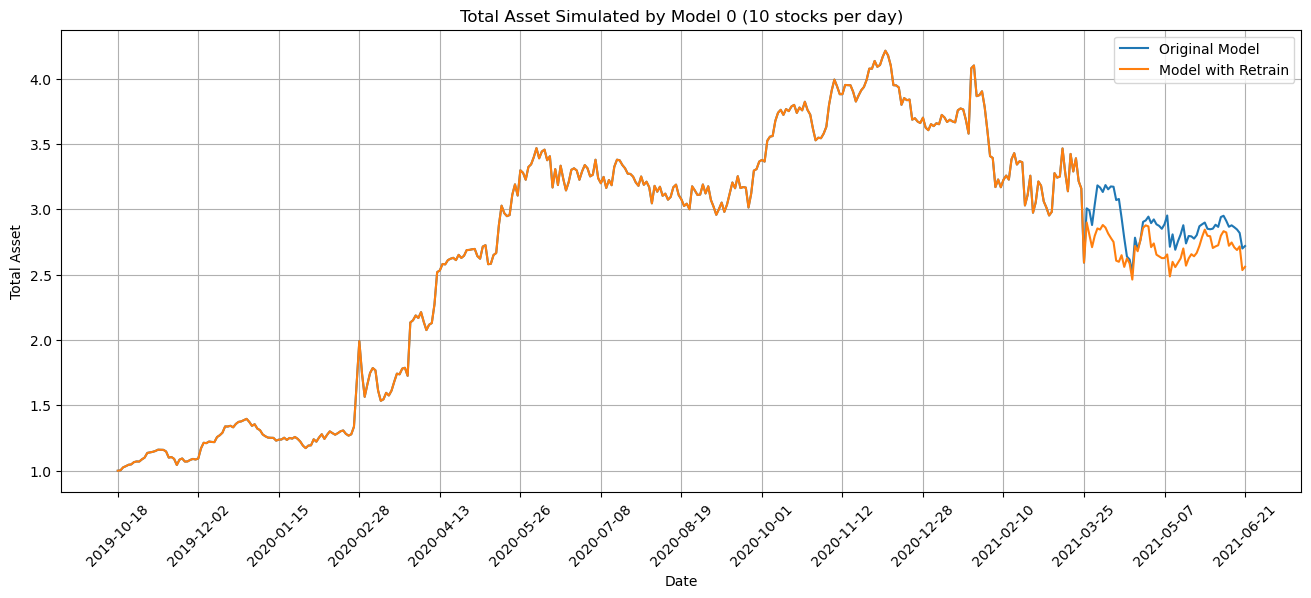

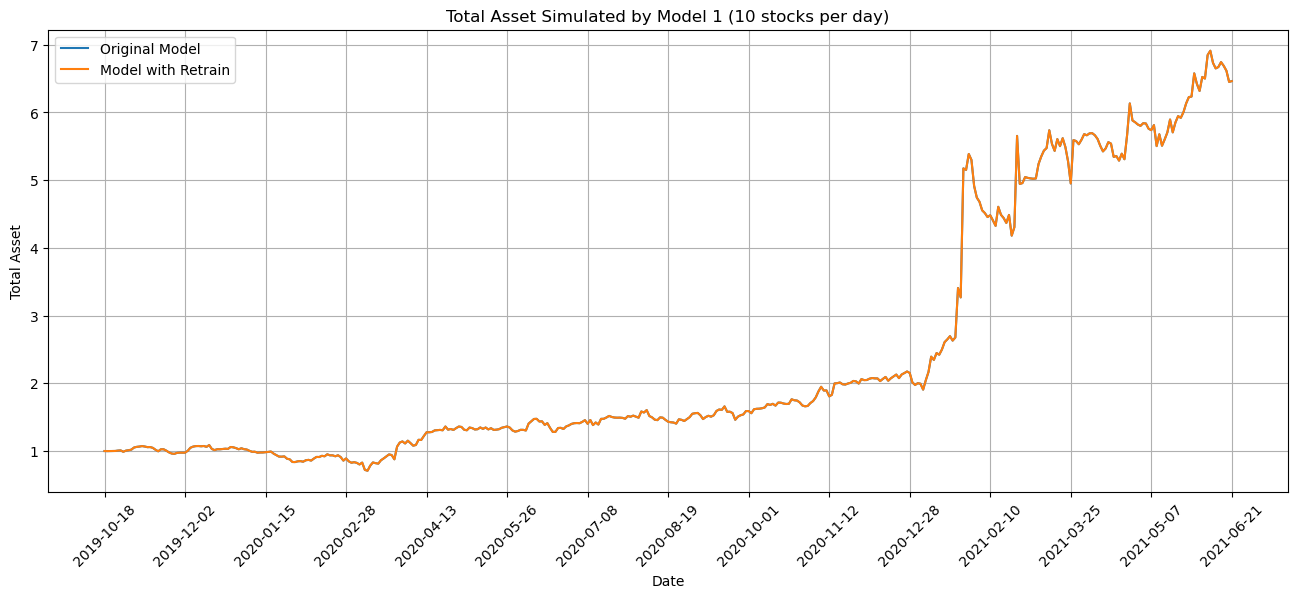

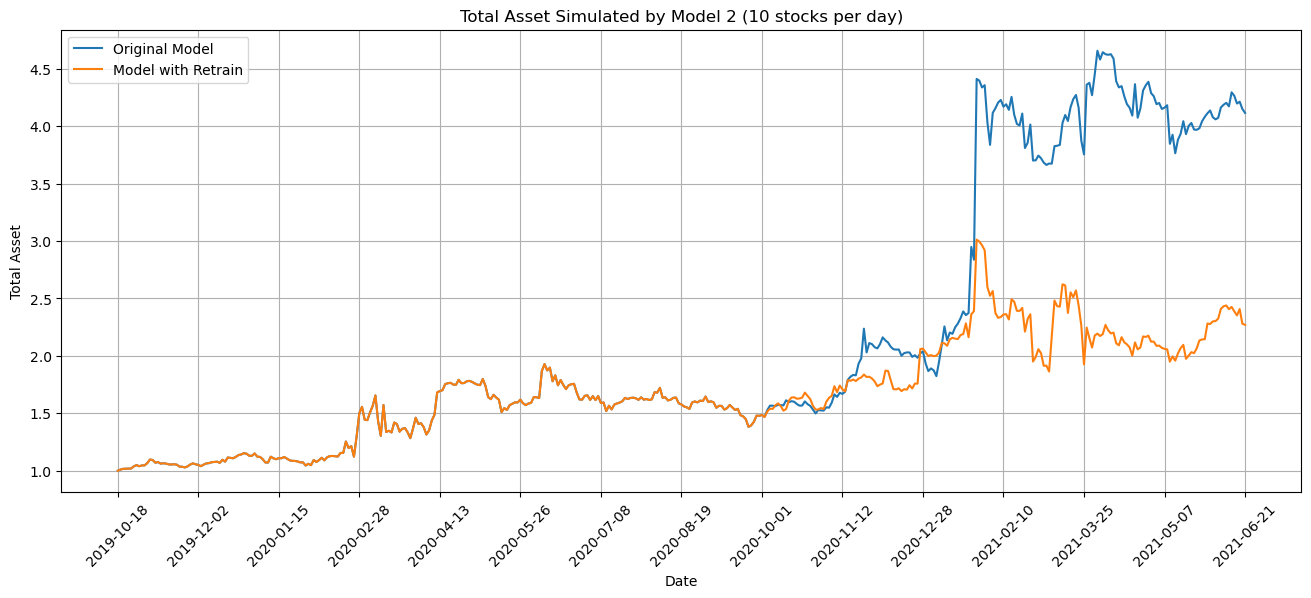

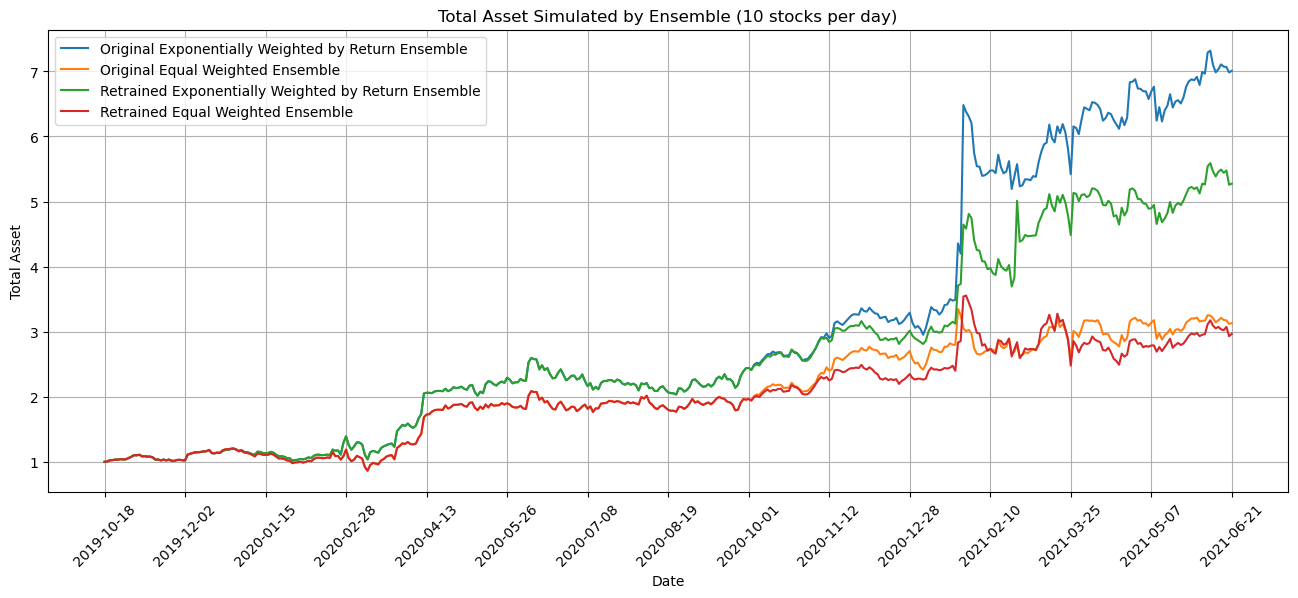

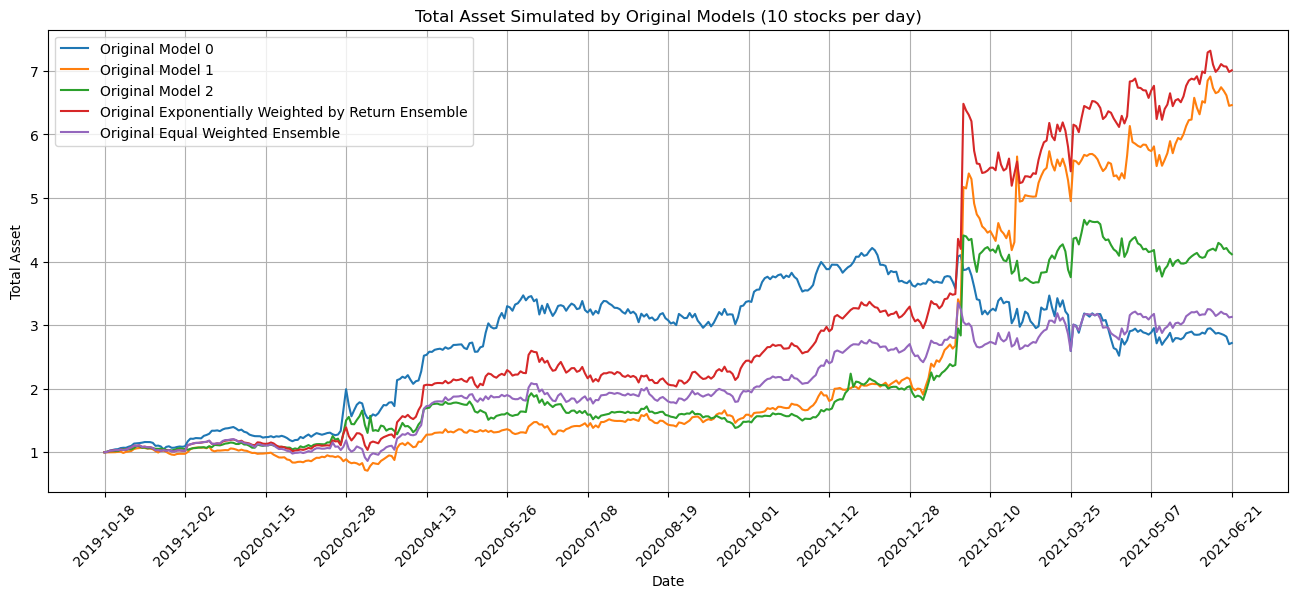

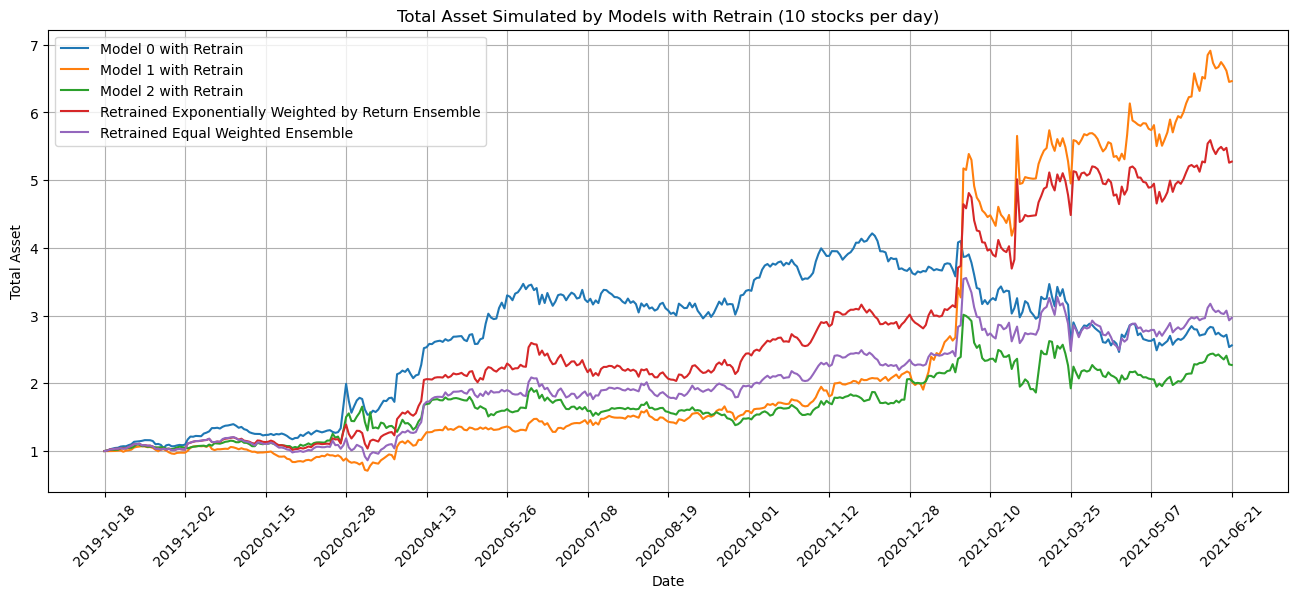

Iteration 22 of 58
Standardization data are from 2020-09-01 to 2021-01-25
Training data are from 2021-01-26 to 2021-06-17
Testing data are from 2021-05-21 to 2021-07-16
Training data have shape (185895, 20, 30), (185895,)
Testing data have shape (45900, 20, 30), (45900,)
Training model 0 using seed 124
Epoch 1/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0230 - val_loss: 0.0179 - lr: 0.0100
Epoch 2/500
146/146 [==============================] - 1s 4ms/step - loss: 0.0225 - val_loss: 0.0184 - lr: 0.0100
Epoch 3/500
146/146 [==============================] - 1s 4ms/step - loss: 0.0224 - val_loss: 0.0180 - lr: 0.0100
Epoch 4/500
146/146 [==============================] - 1s 4ms/step - loss: 0.0222 - val_loss: 0.0181 - lr: 0.0100
Epoch 5/500
146/146 [==============================] - 1s 4ms/step - loss: 0.0221 - val_loss: 0.0181 - lr: 0.0100
Epoch 6/500
146/146 [==============================] - 1s 4ms/step - loss: 0.0221 - val_loss: 0.0184 - lr: 0.0100
Epoch 7/500


top_stocks by original model 2 to buy on 2021-06-21 are ['SLYV', 'URA', 'SCCO', 'IJS', 'ABCB', 'TX', 'TSE', 'IBTX', 'WKC', 'SOXL']
top_stocks by retrained model 2 to buy on 2021-06-21 are ['FLR', 'TSE', 'LEA', 'HPQ', 'SWX', 'CCJ', 'GRFS', 'WKC', 'TX', 'UA']
Total asset on 2021-06-22 will be 4.209231624487156
It should be the same as 4.2092316244871695
Total asset on 2021-06-22 will be 2.303390259621013
It should be the same as 2.3033902596210223
Total asset on 2021-06-22 will be 3.4557572489534927
It should be the same as 3.455757248953505
top_stocks by original return weighted ensemble to buy on 2021-06-21 are ['HBAN', 'SCHW', 'ABG', 'PB', 'STX', 'HTH', 'URA', 'FIBK', 'ABCB', 'SOXL']
Total asset on 2021-06-22 will be 7.148017051939193
It should be the same as 7.148017051939204
top_stocks by original equal weighted ensemble to buy on 2021-06-21 are ['FFIN', 'HTH', 'FIBK', 'PB', 'URA', 'SCHW', 'IJS', 'HL', 'ABCB', 'SOXL']
Total asset on 2021-06-22 will be 3.1999093282712407
It should be

top_stocks by original model 0 to buy on 2021-06-25 are ['ALK', 'TSE', 'MHO', 'MDU', 'IVZ', 'DOX', 'CSTM', 'SM', 'MVIS', 'GME']
top_stocks by retrained model 0 to buy on 2021-06-25 are ['AMN', 'SHOO', 'AMED', 'ARCH', 'GTLS', 'DOX', 'MVIS', 'HP', 'SLCA', 'PTEN']
Total asset on 2021-06-28 will be 2.8558733904044926
It should be the same as 2.8558733904045255
Total asset on 2021-06-28 will be 2.6444725337900534
It should be the same as 2.64447253379009
Total asset on 2021-06-28 will be 6.989235829993772
It should be the same as 6.989235829993811
top_stocks by original model 1 to buy on 2021-06-25 are ['SLCA', 'NBR', 'WSC', 'ARCH', 'DOX', 'TPL', 'SCHP', 'AMED', 'AMN', 'HP']
top_stocks by retrained model 1 to buy on 2021-06-25 are ['SLCA', 'NBR', 'WSC', 'ARCH', 'DOX', 'TPL', 'SCHP', 'AMED', 'AMN', 'HP']
Total asset on 2021-06-28 will be 6.7702043406018175
It should be the same as 6.770204340601854
Total asset on 2021-06-28 will be 6.7702043406018175
It should be the same as 6.77020434060185

Total asset on 2021-07-01 will be 6.891145877628343
It should be the same as 6.891145877628383
Total asset on 2021-07-01 will be 6.891145877628343
It should be the same as 6.891145877628383
Total asset on 2021-07-01 will be 6.891145877628343
It should be the same as 6.891145877628383
top_stocks by original model 2 to buy on 2021-06-30 are ['AGIO', 'INTC', 'IDCC', 'RHP', 'TSLA', 'SNAP', 'ARGX', 'SPWR', 'SAVA', 'EDU']
top_stocks by retrained model 2 to buy on 2021-06-30 are ['SIG', 'ALGN', 'CNMD', 'FLOT', 'ASR', 'ARWR', 'FATE', 'BILI', 'EXEL', 'TTD']
Total asset on 2021-07-01 will be 4.28415962740744
It should be the same as 4.284159627407451
Total asset on 2021-07-01 will be 2.3677403187802115
It should be the same as 2.3677403187802204
Total asset on 2021-07-01 will be 3.5523011075033537
It should be the same as 3.5523011075033684
top_stocks by original return weighted ensemble to buy on 2021-06-30 are ['DPST', 'SPWR', 'CVI', 'NOV', 'LPLA', 'VTNR', 'CENN', 'DNN', 'TTD', 'EDU']
Total as

top_stocks by original model 2 to buy on 2021-07-06 are ['RIOT', 'SID', 'IRDM', 'EXTR', 'MSTR', 'NVCR', 'UEC', 'MARA', 'VTNR', 'SOXL']
top_stocks by retrained model 2 to buy on 2021-07-06 are ['RIOT', 'MATX', 'AMRC', 'BGNE', 'INGN', 'UCTT', 'DQ', 'ZLAB', 'MSTR', 'ARWR']
Total asset on 2021-07-07 will be 4.250674134055776
It should be the same as 4.2506741340557905
Total asset on 2021-07-07 will be 2.4419219974051627
It should be the same as 2.4419219974051716
Total asset on 2021-07-07 will be 3.663595262967002
It should be the same as 3.663595262967018
top_stocks by original return weighted ensemble to buy on 2021-07-06 are ['UCTT', 'STAA', 'RIOT', 'EXTR', 'MARA', 'EDU', 'MSTR', 'VTNR', 'AMC', 'SOXL']
Total asset on 2021-07-07 will be 7.133261135559196
It should be the same as 7.133261135559208
top_stocks by original equal weighted ensemble to buy on 2021-07-06 are ['SID', 'UCTT', 'STAA', 'QFIN', 'EXTR', 'VTNR', 'RIOT', 'MSTR', 'MARA', 'SOXL']
Total asset on 2021-07-07 will be 3.287226

top_stocks by original model 0 to buy on 2021-07-12 are ['CVLT', 'DQ', 'OGS', 'TSE', 'R', 'SID', 'PHG', 'OMCL', 'EVR', 'RIOT']
top_stocks by retrained model 0 to buy on 2021-07-12 are ['AES', 'CSTM', 'CCJ', 'AVNS', 'SLCA', 'GPRO', 'BCRX', 'EVRI', 'ATGE', 'CSGP']
Total asset on 2021-07-13 will be 2.86421743865274
It should be the same as 2.8642174386527723
Total asset on 2021-07-13 will be 2.4871074705510026
It should be the same as 2.4871074705510408
Total asset on 2021-07-13 will be 6.573326220676228
It should be the same as 6.57332622067627
top_stocks by original model 1 to buy on 2021-07-12 are ['QFIN', 'VUZI', 'MSI', 'UEC', 'TSE', 'FLRN', 'EVR', 'SOXL', 'CSGP', 'EDU']
top_stocks by retrained model 1 to buy on 2021-07-12 are ['QFIN', 'VUZI', 'MSI', 'UEC', 'TSE', 'FLRN', 'EVR', 'SOXL', 'CSGP', 'EDU']
Total asset on 2021-07-13 will be 6.6822643843777225
It should be the same as 6.682264384377761
Total asset on 2021-07-13 will be 6.6822643843777225
It should be the same as 6.6822643843

top_stocks by original model 1 to buy on 2021-07-15 are ['COPX', 'SLB', 'VRN', 'DVN', 'FCX', 'EVR', 'MT', 'DPST', 'FAS', 'EDU']
top_stocks by retrained model 1 to buy on 2021-07-15 are ['COPX', 'SLB', 'VRN', 'DVN', 'FCX', 'EVR', 'MT', 'DPST', 'FAS', 'EDU']
Total asset on 2021-07-16 will be 6.663103314266156
It should be the same as 6.663103314266195
Total asset on 2021-07-16 will be 6.663103314266156
It should be the same as 6.663103314266195
Total asset on 2021-07-16 will be 6.663103314266156
It should be the same as 6.663103314266195
top_stocks by original model 2 to buy on 2021-07-15 are ['WBS', 'COF', 'ERX', 'OLN', 'VRN', 'LAZ', 'AMC', 'VCEL', 'BYD', 'EVR']
top_stocks by retrained model 2 to buy on 2021-07-15 are ['OXY', 'AA', 'THRM', 'ARCH', 'TEX', 'FAS', 'SCHW', 'CNH', 'UAA', 'MTZ']
Total asset on 2021-07-16 will be 4.328079078299873
It should be the same as 4.328079078299885
Total asset on 2021-07-16 will be 2.3530277559515196
It should be the same as 2.3530277559515276
Total as

Iteration 23 of 58
Standardization data are from 2020-09-30 to 2021-02-23
Training data are from 2021-02-24 to 2021-07-16
Testing data are from 2021-06-21 to 2021-08-13
Training data have shape (185895, 20, 30), (185895,)
Testing data have shape (45900, 20, 30), (45900,)
Training model 0 using seed 124
Epoch 1/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0193 - val_loss: 0.0234 - lr: 0.0100
Epoch 2/500
146/146 [==============================] - 1s 4ms/step - loss: 0.0190 - val_loss: 0.0227 - lr: 0.0100
Epoch 3/500
146/146 [==============================] - 1s 4ms/step - loss: 0.0190 - val_loss: 0.0242 - lr: 0.0100
Epoch 4/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0189 - val_loss: 0.0236 - lr: 0.0100
Epoch 5/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0188 - val_loss: 0.0230 - lr: 0.0100
Epoch 6/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0187 - val_loss: 0.0228 - lr: 0.0100
Epoch 7/500


top_stocks by original model 2 to buy on 2021-07-20 are ['LZB', 'NXE', 'ERIC', 'ARGX', 'NTLA', 'DTE', 'ARVN', 'TTD', 'MRIN', 'VTNR']
top_stocks by retrained model 2 to buy on 2021-07-20 are ['TROX', 'WDFC', 'NXE', 'SPB', 'PBR', 'INSW', 'HMC', 'AEHR', 'SOXL', 'TELL']
Total asset on 2021-07-21 will be 4.245426725339968
It should be the same as 4.245426725339981
Total asset on 2021-07-21 will be 2.2968867885342017
It should be the same as 2.29688678853421
Total asset on 2021-07-21 will be 3.446000145372045
It should be the same as 3.446000145372064
top_stocks by original return weighted ensemble to buy on 2021-07-20 are ['NEAR', 'ARVN', 'LZB', 'EWJ', 'VTIP', 'CVE', 'ANGI', 'DTE', 'SOXL', 'VTNR']
Total asset on 2021-07-21 will be 7.102297574485047
It should be the same as 7.10229757448506
top_stocks by original equal weighted ensemble to buy on 2021-07-20 are ['WDFC', 'NEAR', 'ARVN', 'LZB', 'CVE', 'VTIP', 'SOXL', 'ANGI', 'DTE', 'VTNR']
Total asset on 2021-07-21 will be 3.3108042417307066
I

Total asset on 2021-07-26 will be 4.1180926320280875
It should be the same as 4.1180926320281
Total asset on 2021-07-26 will be 2.4001094328250154
It should be the same as 2.4001094328250243
Total asset on 2021-07-26 will be 3.600864220087208
It should be the same as 3.6008642200872267
top_stocks by original return weighted ensemble to buy on 2021-07-23 are ['VALE', 'SYF', 'SID', 'AEIS', 'CSGP', 'SLM', 'VC', 'INSW', 'ATGE', 'MRIN']
Total asset on 2021-07-26 will be 7.163214664921105
It should be the same as 7.163214664921119
top_stocks by original equal weighted ensemble to buy on 2021-07-23 are ['SNBR', 'SLM', 'EDU', 'SID', 'CSGP', 'VC', 'AEIS', 'INSW', 'ATGE', 'MRIN']
Total asset on 2021-07-26 will be 3.291694837711395
It should be the same as 3.2916948377114066
top_stocks by retrained return weighted ensemble to buy on 2021-07-23 are ['SPSM', 'TROX', 'BKR', 'LPG', 'ASX', 'VC', 'SYF', 'AEHR', 'INSW', 'SOXL']
Total asset on 2021-07-26 will be 5.458673280374602
It should be the same as

top_stocks by original model 0 to buy on 2021-07-29 are ['BJRI', 'SPB', 'SQQQ', 'AEP', 'AMGN', 'FXE', 'TECS', 'SWI', 'SNBR', 'SOXL']
top_stocks by retrained model 0 to buy on 2021-07-29 are ['GKOS', 'WIRE', 'AMC', 'AEHR', 'SWI', 'TAL', 'CMP', 'SOXL', 'ASTH', 'EDU']
Total asset on 2021-07-30 will be 2.7166491215210953
It should be the same as 2.7166491215211326
Total asset on 2021-07-30 will be 2.06843405439493
It should be the same as 2.0684340543949693
Total asset on 2021-07-30 will be 5.466789017557673
It should be the same as 5.466789017557715
top_stocks by original model 1 to buy on 2021-07-29 are ['CL', 'DPZ', 'SNBR', 'FXE', 'VANI', 'CP', 'SOXL', 'ONEQ', 'ASTH', 'SWI']
top_stocks by retrained model 1 to buy on 2021-07-29 are ['CL', 'DPZ', 'SNBR', 'FXE', 'VANI', 'CP', 'SOXL', 'ONEQ', 'ASTH', 'SWI']
Total asset on 2021-07-30 will be 6.742162955909518
It should be the same as 6.742162955909556
Total asset on 2021-07-30 will be 6.742162955909518
It should be the same as 6.742162955909

top_stocks by original model 1 to buy on 2021-08-03 are ['PTEN', 'BOOT', 'RIO', 'VALE', 'NTLA', 'FCX', 'SCCO', 'ASTH', 'QFIN', 'TAL']
top_stocks by retrained model 1 to buy on 2021-08-03 are ['PTEN', 'BOOT', 'RIO', 'VALE', 'NTLA', 'FCX', 'SCCO', 'ASTH', 'QFIN', 'TAL']
Total asset on 2021-08-04 will be 6.739486694862898
It should be the same as 6.739486694862939
Total asset on 2021-08-04 will be 6.739486694862898
It should be the same as 6.739486694862939
Total asset on 2021-08-04 will be 6.739486694862898
It should be the same as 6.739486694862939
top_stocks by original model 2 to buy on 2021-08-03 are ['NTLA', 'IXN', 'RHP', 'CMP', 'VALE', 'PTEN', 'CEIX', 'ASTH', 'MTDR', 'TAL']
top_stocks by retrained model 2 to buy on 2021-08-03 are ['NVMI', 'BRZU', 'IXN', 'PICK', 'ENTG', 'LSCC', 'FTAI', 'SCCO', 'VALE', 'MMYT']
Total asset on 2021-08-04 will be 4.38355036483789
It should be the same as 4.383550364837905
Total asset on 2021-08-04 will be 2.577979606074407
It should be the same as 2.577

Total asset on 2021-08-09 will be 6.688451666329844
It should be the same as 6.688451666329886
Total asset on 2021-08-09 will be 6.688451666329844
It should be the same as 6.688451666329886
Total asset on 2021-08-09 will be 6.688451666329844
It should be the same as 6.688451666329886
top_stocks by original model 2 to buy on 2021-08-06 are ['HCSG', 'LPSN', 'ATOS', 'ADT', 'GME', 'SWI', 'JAZZ', 'ASTH', 'CSGP', 'AEHR']
top_stocks by retrained model 2 to buy on 2021-08-06 are ['THS', 'SUPN', 'JAZZ', 'FTDR', 'MCRB', 'UPWK', 'HRL', 'ADT', 'KHC', 'SOXL']
Total asset on 2021-08-09 will be 4.201717101206936
It should be the same as 4.20171710120695
Total asset on 2021-08-09 will be 2.597206104934249
It should be the same as 2.5972061049342603
Total asset on 2021-08-09 will be 3.896566717977498
It should be the same as 3.8965667179775183
top_stocks by original return weighted ensemble to buy on 2021-08-06 are ['XENE', 'TTWO', 'MED', 'BRFS', 'SIRI', 'HCSG', 'ADT', 'SWI', 'AEHR', 'SOXL']
Total asse

Total asset on 2021-08-12 will be 3.030093335785608
It should be the same as 3.0300933357856374
top_stocks by original model 0 to buy on 2021-08-12 are ['TRGP', 'ODP', 'FORM', 'BOOT', 'GOLF', 'TER', 'GOOS', 'AMAT', 'ASTH', 'SOXL']
top_stocks by retrained model 0 to buy on 2021-08-12 are ['TRGP', 'GOOS', 'BCRX', 'GOLF', 'SNAP', 'UCO', 'SOXL', 'VTNR', 'BOOT', 'EDU']
Total asset on 2021-08-13 will be 2.64781095597651
It should be the same as 2.64781095597655
Total asset on 2021-08-13 will be 2.0588885674261017
It should be the same as 2.0588885674261426
Total asset on 2021-08-13 will be 5.441560674784281
It should be the same as 5.441560674784329
top_stocks by original model 1 to buy on 2021-08-12 are ['UCO', 'SNAP', 'TRGP', 'IGT', 'IPGP', 'BKE', 'AEO', 'BOOT', 'CAL', 'ASTH']
top_stocks by retrained model 1 to buy on 2021-08-12 are ['UCO', 'SNAP', 'TRGP', 'IGT', 'IPGP', 'BKE', 'AEO', 'BOOT', 'CAL', 'ASTH']
Total asset on 2021-08-13 will be 6.40820323132682
It should be the same as 6.40820

Iteration 24 of 58
Standardization data are from 2020-10-28 to 2021-03-23
Training data are from 2021-03-24 to 2021-08-13
Testing data are from 2021-07-20 to 2021-09-13
Training data have shape (185895, 20, 30), (185895,)
Testing data have shape (45900, 20, 30), (45900,)
Training model 0 using seed 124
Epoch 1/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0197 - val_loss: 0.0172 - lr: 0.0100
Epoch 2/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0194 - val_loss: 0.0177 - lr: 0.0100
Epoch 3/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0192 - val_loss: 0.0172 - lr: 0.0100
Epoch 4/500
146/146 [==============================] - 1s 4ms/step - loss: 0.0191 - val_loss: 0.0175 - lr: 0.0100
Epoch 5/500
146/146 [==============================] - 1s 4ms/step - loss: 0.0191 - val_loss: 0.0172 - lr: 0.0100
Epoch 6/500
146/146 [==============================] - 1s 4ms/step - loss: 0.0190 - val_loss: 0.0174 - lr: 0.0100
Epoch 7/500


top_stocks by original model 2 to buy on 2021-08-17 are ['CNMD', 'URI', 'AR', 'TEX', 'OSK', 'WIRE', 'SNAP', 'AEO', 'KALU', 'KTOS']
top_stocks by retrained model 2 to buy on 2021-08-17 are ['KTOS', 'MODG', 'AAL', 'SAVE', 'TDG', 'TGI', 'ASTH', 'BECN', 'WIRE', 'AEO']
Total asset on 2021-08-18 will be 3.91498221615691
It should be the same as 3.9149822161569268
Total asset on 2021-08-18 will be 2.39187211699524
It should be the same as 2.39187211699525
Total asset on 2021-08-18 will be 3.588505843658479
It should be the same as 3.5885058436585
top_stocks by original return weighted ensemble to buy on 2021-08-17 are ['OSK', 'TEX', 'CUBI', 'RIO', 'KALU', 'AR', 'WIRE', 'AEO', 'KTOS', 'MRIN']
Total asset on 2021-08-18 will be 6.543785694983742
It should be the same as 6.543785694983761
top_stocks by original equal weighted ensemble to buy on 2021-08-17 are ['MODG', 'OSK', 'RIO', 'CUBI', 'KALU', 'AR', 'WIRE', 'AEO', 'MRIN', 'KTOS']
Total asset on 2021-08-18 will be 2.99672259188073
It should be

Total asset on 2021-08-23 will be 2.9710908219251073
It should be the same as 2.9710908219251184
top_stocks by retrained return weighted ensemble to buy on 2021-08-20 are ['R', 'NMRK', 'GOGL', 'IPGP', 'SID', 'ASTH', 'VRRM', 'VALE', 'FOXF', 'MRIN']
Total asset on 2021-08-23 will be 5.264977610808872
It should be the same as 5.264977610808902
top_stocks by retrained equal weighted ensemble to buy on 2021-08-20 are ['R', 'NMRK', 'GOGL', 'ASTH', 'SID', 'IPGP', 'VRRM', 'VALE', 'FOXF', 'MRIN']
Total asset on 2021-08-23 will be 2.8840289902291816
It should be the same as 2.8840289902292113
top_stocks by original model 0 to buy on 2021-08-23 are ['AA', 'PFGC', 'GSG', 'SNBR', 'DE', 'NUE', 'AR', 'AMR', 'BTU', 'CEIX']
top_stocks by retrained model 0 to buy on 2021-08-23 are ['MUR', 'CRK', 'TM', 'BKR', 'NOG', 'MRO', 'EPD', 'CNQ', 'VRN', 'MRCY']
Total asset on 2021-08-24 will be 2.6500653533236402
It should be the same as 2.6500653533236798
Total asset on 2021-08-24 will be 1.9900096933135873
It sh

top_stocks by original model 0 to buy on 2021-08-26 are ['FTNT', 'BPMC', 'HDB', 'EYE', 'TGTX', 'TPX', 'MRIN', 'STX', 'KLAC', 'TVTX']
top_stocks by retrained model 0 to buy on 2021-08-26 are ['MMS', 'ATRC', 'INGN', 'AUPH', 'STX', 'AXSM', 'PBH', 'ALB', 'LC', 'CAH']
Total asset on 2021-08-27 will be 2.7041782506182086
It should be the same as 2.7041782506182486
Total asset on 2021-08-27 will be 1.9928877949290214
It should be the same as 1.9928877949290604
Total asset on 2021-08-27 will be 5.267123255582673
It should be the same as 5.267123255582722
top_stocks by original model 1 to buy on 2021-08-26 are ['CPB', 'ADI', 'FN', 'BABA', 'LC', 'SAIA', 'WEN', 'SLM', 'TVTX', 'MRIN']
top_stocks by retrained model 1 to buy on 2021-08-26 are ['CPB', 'ADI', 'FN', 'BABA', 'LC', 'SAIA', 'WEN', 'SLM', 'TVTX', 'MRIN']
Total asset on 2021-08-27 will be 6.633070535412002
It should be the same as 6.633070535412051
Total asset on 2021-08-27 will be 6.633070535412002
It should be the same as 6.63307053541205

Total asset on 2021-09-01 will be 7.109489345140979
It should be the same as 7.10948934514103
Total asset on 2021-09-01 will be 7.109489345140979
It should be the same as 7.10948934514103
Total asset on 2021-09-01 will be 7.109489345140979
It should be the same as 7.10948934514103
top_stocks by original model 2 to buy on 2021-08-31 are ['BGFV', 'ADNT', 'AMED', 'IVR', 'PLCE', 'DELL', 'CUBI', 'WB', 'HIBB', 'INGN']
top_stocks by retrained model 2 to buy on 2021-08-31 are ['GPRO', 'THS', 'FOXF', 'MARA', 'MD', 'LLY', 'WWW', 'BCRX', 'SYNA', 'ANY']
Total asset on 2021-09-01 will be 4.274372996258408
It should be the same as 4.274372996258423
Total asset on 2021-09-01 will be 2.599645509030557
It should be the same as 2.5996455090305695
Total asset on 2021-09-01 will be 3.90022653565439
It should be the same as 3.9002265356544132
top_stocks by original return weighted ensemble to buy on 2021-08-31 are ['DELL', 'INGN', 'BGFV', 'PLCE', 'CUBI', 'WB', 'AEHR', 'HIBB', 'ANY', 'MRIN']
Total asset on 

Total asset on 2021-09-07 will be 4.388275284842429
It should be the same as 4.388275284842445
Total asset on 2021-09-07 will be 2.650372268159912
It should be the same as 2.6503722681599236
Total asset on 2021-09-07 will be 3.9763314704759964
It should be the same as 3.9763314704760218
top_stocks by original return weighted ensemble to buy on 2021-09-03 are ['FIVE', 'DAR', 'WEN', 'BKE', 'WFC', 'AEHR', 'BGFV', 'ABBV', 'ANY', 'MRIN']
Total asset on 2021-09-07 will be 7.665367952151287
It should be the same as 7.665367952151318
top_stocks by original equal weighted ensemble to buy on 2021-09-03 are ['GSAT', 'WEN', 'FIVE', 'AEHR', 'BKE', 'WFC', 'BGFV', 'ABBV', 'ANY', 'MRIN']
Total asset on 2021-09-07 will be 3.514974344342901
It should be the same as 3.514974344342913
top_stocks by retrained return weighted ensemble to buy on 2021-09-03 are ['OLLI', 'BIG', 'BKE', 'DXC', 'HPQ', 'BGFV', 'AEHR', 'ABBV', 'ANY', 'MRIN']
Total asset on 2021-09-07 will be 6.2685903524963305
It should be the same

top_stocks by original model 0 to buy on 2021-09-10 are ['ITUB', 'BHP', 'GOGL', 'PBR', 'PARA', 'SBLK', 'PBR.A', 'IRDM', 'AEHR', 'BGFV']
top_stocks by retrained model 0 to buy on 2021-09-10 are ['PPG', 'BHP', 'SMAR', 'ABBV', 'LPG', 'AVNT', 'CNQ', 'DAN', 'HIBB', 'SBSW']
Total asset on 2021-09-13 will be 2.722725208979643
It should be the same as 2.7227252089796856
Total asset on 2021-09-13 will be 2.0990177683515268
It should be the same as 2.0990177683515663
Total asset on 2021-09-13 will be 5.547620558316147
It should be the same as 5.547620558316193
top_stocks by original model 1 to buy on 2021-09-10 are ['FLRN', 'SBSW', 'HIBB', 'BIL', 'BGFV', 'TTD', 'ASTH', 'AEHR', 'ANY', 'MRIN']
top_stocks by retrained model 1 to buy on 2021-09-10 are ['FLRN', 'SBSW', 'HIBB', 'BIL', 'BGFV', 'TTD', 'ASTH', 'AEHR', 'ANY', 'MRIN']
Total asset on 2021-09-13 will be 7.494220548934817
It should be the same as 7.494220548934868
Total asset on 2021-09-13 will be 7.494220548934817
It should be the same as 7.

Iteration 25 of 58
Standardization data are from 2020-11-25 to 2021-04-21
Training data are from 2021-04-22 to 2021-09-13
Testing data are from 2021-08-17 to 2021-10-11
Training data have shape (185895, 20, 30), (185895,)
Testing data have shape (45900, 20, 30), (45900,)
Training model 0 using seed 124
Epoch 1/500
146/146 [==============================] - 1s 6ms/step - loss: 0.0180 - val_loss: 0.0169 - lr: 0.0100
Epoch 2/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0177 - val_loss: 0.0169 - lr: 0.0100
Epoch 3/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0176 - val_loss: 0.0169 - lr: 0.0100
Epoch 4/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0176 - val_loss: 0.0168 - lr: 0.0100
Epoch 5/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0176 - val_loss: 0.0169 - lr: 0.0100
Epoch 6/500
146/146 [==============================] - 1s 6ms/step - loss: 0.0174 - val_loss: 0.0168 - lr: 0.0100
Epoch 7/500


146/146 [==============================] - 1s 5ms/step - loss: 0.0161 - val_loss: 0.0167 - lr: 0.0010
Epoch 35/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0160 - val_loss: 0.0166 - lr: 0.0010
Epoch 35: early stopping
Weight of original model 0 is 0.2680972290912037
Weight of retrained model 0 is 0.22197512085825974
Weight of original model 1 is 0.4232220117299531
Weight of retrained model 1 is 0.43879826341589073
Weight of original model 2 is 0.3086807591788433
Weight of retrained model 2 is 0.3392266157258495
top_stocks by original model 0 to buy on 2021-09-15 are ['STLD', 'PFGC', 'GGAL', 'WYNN', 'HLF', 'AXSM', 'VCEL', 'CDNA', 'VGR', 'ACHC']
top_stocks by retrained model 0 to buy on 2021-09-15 are ['CROX', 'TRUP', 'SBSW', 'AMC', 'CDNA', 'WYNN', 'FLWS', 'VGR', 'ACHC', 'HLF']
Total asset on 2021-09-16 will be 2.6865931992217256
It should be the same as 2.6865931992217695
Total asset on 2021-09-16 will be 2.073998873507002
It should be the same as 2.0739988735070

Total asset on 2021-09-20 will be 3.1645350630980595
It should be the same as 3.164535063098087
top_stocks by original model 0 to buy on 2021-09-20 are ['BLK', 'KWR', 'UNM', 'TRN', 'MDU', 'PTGX', 'MGNX', 'BOIL', 'MAN', 'ZD']
top_stocks by retrained model 0 to buy on 2021-09-20 are ['TRN', 'MGNX', 'BPOP', 'FUL', 'EXP', 'ATI', 'HP', 'MAN', 'PNFP', 'PTGX']
Total asset on 2021-09-21 will be 2.5458857113648676
It should be the same as 2.5458857113649116
Total asset on 2021-09-21 will be 2.0421368997962754
It should be the same as 2.0421368997963154
Total asset on 2021-09-21 will be 5.39728668285791
It should be the same as 5.397286682857955
top_stocks by original model 1 to buy on 2021-09-20 are ['SCHW', 'GS', 'PSMT', 'AMRC', 'SNA', 'FUL', 'RJF', 'FNB', 'MAN', 'PNFP']
top_stocks by retrained model 1 to buy on 2021-09-20 are ['SCHW', 'GS', 'PSMT', 'AMRC', 'SNA', 'FUL', 'RJF', 'FNB', 'MAN', 'PNFP']
Total asset on 2021-09-21 will be 7.308146073290507
It should be the same as 7.308146073290559


Total asset on 2021-09-24 will be 2.61958836718401
It should be the same as 2.619588367184056
Total asset on 2021-09-24 will be 2.1641000103890917
It should be the same as 2.164100010389131
Total asset on 2021-09-24 will be 5.719630338010604
It should be the same as 5.719630338010649
top_stocks by original model 1 to buy on 2021-09-23 are ['TRIP', 'DY', 'TTC', 'BF.B', 'NMRK', 'BSX', 'ASTH', 'YPF', 'GGAL', 'DIS']
top_stocks by retrained model 1 to buy on 2021-09-23 are ['TRIP', 'DY', 'TTC', 'BF.B', 'NMRK', 'BSX', 'ASTH', 'YPF', 'GGAL', 'DIS']
Total asset on 2021-09-24 will be 7.57317322417733
It should be the same as 7.573173224177381
Total asset on 2021-09-24 will be 7.57317322417733
It should be the same as 7.573173224177381
Total asset on 2021-09-24 will be 7.57317322417733
It should be the same as 7.573173224177381
top_stocks by original model 2 to buy on 2021-09-23 are ['LTC', 'ATR', 'MAT', 'EXP', 'BSX', 'NSIT', 'DIS', 'H', 'ZBH', 'COLD']
top_stocks by retrained model 2 to buy on 2

top_stocks by original model 2 to buy on 2021-09-28 are ['HES', 'COLD', 'NHI', 'CABO', 'CUBE', 'MED', 'DLR', 'EXR', 'LTC', 'CP']
top_stocks by retrained model 2 to buy on 2021-09-28 are ['SGRY', 'DLR', 'EPC', 'TOL', 'BCO', 'MED', 'LEN', 'LTC', 'MAT', 'HPE']
Total asset on 2021-09-29 will be 4.497067044205888
It should be the same as 4.497067044205906
Total asset on 2021-09-29 will be 2.6536972907090726
It should be the same as 2.6536972907090868
Total asset on 2021-09-29 will be 3.9813199741519214
It should be the same as 3.981319974151948
top_stocks by original return weighted ensemble to buy on 2021-09-28 are ['HPE', 'EXR', 'DLR', 'MED', 'BCO', 'DBRG', 'OSK', 'TOL', 'LTC', 'MAT']
Total asset on 2021-09-29 will be 7.22664674662718
It should be the same as 7.226646746627215
top_stocks by original equal weighted ensemble to buy on 2021-09-28 are ['CABO', 'DBRG', 'EXR', 'DLR', 'MED', 'OSK', 'BCO', 'TOL', 'MAT', 'LTC']
Total asset on 2021-09-29 will be 3.3640404666614803
It should be the 

Total asset on 2021-10-04 will be 6.107979277224414
It should be the same as 6.1079792772244454
top_stocks by retrained equal weighted ensemble to buy on 2021-10-01 are ['STAA', 'WAT', 'PTC', 'DDS', 'LOVE', 'GNRC', 'MTD', 'OTEX', 'KMX', 'KSS']
Total asset on 2021-10-04 will be 3.3252484785741965
It should be the same as 3.325248478574225
top_stocks by original model 0 to buy on 2021-10-04 are ['NWL', 'JCI', 'JBT', 'MEDP', 'MORN', 'COO', 'GE', 'NXPI', 'DDS', 'MTD']
top_stocks by retrained model 0 to buy on 2021-10-04 are ['TJX', 'JCI', 'DDS', 'MEDP', 'HLNE', 'BOOT', 'MTD', 'ASTH', 'PRTA', 'VTIP']
Total asset on 2021-10-05 will be 2.6370910519728548
It should be the same as 2.637091051972901
Total asset on 2021-10-05 will be 2.2185764766991594
It should be the same as 2.2185764766991984
Total asset on 2021-10-05 will be 5.863609473872561
It should be the same as 5.863609473872609
top_stocks by original model 1 to buy on 2021-10-04 are ['JBT', 'UEC', 'BFAM', 'CI', 'ELV', 'CNC', 'WBA', 'CM

top_stocks by original model 0 to buy on 2021-10-07 are ['TM', 'HESM', 'AN', 'NOG', 'CAL', 'ECH', 'TJX', 'HMC', 'AEO', 'XENE']
top_stocks by retrained model 0 to buy on 2021-10-07 are ['SEM', 'AEO', 'LEA', 'EVRI', 'ECH', 'MODG', 'HIBB', 'BWA', 'HESM', 'LNG']
Total asset on 2021-10-08 will be 2.668639644960739
It should be the same as 2.668639644960784
Total asset on 2021-10-08 will be 2.2581675199354616
It should be the same as 2.258167519935501
Total asset on 2021-10-08 will be 5.968247028015509
It should be the same as 5.968247028015556
top_stocks by original model 1 to buy on 2021-10-07 are ['FL', 'ET', 'HIBB', 'FCX', 'NXPI', 'EVRI', 'XENE', 'LNG', 'SKY', 'UPBD']
top_stocks by retrained model 1 to buy on 2021-10-07 are ['FL', 'ET', 'HIBB', 'FCX', 'NXPI', 'EVRI', 'XENE', 'LNG', 'SKY', 'UPBD']
Total asset on 2021-10-08 will be 7.627576820334354
It should be the same as 7.6275768203344105
Total asset on 2021-10-08 will be 7.627576820334354
It should be the same as 7.6275768203344105
To

Total asset on 2021-10-13 will be 7.212065521245294
It should be the same as 7.212065521245351
Total asset on 2021-10-13 will be 7.212065521245294
It should be the same as 7.212065521245351
Total asset on 2021-10-13 will be 7.212065521245294
It should be the same as 7.212065521245351
top_stocks by original model 2 to buy on 2021-10-12 are ['RGEN', 'SGH', 'FRPT', 'PAGS', 'CG', 'EVRI', 'HCSG', 'DECK', 'SLM', 'XENE']
top_stocks by retrained model 2 to buy on 2021-10-12 are ['PLAY', 'SUPN', 'CMPR', 'HZO', 'HAS', 'HCSG', 'SLM', 'HALO', 'PTGX', 'KSS']
Total asset on 2021-10-13 will be 5.131116811138513
It should be the same as 5.131116811138529
Total asset on 2021-10-13 will be 2.567810572621153
It should be the same as 2.567810572621167
Total asset on 2021-10-13 will be 3.852464845334113
It should be the same as 3.852464845334139
top_stocks by original return weighted ensemble to buy on 2021-10-12 are ['ON', 'DECK', 'SPHY', 'CG', 'KSS', 'BSCO', 'PAGS', 'HCSG', 'HALO', 'SLM']
Total asset on 

146/146 [==============================] - 1s 5ms/step - loss: 0.0159 - val_loss: 0.0190 - lr: 0.0010
Epoch 38: early stopping
Training model 2 using seed 125
Epoch 1/500
146/146 [==============================] - 1s 6ms/step - loss: 0.0175 - val_loss: 0.0192 - lr: 0.0100
Epoch 2/500
146/146 [==============================] - 1s 6ms/step - loss: 0.0173 - val_loss: 0.0199 - lr: 0.0100
Epoch 3/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0172 - val_loss: 0.0196 - lr: 0.0100
Epoch 4/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0171 - val_loss: 0.0194 - lr: 0.0100
Epoch 5/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0170 - val_loss: 0.0199 - lr: 0.0100
Epoch 6/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0170 - val_loss: 0.0190 - lr: 0.0100
Epoch 7/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0170 - val_loss: 0.0192 - lr: 0.0100
Epoch 8/500
146/146 [======================

Total asset on 2021-10-15 will be 7.50338202955685
It should be the same as 7.503382029556907
Total asset on 2021-10-15 will be 7.50338202955685
It should be the same as 7.503382029556907
Total asset on 2021-10-15 will be 7.50338202955685
It should be the same as 7.503382029556907
top_stocks by original model 2 to buy on 2021-10-14 are ['BKD', 'COP', 'ZD', 'MUFG', 'FLWS', 'SIG', 'MRNA', 'FRO', 'ATGE', 'BOIL']
top_stocks by retrained model 2 to buy on 2021-10-14 are ['SMFG', 'TMO', 'DFS', 'BBVA', 'GRWG', 'ATGE', 'ODFL', 'FRO', 'GOGL', 'TPL']
Total asset on 2021-10-15 will be 5.390978257372086
It should be the same as 5.390978257372102
Total asset on 2021-10-15 will be 2.688288262482854
It should be the same as 2.688288262482868
Total asset on 2021-10-15 will be 4.033216521407122
It should be the same as 4.03321652140715
top_stocks by original return weighted ensemble to buy on 2021-10-14 are ['SMFG', 'TPL', 'BBVA', 'BOIL', 'MUFG', 'DFS', 'ATGE', 'FLWS', 'FRO', 'SIG']
Total asset on 2021

Total asset on 2021-10-20 will be 3.283505910988302
It should be the same as 3.2835059109883336
top_stocks by original model 0 to buy on 2021-10-20 are ['SNY', 'GEF', 'M', 'UVXY', 'CUBI', 'IP', 'TECS', 'MAN', 'ULTA', 'BOIL']
top_stocks by retrained model 0 to buy on 2021-10-20 are ['UNF', 'ULTA', 'GEF', 'JBT', 'FWRD', 'PR', 'IP', 'EPD', 'JJSF', 'MAN']
Total asset on 2021-10-21 will be 2.786559490704922
It should be the same as 2.7865594907049704
Total asset on 2021-10-21 will be 2.2685189933406487
It should be the same as 2.268518993340691
Total asset on 2021-10-21 will be 5.995605560914724
It should be the same as 5.995605560914775
top_stocks by original model 1 to buy on 2021-10-20 are ['UNF', 'BLMN', 'ULTA', 'PR', 'CUBI', 'SAVE', 'BMRN', 'SBH', 'BOIL', 'MAN']
top_stocks by retrained model 1 to buy on 2021-10-20 are ['UNF', 'BLMN', 'ULTA', 'PR', 'CUBI', 'SAVE', 'BMRN', 'SBH', 'BOIL', 'MAN']
Total asset on 2021-10-21 will be 7.309119745018789
It should be the same as 7.309119745018846

Total asset on 2021-10-26 will be 2.821320283694008
It should be the same as 2.821320283694059
Total asset on 2021-10-26 will be 2.3352456614346764
It should be the same as 2.335245661434719
Total asset on 2021-10-26 will be 6.171961493335953
It should be the same as 6.171961493336005
top_stocks by original model 1 to buy on 2021-10-25 are ['AEO', 'MMYT', 'INTC', 'QFIN', 'GGB', 'RVNC', 'SNAP', 'ERJ', 'SID', 'XENE']
top_stocks by retrained model 1 to buy on 2021-10-25 are ['AEO', 'MMYT', 'INTC', 'QFIN', 'GGB', 'RVNC', 'SNAP', 'ERJ', 'SID', 'XENE']
Total asset on 2021-10-26 will be 7.372061664427919
It should be the same as 7.372061664427978
Total asset on 2021-10-26 will be 7.372061664427919
It should be the same as 7.372061664427978
Total asset on 2021-10-26 will be 7.372061664427919
It should be the same as 7.372061664427978
top_stocks by original model 2 to buy on 2021-10-25 are ['PLCE', 'CLB', 'MGNI', 'AEO', 'GGB', 'ET', 'MRIN', 'AEHR', 'XENE', 'RVNC']
top_stocks by retrained model 

Total asset on 2021-10-29 will be 7.337750899412822
It should be the same as 7.337750899412879
Total asset on 2021-10-29 will be 7.337750899412822
It should be the same as 7.337750899412879
Total asset on 2021-10-29 will be 7.337750899412822
It should be the same as 7.337750899412879
top_stocks by original model 2 to buy on 2021-10-28 are ['POST', 'OXM', 'RS', 'LIVN', 'BCC', 'ASTH', 'SBLK', 'MRIN', 'GOGL', 'AEHR']
top_stocks by retrained model 2 to buy on 2021-10-28 are ['PLAY', 'EVRI', 'OXM', 'LIVN', 'EXR', 'IXN', 'FL', 'SBH', 'SBLK', 'PTGX']
Total asset on 2021-10-29 will be 4.944347025939435
It should be the same as 4.944347025939449
Total asset on 2021-10-29 will be 2.652578290777541
It should be the same as 2.652578290777556
Total asset on 2021-10-29 will be 3.97964114786149
It should be the same as 3.9796411478615217
top_stocks by original return weighted ensemble to buy on 2021-10-28 are ['GIII', 'LIVN', 'ASTH', 'OXM', 'RS', 'POST', 'SBH', 'BCC', 'SBLK', 'GOGL']
Total asset on 2

Total asset on 2021-11-03 will be 5.924550855162713
It should be the same as 5.924550855162753
top_stocks by retrained equal weighted ensemble to buy on 2021-11-02 are ['VALE', 'DECK', 'NOC', 'SGRY', 'EWM', 'KRG', 'EIDO', 'BCO', 'CENX', 'LAUR']
Total asset on 2021-11-03 will be 3.278434606713537
It should be the same as 3.2784346067135703
top_stocks by original model 0 to buy on 2021-11-03 are ['CHGG', 'SBLK', 'PTGX', 'IDXX', 'GE', 'ORCL', 'VALE', 'GOGL', 'STNG', 'DELL']
top_stocks by retrained model 0 to buy on 2021-11-03 are ['BBAX', 'GOGL', 'YINN', 'RVNC', 'PICK', 'MOS', 'ATI', 'VALE', 'CAR', 'DELL']
Total asset on 2021-11-04 will be 2.909311391379636
It should be the same as 2.909311391379688
Total asset on 2021-11-04 will be 2.292044117337766
It should be the same as 2.2920441173378094
Total asset on 2021-11-04 will be 6.057781528879891
It should be the same as 6.057781528879949
top_stocks by original model 1 to buy on 2021-11-03 are ['IPG', 'VALE', 'STNG', 'MT', 'MOS', 'BLMN', 'G

top_stocks by original model 0 to buy on 2021-11-08 are ['MMC', 'DVAX', 'TDC', 'DCPH', 'FRO', 'FND', 'AAOI', 'WAT', 'IQV', 'DELL']
top_stocks by retrained model 0 to buy on 2021-11-08 are ['REGN', 'GS', 'LH', 'SCHW', 'DCPH', 'WAT', 'FND', 'DGX', 'HII', 'FRO']
Total asset on 2021-11-09 will be 2.853103061547102
It should be the same as 2.8531030615471544
Total asset on 2021-11-09 will be 2.3297994595822313
It should be the same as 2.3297994595822753
Total asset on 2021-11-09 will be 6.157567398242088
It should be the same as 6.157567398242147
top_stocks by original model 1 to buy on 2021-11-08 are ['SLGN', 'WM', 'ALT', 'MMC', 'TDC', 'EPAM', 'DGX', 'FRO', 'FND', 'DELL']
top_stocks by retrained model 1 to buy on 2021-11-08 are ['SLGN', 'WM', 'ALT', 'MMC', 'TDC', 'EPAM', 'DGX', 'FRO', 'FND', 'DELL']
Total asset on 2021-11-09 will be 7.315165942140541
It should be the same as 7.315165942140596
Total asset on 2021-11-09 will be 7.315165942140541
It should be the same as 7.315165942140596
Tot

146/146 [==============================] - 1s 5ms/step - loss: 0.0166 - val_loss: 0.0202 - lr: 0.0050
Epoch 10/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0166 - val_loss: 0.0201 - lr: 0.0050
Epoch 11/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0166 - val_loss: 0.0203 - lr: 0.0050
Epoch 12/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0164 - val_loss: 0.0201 - lr: 0.0025
Epoch 13/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0164 - val_loss: 0.0200 - lr: 0.0025
Epoch 14/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0164 - val_loss: 0.0204 - lr: 0.0025
Epoch 15/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0164 - val_loss: 0.0202 - lr: 0.0025
Epoch 16/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0164 - val_loss: 0.0202 - lr: 0.0025
Epoch 17/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0164 - val_loss

Total asset on 2021-11-11 will be 3.227785235579668
It should be the same as 3.227785235579701
top_stocks by original model 0 to buy on 2021-11-11 are ['TCOM', 'AEO', 'UAL', 'MWA', 'GPI', 'PRPL', 'BOIL', 'AEHR', 'LNW', 'GE']
top_stocks by retrained model 0 to buy on 2021-11-11 are ['ATI', 'UAL', 'MOD', 'BOOT', 'CAL', 'PATK', 'PLCE', 'AEO', 'AEHR', 'GE']
Total asset on 2021-11-12 will be 2.6827411829352203
It should be the same as 2.6827411829352728
Total asset on 2021-11-12 will be 2.30329037517413
It should be the same as 2.303290375174174
Total asset on 2021-11-12 will be 6.0875049414768885
It should be the same as 6.087504941476948
top_stocks by original model 1 to buy on 2021-11-11 are ['BKE', 'FIXD', 'RRX', 'G', 'SPIP', 'CLS', 'BOOT', 'SCHP', 'GPI', 'GE']
top_stocks by retrained model 1 to buy on 2021-11-11 are ['BKE', 'FIXD', 'RRX', 'G', 'SPIP', 'CLS', 'BOOT', 'SCHP', 'GPI', 'GE']
Total asset on 2021-11-12 will be 7.093711919377487
It should be the same as 7.093711919377541
Total

top_stocks by original model 1 to buy on 2021-11-16 are ['IBP', 'ATGE', 'IHG', 'RL', 'MUR', 'COLB', 'SM', 'PTEN', 'ENB', 'BBVA']
top_stocks by retrained model 1 to buy on 2021-11-16 are ['IBP', 'ATGE', 'IHG', 'RL', 'MUR', 'COLB', 'SM', 'PTEN', 'ENB', 'BBVA']
Total asset on 2021-11-17 will be 6.928650567015578
It should be the same as 6.928650567015632
Total asset on 2021-11-17 will be 6.928650567015578
It should be the same as 6.928650567015632
Total asset on 2021-11-17 will be 6.928650567015578
It should be the same as 6.928650567015632
top_stocks by original model 2 to buy on 2021-11-16 are ['DBO', 'TPL', 'PARR', 'UCO', 'GDDY', 'BBVA', 'LOPE', 'GE', 'PTEN', 'AEHR']
top_stocks by retrained model 2 to buy on 2021-11-16 are ['USO', 'RL', 'HL', 'UCO', 'PTEN', 'SPWR', 'ZD', 'ATGE', 'BBVA', 'CAR']
Total asset on 2021-11-17 will be 4.668952485619157
It should be the same as 4.668952485619171
Total asset on 2021-11-17 will be 2.631191055334216
It should be the same as 2.6311910553342326
Tota

top_stocks by original model 2 to buy on 2021-11-19 are ['PRGS', 'DOX', 'BWA', 'LC', 'NMIH', 'MTDR', 'LPSN', 'EQNR', 'BFH', 'AEHR']
top_stocks by retrained model 2 to buy on 2021-11-19 are ['SM', 'VTLE', 'PTEN', 'LHX', 'GPN', 'INCY', 'CRK', 'BOIL', 'PRO', 'AEHR']
Total asset on 2021-11-22 will be 4.4625212198490845
It should be the same as 4.462521219849099
Total asset on 2021-11-22 will be 2.4510060093084487
It should be the same as 2.4510060093084647
Total asset on 2021-11-22 will be 3.6772239304727523
It should be the same as 3.6772239304727807
top_stocks by original return weighted ensemble to buy on 2021-11-19 are ['TAN', 'LC', 'PRGS', 'PRO', 'EQNR', 'RUN', 'LPSN', 'SGRY', 'BFH', 'AEHR']
Total asset on 2021-11-22 will be 6.373122109082599
It should be the same as 6.373122109082647
top_stocks by original equal weighted ensemble to buy on 2021-11-19 are ['TAN', 'LC', 'EQNR', 'PRGS', 'PRO', 'RUN', 'LPSN', 'SGRY', 'BFH', 'AEHR']
Total asset on 2021-11-22 will be 3.0518470811323115
It 

Total asset on 2021-11-26 will be 5.445235331811293
It should be the same as 5.445235331811343
top_stocks by retrained equal weighted ensemble to buy on 2021-11-24 are ['SAP', 'EB', 'BRZU', 'ENTA', 'BFH', 'BKR', 'ATI', 'WAT', 'OLN', 'PAR']
Total asset on 2021-11-26 will be 2.964125442821261
It should be the same as 2.9641254428212918
top_stocks by original model 0 to buy on 2021-11-26 are ['ROK', 'OKTA', 'EXPD', 'VNOM', 'LFUS', 'PAR', 'MEDP', 'BBY', 'PBR.A', 'PRFT']
top_stocks by retrained model 0 to buy on 2021-11-26 are ['DE', 'AEHR', 'GDOT', 'FRPT', 'BRZU', 'MWA', 'PSA', 'BBY', 'FTNT', 'RNG']
Total asset on 2021-11-29 will be 2.567095204977039
It should be the same as 2.567095204977093
Total asset on 2021-11-29 will be 2.159043670443974
It should be the same as 2.159043670444018
Total asset on 2021-11-29 will be 5.706266632446838
It should be the same as 5.706266632446896
top_stocks by original model 1 to buy on 2021-11-26 are ['HYD', 'KOS', 'MSM', 'ESTC', 'RNG', 'PRFT', 'MINT', 'PA

Total asset on 2021-12-02 will be 2.4748414397686274
It should be the same as 2.4748414397686815
Total asset on 2021-12-02 will be 2.0841490477198064
It should be the same as 2.0841490477198517
Total asset on 2021-12-02 will be 5.5083231204878045
It should be the same as 5.50832312048786
top_stocks by original model 1 to buy on 2021-12-01 are ['BDC', 'CLS', 'HHH', 'RWT', 'AMC', 'KALU', 'ATI', 'MOD', 'NGVT', 'SIGI']
top_stocks by retrained model 1 to buy on 2021-12-01 are ['BDC', 'CLS', 'HHH', 'RWT', 'AMC', 'KALU', 'ATI', 'MOD', 'NGVT', 'SIGI']
Total asset on 2021-12-02 will be 6.188417227136981
It should be the same as 6.188417227137037
Total asset on 2021-12-02 will be 6.188417227136981
It should be the same as 6.188417227137037
Total asset on 2021-12-02 will be 6.188417227136981
It should be the same as 6.188417227137037
top_stocks by original model 2 to buy on 2021-12-01 are ['HDB', 'AMC', 'MOD', 'MOG.A', 'GD', 'HII', 'ATI', 'SIGI', 'KALU', 'NGVT']
top_stocks by retrained model 2 to

top_stocks by original model 2 to buy on 2021-12-06 are ['NEM', 'DBX', 'MGY', 'RRR', 'PARR', 'CIVI', 'MODG', 'SCCO', 'CNQ', 'PDBC']
top_stocks by retrained model 2 to buy on 2021-12-06 are ['NEM', 'PDBC', 'TWLO', 'RVNC', 'MODG', 'KBR', 'HRB', 'HL', 'EPD', 'ALT']
Total asset on 2021-12-07 will be 4.540182909145492
It should be the same as 4.54018290914551
Total asset on 2021-12-07 will be 2.4867275614830935
It should be the same as 2.4867275614831095
Total asset on 2021-12-07 will be 3.7308166781002052
It should be the same as 3.7308166781002345
top_stocks by original return weighted ensemble to buy on 2021-12-06 are ['PARR', 'FFIV', 'NEM', 'IMO', 'EOG', 'PDBC', 'HL', 'CIVI', 'EPD', 'CNQ']
Total asset on 2021-12-07 will be 6.291554530136844
It should be the same as 6.291554530136898
top_stocks by original equal weighted ensemble to buy on 2021-12-06 are ['PARR', 'FFIV', 'NEM', 'IMO', 'EOG', 'CIVI', 'HL', 'PDBC', 'CNQ', 'EPD']
Total asset on 2021-12-07 will be 3.0557669300557064
It shoul

Training data have shape (185895, 20, 30), (185895,)
Testing data have shape (45900, 20, 30), (45900,)
Training model 0 using seed 124
Epoch 1/500
146/146 [==============================] - 1s 6ms/step - loss: 0.0177 - val_loss: 0.0289 - lr: 0.0100
Epoch 2/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0176 - val_loss: 0.0292 - lr: 0.0100
Epoch 3/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0175 - val_loss: 0.0287 - lr: 0.0100
Epoch 4/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0174 - val_loss: 0.0286 - lr: 0.0100
Epoch 5/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0174 - val_loss: 0.0285 - lr: 0.0100
Epoch 6/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0173 - val_loss: 0.0311 - lr: 0.0100
Epoch 7/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0173 - val_loss: 0.0297 - lr: 0.0100
Epoch 8/500
146/146 [==============================] - 1s 5ms/step 

Total asset on 2021-12-10 will be 3.025468167427734
It should be the same as 3.0254681674277673
top_stocks by original model 0 to buy on 2021-12-10 are ['EPR', 'CSTM', 'AEO', 'AZTA', 'JNJ', 'TKO', 'TDS', 'THRM', 'NIU', 'BBY']
top_stocks by retrained model 0 to buy on 2021-12-10 are ['NOVT', 'CQP', 'AUPH', 'ODP', 'EDIT', 'GLOB', 'KOLD', 'BBY', 'AEHR', 'XENE']
Total asset on 2021-12-13 will be 2.6753524346433983
It should be the same as 2.6753524346434543
Total asset on 2021-12-13 will be 2.1269135586370367
It should be the same as 2.126913558637083
Total asset on 2021-12-13 will be 5.62134802361527
It should be the same as 5.621348023615329
top_stocks by original model 1 to buy on 2021-12-10 are ['CX', 'STAA', 'TLH', 'NIU', 'JCI', 'HESM', 'BAB', 'BBY', 'MOD', 'ESPR']
top_stocks by retrained model 1 to buy on 2021-12-10 are ['CX', 'STAA', 'TLH', 'NIU', 'JCI', 'HESM', 'BAB', 'BBY', 'MOD', 'ESPR']
Total asset on 2021-12-13 will be 6.537972297558312
It should be the same as 6.53797229755837

Total asset on 2021-12-16 will be 2.672036646198248
It should be the same as 2.672036646198304
Total asset on 2021-12-16 will be 2.1259808718521045
It should be the same as 2.1259808718521507
Total asset on 2021-12-16 will be 5.618882969502542
It should be the same as 5.618882969502602
top_stocks by original model 1 to buy on 2021-12-15 are ['BKD', 'CMCSA', 'PETS', 'HPP', 'DLR', 'MGY', 'VCEL', 'EQC', 'GE', 'KRYS']
top_stocks by retrained model 1 to buy on 2021-12-15 are ['BKD', 'CMCSA', 'PETS', 'HPP', 'DLR', 'MGY', 'VCEL', 'EQC', 'GE', 'KRYS']
Total asset on 2021-12-16 will be 6.562147832407867
It should be the same as 6.562147832407927
Total asset on 2021-12-16 will be 6.562147832407867
It should be the same as 6.562147832407927
Total asset on 2021-12-16 will be 6.562147832407867
It should be the same as 6.562147832407927
top_stocks by original model 2 to buy on 2021-12-15 are ['SM', 'WIRE', 'APT', 'MTDR', 'SOXS', 'SWN', 'MGY', 'PR', 'CAR', 'GE']
top_stocks by retrained model 2 to buy

Total asset on 2021-12-21 will be 6.568059850287188
It should be the same as 6.5680598502872485
Total asset on 2021-12-21 will be 6.568059850287188
It should be the same as 6.5680598502872485
Total asset on 2021-12-21 will be 6.568059850287188
It should be the same as 6.5680598502872485
top_stocks by original model 2 to buy on 2021-12-20 are ['MTDR', 'COMT', 'SBSW', 'YANG', 'KAR', 'VEEV', 'HMY', 'TALO', 'CAR', 'AEHR']
top_stocks by retrained model 2 to buy on 2021-12-20 are ['FORM', 'SPHY', 'VEEV', 'SKX', 'AZUL', 'HIBB', 'CAR', 'ANET', 'NVDA', 'AEHR']
Total asset on 2021-12-21 will be 4.348417245652022
It should be the same as 4.34841724565204
Total asset on 2021-12-21 will be 2.4462305024256668
It should be the same as 2.446230502425686
Total asset on 2021-12-21 will be 3.670059277214947
It should be the same as 3.6700592772149774
top_stocks by original return weighted ensemble to buy on 2021-12-20 are ['SSNC', 'MTDR', 'RMD', 'HES', 'BBD', 'KAR', 'LAUR', 'CAR', 'TALO', 'VEEV']
Total a

Total asset on 2021-12-27 will be 5.997499839727678
It should be the same as 5.997499839727729
top_stocks by retrained equal weighted ensemble to buy on 2021-12-23 are ['HESM', 'ATHM', 'CWEB', 'UPBD', 'LOGI', 'UL', 'TECS', 'APT', 'AEHR', 'ALLK']
Total asset on 2021-12-27 will be 3.2545170506473653
It should be the same as 3.254517050647398
top_stocks by original model 0 to buy on 2021-12-27 are ['CIG', 'AVAV', 'LNTH', 'TGT', 'EPD', 'HESM', 'BMO', 'TWOU', 'OMF', 'WTI']
top_stocks by retrained model 0 to buy on 2021-12-27 are ['RIG', 'EPD', 'MED', 'EOG', 'UUP', 'KRYS', 'NVDA', 'CAR', 'AEHR', 'XENE']
Total asset on 2021-12-28 will be 2.8264244782396397
It should be the same as 2.8264244782396943
Total asset on 2021-12-28 will be 2.317326939459087
It should be the same as 2.3173269394591345
Total asset on 2021-12-28 will be 6.124603023146064
It should be the same as 6.1246030231461255
top_stocks by original model 1 to buy on 2021-12-27 are ['BDX', 'WERN', 'GOGL', 'ERJ', 'CABO', 'CIG', 'CAS

top_stocks by original model 0 to buy on 2021-12-30 are ['NOK', 'TFI', 'EPI', 'TECS', 'VIRT', 'INFY', 'EURN', 'COMT', 'INDA', 'GE']
top_stocks by retrained model 0 to buy on 2021-12-30 are ['PZA', 'ARES', 'HUBS', 'MRNA', 'EURN', 'KRYS', 'TDC', 'DVAX', 'AEHR', 'XENE']
Total asset on 2021-12-31 will be 2.8332980384331865
It should be the same as 2.833298038433241
Total asset on 2021-12-31 will be 2.310988972526084
It should be the same as 2.3109889725261326
Total asset on 2021-12-31 will be 6.107852028378133
It should be the same as 6.107852028378198
top_stocks by original model 1 to buy on 2021-12-30 are ['INFY', 'TDC', 'HSBC', 'NICE', 'FRO', 'PZA', 'DKS', 'EURN', 'LYG', 'COMT']
top_stocks by retrained model 1 to buy on 2021-12-30 are ['INFY', 'TDC', 'HSBC', 'NICE', 'FRO', 'PZA', 'DKS', 'EURN', 'LYG', 'COMT']
Total asset on 2021-12-31 will be 6.849812913948946
It should be the same as 6.849812913949006
Total asset on 2021-12-31 will be 6.849812913948946
It should be the same as 6.849812

top_stocks by original model 1 to buy on 2022-01-04 are ['CBOE', 'MCY', 'NTLA', 'K', 'BF.B', 'SBLK', 'VALE', 'IAGG', 'FMB', 'LH']
top_stocks by retrained model 1 to buy on 2022-01-04 are ['CBOE', 'MCY', 'NTLA', 'K', 'BF.B', 'SBLK', 'VALE', 'IAGG', 'FMB', 'LH']
Total asset on 2022-01-05 will be 6.879191593002796
It should be the same as 6.879191593002853
Total asset on 2022-01-05 will be 6.879191593002796
It should be the same as 6.879191593002853
Total asset on 2022-01-05 will be 6.879191593002796
It should be the same as 6.879191593002853
top_stocks by original model 2 to buy on 2022-01-04 are ['BX', 'NTLA', 'BF.B', 'CUBE', 'CCK', 'MKL', 'PDBC', 'CBOE', 'WIRE', 'CAR']
top_stocks by retrained model 2 to buy on 2022-01-04 are ['NTLA', 'LH', 'DKS', 'HI', 'BF.B', 'EXPO', 'LEG', 'URI', 'AEHR', 'NVDA']
Total asset on 2022-01-05 will be 4.941271228387821
It should be the same as 4.941271228387842
Total asset on 2022-01-05 will be 2.7371307886417586
It should be the same as 2.7371307886417786

Iteration 29 of 58
Standardization data are from 2021-03-24 to 2021-08-13
Training data are from 2021-08-16 to 2022-01-05
Testing data are from 2021-12-09 to 2022-02-03
Training data have shape (185895, 20, 30), (185895,)
Testing data have shape (45900, 20, 30), (45900,)
Training model 0 using seed 124
Epoch 1/500
146/146 [==============================] - 1s 6ms/step - loss: 0.0200 - val_loss: 0.0231 - lr: 0.0100
Epoch 2/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0197 - val_loss: 0.0233 - lr: 0.0100
Epoch 3/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0195 - val_loss: 0.0235 - lr: 0.0100
Epoch 4/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0195 - val_loss: 0.0236 - lr: 0.0100
Epoch 5/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0194 - val_loss: 0.0241 - lr: 0.0100
Epoch 6/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0193 - val_loss: 0.0234 - lr: 0.0100
Epoch 7/500


Total asset on 2022-01-10 will be 6.093929318438127
It should be the same as 6.093929318438181
top_stocks by retrained equal weighted ensemble to buy on 2022-01-07 are ['OXY', 'RIG', 'LPG', 'CSTM', 'R', 'ZTS', 'BP', 'CNH', 'ALLK', 'EQT']
Total asset on 2022-01-10 will be 3.3111033430162826
It should be the same as 3.3111033430163164
top_stocks by original model 0 to buy on 2022-01-10 are ['ACMR', 'MRIN', 'RGEN', 'AMC', 'VTNR', 'ILMN', 'ITM', 'MRNA', 'BRFS', 'GME']
top_stocks by retrained model 0 to buy on 2022-01-10 are ['QLYS', 'NDAQ', 'MOH', 'QGEN', 'CNC', 'BRKR', 'ELV', 'FTNT', 'CENN', 'HUM']
Total asset on 2022-01-11 will be 2.790117320596232
It should be the same as 2.7901173205962864
Total asset on 2022-01-11 will be 2.334351104749804
It should be the same as 2.3343511047498535
Total asset on 2022-01-11 will be 6.169597215562609
It should be the same as 6.1695972155626775
top_stocks by original model 1 to buy on 2022-01-10 are ['MUB', 'SAN', 'CNC', 'APLS', 'VHT', 'ZTS', 'TFI', 'F

top_stocks by original model 0 to buy on 2022-01-13 are ['SOXX', 'TSLA', 'WTI', 'IRDM', 'APPN', 'NSP', 'SMTC', 'CBOE', 'GVA', 'CDNA']
top_stocks by retrained model 0 to buy on 2022-01-13 are ['ASB', 'SOXX', 'CNO', 'CBOE', 'NSP', 'OMF', 'NAVI', 'MGY', 'ENV', 'AEHR']
Total asset on 2022-01-14 will be 2.7418111763474466
It should be the same as 2.7418111763475004
Total asset on 2022-01-14 will be 2.26278033561884
It should be the same as 2.2627803356188885
Total asset on 2022-01-14 will be 5.980438516578723
It should be the same as 5.980438516578791
top_stocks by original model 1 to buy on 2022-01-13 are ['CDNA', 'FHI', 'APPN', 'NOC', 'UMC', 'GVA', 'IRDM', 'ENV', 'HOMB', 'AZUL']
top_stocks by retrained model 1 to buy on 2022-01-13 are ['CDNA', 'FHI', 'APPN', 'NOC', 'UMC', 'GVA', 'IRDM', 'ENV', 'HOMB', 'AZUL']
Total asset on 2022-01-14 will be 6.776868032804758
It should be the same as 6.776868032804816
Total asset on 2022-01-14 will be 6.776868032804758
It should be the same as 6.77686803

Total asset on 2022-01-20 will be 2.207520632935087
It should be the same as 2.207520632935135
Total asset on 2022-01-20 will be 5.8343893181026285
It should be the same as 5.834389318102697
top_stocks by original model 1 to buy on 2022-01-19 are ['ARGX', 'MNKD', 'BGC', 'GVA', 'CHDN', 'CZR', 'EBAY', 'WIT', 'CENN', 'EVTC']
top_stocks by retrained model 1 to buy on 2022-01-19 are ['ARGX', 'MNKD', 'BGC', 'GVA', 'CHDN', 'CZR', 'EBAY', 'WIT', 'CENN', 'EVTC']
Total asset on 2022-01-20 will be 6.776939164556673
It should be the same as 6.776939164556731
Total asset on 2022-01-20 will be 6.776939164556673
It should be the same as 6.776939164556731
Total asset on 2022-01-20 will be 6.776939164556673
It should be the same as 6.776939164556731
top_stocks by original model 2 to buy on 2022-01-19 are ['MNRO', 'SGMO', 'EBAY', 'SIX', 'ALLO', 'EVTC', 'GVA', 'ICUI', 'ATRA', 'HAIN']
top_stocks by retrained model 2 to buy on 2022-01-19 are ['RYTM', 'NJR', 'EMN', 'FDX', 'CZR', 'PHG', 'WDFC', 'LABU', 'SGMO

Total asset on 2022-01-25 will be 6.367438164733667
It should be the same as 6.367438164733727
Total asset on 2022-01-25 will be 6.367438164733667
It should be the same as 6.367438164733727
Total asset on 2022-01-25 will be 6.367438164733667
It should be the same as 6.367438164733727
top_stocks by original model 2 to buy on 2022-01-24 are ['PLAY', 'MCHP', 'ADP', 'VALE', 'MTZ', 'KEYS', 'BBVA', 'AMBA', 'FRO', 'GBCI']
top_stocks by retrained model 2 to buy on 2022-01-24 are ['LFUS', 'X', 'MU', 'BBVA', 'PLAY', 'FNDE', 'HHH', 'CWEB', 'FRO', 'UL']
Total asset on 2022-01-25 will be 4.7480573357344
It should be the same as 4.748057335734423
Total asset on 2022-01-25 will be 2.7695172455657606
It should be the same as 2.7695172455657784
Total asset on 2022-01-25 will be 4.155083689135817
It should be the same as 4.155083689135845
top_stocks by original return weighted ensemble to buy on 2022-01-24 are ['SPXL', 'AIN', 'SUSA', 'IWV', 'DSI', 'BBVA', 'GBCI', 'FRO', 'PLAY', 'MU']
Total asset on 2022

Total asset on 2022-01-28 will be 5.830677607884512
It should be the same as 5.830677607884567
top_stocks by retrained equal weighted ensemble to buy on 2022-01-27 are ['RNR', 'DOV', 'WRB', 'CBU', 'SLM', 'AAP', 'MDU', 'APH', 'SSD', 'CENN']
Total asset on 2022-01-28 will be 3.0763588846725445
It should be the same as 3.0763588846725796
top_stocks by original model 0 to buy on 2022-01-28 are ['EGHT', 'CBOE', 'WMT', 'AVT', 'ESPR', 'FCFS', 'FREL', 'ABT', 'IDEX', 'KMB']
top_stocks by retrained model 0 to buy on 2022-01-28 are ['ROIC', 'IDA', 'HAS', 'AVB', 'FUN', 'SLGN', 'CACC', 'PEP', 'GD', 'KMB']
Total asset on 2022-01-31 will be 2.7938691668878546
It should be the same as 2.7938691668879114
Total asset on 2022-01-31 will be 2.1640521520595652
It should be the same as 2.1640521520596145
Total asset on 2022-01-31 will be 5.7195038503473
It should be the same as 5.719503850347368
top_stocks by original model 1 to buy on 2022-01-28 are ['SPHD', 'SAIC', 'EG', 'SLF', 'PEP', 'HAS', 'IBTX', 'VLO'

Total asset on 2022-02-03 will be 2.7388769927291206
It should be the same as 2.7388769927291796
Total asset on 2022-02-03 will be 2.209846213209208
It should be the same as 2.2098462132092562
Total asset on 2022-02-03 will be 5.840535734361344
It should be the same as 5.840535734361411
top_stocks by original model 1 to buy on 2022-02-02 are ['IONS', 'GBCI', 'YPF', 'GGAL', 'WTS', 'HCA', 'AX', 'FLWS', 'NSA', 'CENN']
top_stocks by retrained model 1 to buy on 2022-02-02 are ['IONS', 'GBCI', 'YPF', 'GGAL', 'WTS', 'HCA', 'AX', 'FLWS', 'NSA', 'CENN']
Total asset on 2022-02-03 will be 6.182231878818628
It should be the same as 6.182231878818683
Total asset on 2022-02-03 will be 6.182231878818628
It should be the same as 6.182231878818683
Total asset on 2022-02-03 will be 6.182231878818628
It should be the same as 6.182231878818683
top_stocks by original model 2 to buy on 2022-02-02 are ['LITE', 'AX', 'RACE', 'CXW', 'APH', 'TSEM', 'JBHT', 'MTSI', 'AVGO', 'CRUS']
top_stocks by retrained model 2

Training data have shape (185895, 20, 30), (185895,)
Testing data have shape (45900, 20, 30), (45900,)
Training model 0 using seed 124
Epoch 1/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0208 - val_loss: 0.0351 - lr: 0.0100
Epoch 2/500
146/146 [==============================] - 1s 4ms/step - loss: 0.0205 - val_loss: 0.0353 - lr: 0.0100
Epoch 3/500
146/146 [==============================] - 1s 4ms/step - loss: 0.0202 - val_loss: 0.0361 - lr: 0.0100
Epoch 4/500
146/146 [==============================] - 1s 4ms/step - loss: 0.0201 - val_loss: 0.0346 - lr: 0.0100
Epoch 5/500
146/146 [==============================] - 1s 4ms/step - loss: 0.0200 - val_loss: 0.0358 - lr: 0.0100
Epoch 6/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0199 - val_loss: 0.0363 - lr: 0.0100
Epoch 7/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0198 - val_loss: 0.0362 - lr: 0.0100
Epoch 8/500
146/146 [==============================] - 1s 5ms/step 

Total asset on 2022-02-08 will be 6.063984021251161
It should be the same as 6.063984021251219
top_stocks by retrained equal weighted ensemble to buy on 2022-02-07 are ['BMA', 'DOC', 'XENE', 'SQQQ', 'PLD', 'SRTY', 'PBI', 'DXD', 'SDS', 'TECS']
Total asset on 2022-02-08 will be 3.1834187208582185
It should be the same as 3.1834187208582527
top_stocks by original model 0 to buy on 2022-02-08 are ['EHTH', 'PYPL', 'MRK', 'SRTY', 'CLX', 'CHRW', 'EXC', 'GILD', 'UL', 'KOLD']
top_stocks by retrained model 0 to buy on 2022-02-08 are ['CBOE', 'HII', 'MNKD', 'CHRW', 'CYH', 'NTES', 'KOLD', 'SDS', 'UI', 'TECS']
Total asset on 2022-02-09 will be 2.84459607963741
It should be the same as 2.8445960796374683
Total asset on 2022-02-09 will be 2.2681858492132427
It should be the same as 2.2681858492132894
Total asset on 2022-02-09 will be 5.994725074223307
It should be the same as 5.994725074223374
top_stocks by original model 1 to buy on 2022-02-08 are ['TNDM', 'WDAY', 'QD', 'PINC', 'YANG', 'CTRE', 'EGHT

top_stocks by original model 0 to buy on 2022-02-11 are ['TNL', 'DIOD', 'KT', 'TSCO', 'JHG', 'NEP', 'ZLAB', 'LEA', 'XELA', 'FAST']
top_stocks by retrained model 0 to buy on 2022-02-11 are ['SLGN', 'RLI', 'TNL', 'AIN', 'WOLF', 'FTSL', 'SRTY', 'DEO', 'XELA', 'AZPN']
Total asset on 2022-02-14 will be 2.767612598468289
It should be the same as 2.7676125984683457
Total asset on 2022-02-14 will be 2.1812703839806384
It should be the same as 2.181270383980685
Total asset on 2022-02-14 will be 5.765010953156725
It should be the same as 5.765010953156793
top_stocks by original model 1 to buy on 2022-02-11 are ['DIOD', 'AZPN', 'CCL', 'DOV', 'ALGT', 'DAL', 'MSM', 'TNL', 'GPC', 'SRTY']
top_stocks by retrained model 1 to buy on 2022-02-11 are ['DIOD', 'AZPN', 'CCL', 'DOV', 'ALGT', 'DAL', 'MSM', 'TNL', 'GPC', 'SRTY']
Total asset on 2022-02-14 will be 6.180419712768102
It should be the same as 6.180419712768157
Total asset on 2022-02-14 will be 6.180419712768102
It should be the same as 6.18041971276

top_stocks by original model 1 to buy on 2022-02-16 are ['SNPS', 'AMD', 'WIRE', 'CSL', 'MPWR', 'QCOM', 'FAF', 'NSA', 'VRSN', 'PLD']
top_stocks by retrained model 1 to buy on 2022-02-16 are ['SNPS', 'AMD', 'WIRE', 'CSL', 'MPWR', 'QCOM', 'FAF', 'NSA', 'VRSN', 'PLD']
Total asset on 2022-02-17 will be 6.400330125242952
It should be the same as 6.400330125243008
Total asset on 2022-02-17 will be 6.400330125242952
It should be the same as 6.400330125243008
Total asset on 2022-02-17 will be 6.400330125242952
It should be the same as 6.400330125243008
top_stocks by original model 2 to buy on 2022-02-16 are ['ICF', 'VGLT', 'AMD', 'XLRE', 'PLD', 'SCHH', 'FN', 'SLAB', 'CENN', 'VRSN']
top_stocks by retrained model 2 to buy on 2022-02-16 are ['ZBRA', 'MC', 'TTMI', 'G', 'PEP', 'KRYS', 'FAF', 'PG', 'SLF', 'XENE']
Total asset on 2022-02-17 will be 4.613594713001177
It should be the same as 4.613594713001198
Total asset on 2022-02-17 will be 2.9756176735032267
It should be the same as 2.975617673503245

top_stocks by original model 2 to buy on 2022-02-22 are ['NOG', 'STZ', 'ERX', 'EQNR', 'SM', 'KOS', 'VRN', 'MGY', 'MTDR', 'CENN']
top_stocks by retrained model 2 to buy on 2022-02-22 are ['MDLZ', 'BP', 'AEG', 'KRYS', 'EQNR', 'STZ', 'CAR', 'TSEM', 'ANET', 'XENE']
Total asset on 2022-02-23 will be 4.146573250331236
It should be the same as 4.146573250331258
Total asset on 2022-02-23 will be 2.8771900274038846
It should be the same as 2.877190027403903
Total asset on 2022-02-23 will be 4.316624268200913
It should be the same as 4.316624268200946
top_stocks by original return weighted ensemble to buy on 2022-02-22 are ['SM', 'ERX', 'MTDR', 'CENN', 'OVV', 'CAR', 'VRN', 'EQNR', 'STZ', 'KOS']
Total asset on 2022-02-23 will be 6.257558673109372
It should be the same as 6.257558673109431
top_stocks by original equal weighted ensemble to buy on 2022-02-22 are ['NOG', 'ERX', 'CENN', 'MTDR', 'OVV', 'CAR', 'VRN', 'EQNR', 'STZ', 'KOS']
Total asset on 2022-02-23 will be 2.996638146034446
It should be 

top_stocks by original model 0 to buy on 2022-02-28 are ['PRPL', 'SUM', 'UBS', 'EPI', 'ORC', 'PSA', 'CWEB', 'GLW', 'EHTH', 'LABU']
top_stocks by retrained model 0 to buy on 2022-02-28 are ['FVD', 'AAP', 'SCHD', 'DLN', 'TM', 'HPQ', 'NVR', 'TSM', 'GLW', 'FNDE']
Total asset on 2022-03-01 will be 2.6882059967213077
It should be the same as 2.6882059967213654
Total asset on 2022-03-01 will be 2.434371422286947
It should be the same as 2.434371422286994
Total asset on 2022-03-01 will be 6.433946940555222
It should be the same as 6.433946940555294
top_stocks by original model 1 to buy on 2022-02-28 are ['NYMT', 'QRTEA', 'BYON', 'VUZI', 'NIO', 'ORC', 'EHTH', 'PRPL', 'AAOI', 'LABU']
top_stocks by retrained model 1 to buy on 2022-02-28 are ['NYMT', 'QRTEA', 'BYON', 'VUZI', 'NIO', 'ORC', 'EHTH', 'PRPL', 'AAOI', 'LABU']
Total asset on 2022-03-01 will be 6.24585821443304
It should be the same as 6.2458582144330945
Total asset on 2022-03-01 will be 6.24585821443304
It should be the same as 6.2458582

top_stocks by original model 1 to buy on 2022-03-03 are ['PIPR', 'AAAU', 'AYI', 'KLIC', 'DRIP', 'WIX', 'SDS', 'RVNC', 'ERY', 'TPIC']
top_stocks by retrained model 1 to buy on 2022-03-03 are ['PIPR', 'AAAU', 'AYI', 'KLIC', 'DRIP', 'WIX', 'SDS', 'RVNC', 'ERY', 'TPIC']
Total asset on 2022-03-04 will be 6.264496282674532
It should be the same as 6.264496282674584
Total asset on 2022-03-04 will be 6.264496282674532
It should be the same as 6.264496282674584
Total asset on 2022-03-04 will be 6.264496282674532
It should be the same as 6.264496282674584
top_stocks by original model 2 to buy on 2022-03-03 are ['SNDX', 'OPK', 'FORM', 'KLIC', 'EPAM', 'KOD', 'TECS', 'SDS', 'DXD', 'SRTY']
top_stocks by retrained model 2 to buy on 2022-03-03 are ['SPDN', 'EPAM', 'GT', 'EHTH', 'CENX', 'FHN', 'RVNC', 'TFLO', 'ANET', 'XENE']
Total asset on 2022-03-04 will be 4.355251461515072
It should be the same as 4.355251461515092
Total asset on 2022-03-04 will be 2.8172527416279816
It should be the same as 2.81725

Training data have shape (185895, 20, 30), (185895,)
Testing data have shape (45900, 20, 30), (45900,)
Training model 0 using seed 124
Epoch 1/500
146/146 [==============================] - 1s 6ms/step - loss: 0.0228 - val_loss: 0.0464 - lr: 0.0100
Epoch 2/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0223 - val_loss: 0.0496 - lr: 0.0100
Epoch 3/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0221 - val_loss: 0.0492 - lr: 0.0100
Epoch 4/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0220 - val_loss: 0.0510 - lr: 0.0100
Epoch 5/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0219 - val_loss: 0.0492 - lr: 0.0100
Epoch 6/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0218 - val_loss: 0.0479 - lr: 0.0100
Epoch 7/500
146/146 [==============================] - 1s 6ms/step - loss: 0.0214 - val_loss: 0.0486 - lr: 0.0050
Epoch 8/500
146/146 [==============================] - 1s 6ms/step 

Epoch 37/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0161 - val_loss: 0.0167 - lr: 0.0010
Epoch 38/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0161 - val_loss: 0.0166 - lr: 0.0010
Epoch 39/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0161 - val_loss: 0.0167 - lr: 0.0010
Epoch 40/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0161 - val_loss: 0.0167 - lr: 0.0010
Epoch 41/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0161 - val_loss: 0.0167 - lr: 0.0010
Epoch 42/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0161 - val_loss: 0.0167 - lr: 0.0010
Epoch 43/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0161 - val_loss: 0.0166 - lr: 0.0010
Epoch 44/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0161 - val_loss: 0.0166 - lr: 0.0010
Epoch 44: early stopping
Train loss is 0.022759366780519485
Test loss is 0.02821

Total asset on 2021-11-05 will be 8.471228349583107
It should be the same as 8.47122834958312
Total asset on 2021-11-08 will be 8.697456624993372
It should be the same as 8.697456624993386
Total asset on 2021-11-09 will be 8.599896644140546
It should be the same as 8.599896644140559
Total asset on 2021-11-10 will be 8.597553860610711
It should be the same as 8.597553860610725
Model 1 has SR 3.537570074239682
Training the model from 2021-06-18 to 2021-11-08
Standardization data are from 2021-01-26 to 2021-06-17
Training data are from 2021-06-18 to 2021-11-08
Testing data are from 2021-10-13 to 2021-12-07
Training data have shape (185895, 20, 30), (185895,)
Testing data have shape (45900, 20, 30), (45900,)
Epoch 1/500
146/146 [==============================] - 1s 6ms/step - loss: 0.0203 - val_loss: 0.0202 - lr: 0.0100
Epoch 2/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0187 - val_loss: 0.0206 - lr: 0.0100
Epoch 3/500
146/146 [==============================] - 1s 

Epoch 20/500
146/146 [==============================] - 1s 6ms/step - loss: 0.0168 - val_loss: 0.0296 - lr: 0.0012
Epoch 21/500
146/146 [==============================] - 1s 6ms/step - loss: 0.0168 - val_loss: 0.0293 - lr: 0.0012
Epoch 22/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0168 - val_loss: 0.0296 - lr: 0.0012
Epoch 23/500
146/146 [==============================] - 1s 6ms/step - loss: 0.0168 - val_loss: 0.0293 - lr: 0.0012
Epoch 24/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0168 - val_loss: 0.0290 - lr: 0.0012
Epoch 24: early stopping
Train loss is 0.027799012139439583
Test loss is 0.030909456312656403
Total asset on 2021-12-10 will be 8.816964437946066
It should be the same as 8.816964437946087
Total asset on 2021-12-13 will be 8.696680472969165
It should be the same as 8.696680472969188
Total asset on 2021-12-14 will be 8.460934767771164
It should be the same as 8.46093476777119
Total asset on 2021-12-15 will be 8.47227115081

Epoch 4/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0208 - val_loss: 0.0360 - lr: 0.0100
Epoch 5/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0206 - val_loss: 0.0359 - lr: 0.0100
Epoch 6/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0205 - val_loss: 0.0356 - lr: 0.0100
Epoch 7/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0200 - val_loss: 0.0348 - lr: 0.0050
Epoch 8/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0199 - val_loss: 0.0355 - lr: 0.0050
Epoch 9/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0199 - val_loss: 0.0357 - lr: 0.0050
Epoch 10/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0198 - val_loss: 0.0363 - lr: 0.0050
Epoch 11/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0198 - val_loss: 0.0351 - lr: 0.0050
Epoch 12/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0195 - v

Total asset on 2022-03-15 will be 8.495716711812165
It should be the same as 8.495716711812207
Total asset on 2022-03-16 will be 8.87779260263954
It should be the same as 8.877792602639584
Total asset on 2022-03-17 will be 9.365135387455982
It should be the same as 9.365135387456027
Total asset on 2022-03-18 will be 9.571453461133975
It should be the same as 9.571453461134018
Total asset on 2022-03-21 will be 9.646345533680726
It should be the same as 9.64634553368077
Total asset on 2022-03-22 will be 9.75534037075236
It should be the same as 9.755340370752402
Total asset on 2022-03-23 will be 9.674392244401254
It should be the same as 9.674392244401297
Total asset on 2022-03-24 will be 9.619699162854676
It should be the same as 9.619699162854719
Total asset on 2022-03-25 will be 9.760007714510941
It should be the same as 9.760007714510985
Total asset on 2022-03-28 will be 9.66072888353833
It should be the same as 9.660728883538368
Total asset on 2022-03-29 will be 9.765572530982949
It

Total asset on 2022-03-10 will be 6.115481481517005
It should be the same as 6.115481481517058
top_stocks by original model 2 to buy on 2022-03-09 are ['ANET', 'TWLO', 'GRMN', 'DAY', 'INTU', 'RSPT', 'ZS', 'ESTC', 'LABU', 'KOD']
top_stocks by retrained model 2 to buy on 2022-03-09 are ['CGNX', 'BURL', 'ARES', 'IPG', 'VEEV', 'MDB', 'TEAM', 'ZS', 'EPAM', 'GPS']
Total asset on 2022-03-10 will be 4.179430884037746
It should be the same as 4.179430884037767
Total asset on 2022-03-10 will be 2.7527106135948225
It should be the same as 2.7527106135948416
Total asset on 2022-03-10 will be 4.129868838972472
It should be the same as 4.129868838972501
top_stocks by original return weighted ensemble to buy on 2022-03-09 are ['CVNA', 'MDB', 'ESTC', 'RSPT', 'AEO', 'TWLO', 'KOD', 'SNAP', 'GPS', 'LABU']
Total asset on 2022-03-10 will be 6.196184436409282
It should be the same as 6.196184436409342
top_stocks by original equal weighted ensemble to buy on 2022-03-09 are ['ESTC', 'MDB', 'IPGP', 'RSPT', 'AE

Total asset on 2022-03-15 will be 6.046981025290066
It should be the same as 6.046981025290129
top_stocks by retrained equal weighted ensemble to buy on 2022-03-14 are ['POST', 'TNDM', 'GIS', 'CAG', 'TM', 'BAX', 'CAR', 'YUMC', 'KMB', 'K']
Total asset on 2022-03-15 will be 3.17483499632411
It should be the same as 3.1748349963241456
top_stocks by original model 0 to buy on 2022-03-15 are ['QTEC', 'SQ', 'LNG', 'GSG', 'VET', 'ESTC', 'TDOC', 'BNO', 'TWLO', 'NTRA']
top_stocks by retrained model 0 to buy on 2022-03-15 are ['FSLR', 'SEDG', 'ADBE', 'TENB', 'ENPH', 'ANET', 'DAY', 'MELI', 'NKTR', 'NTRA']
Total asset on 2022-03-16 will be 2.8897174670837638
It should be the same as 2.889717467083821
Total asset on 2022-03-16 will be 2.4515953030096047
It should be the same as 2.4515953030096562
Total asset on 2022-03-16 will be 6.479468972922797
It should be the same as 6.479468972922874
top_stocks by original model 1 to buy on 2022-03-15 are ['DBC', 'DBO', 'TDOC', 'NTRA', 'ETSY', 'BNO', 'NKTR', 

top_stocks by original model 1 to buy on 2022-03-18 are ['ZS', 'LABU', 'DPST', 'ZROZ', 'ERY', 'VLO', 'TMF', 'MPC', 'ZYME', 'DRIP']
top_stocks by retrained model 1 to buy on 2022-03-18 are ['TLT', 'VGLT', 'ZROZ', 'QTEC', 'CLM', 'FXN', 'PSA', 'DCPH', 'TMF', 'ALLK']
Total asset on 2022-03-21 will be 7.157798654976446
It should be the same as 7.157798654976495
Total asset on 2022-03-21 will be 7.036954115621563
It should be the same as 7.036954115621617
top_stocks by original model 2 to buy on 2022-03-18 are ['WIRE', 'ZS', 'GNR', 'TLT', 'ZROZ', 'VGLT', 'ESPR', 'DPST', 'VICR', 'TMF']
top_stocks by retrained model 2 to buy on 2022-03-18 are ['CLM', 'COKE', 'COLB', 'EBIXQ', 'TLT', 'ZROZ', 'VGLT', 'YANG', 'HPQ', 'TMF']
Total asset on 2022-03-21 will be 4.785402493386508
It should be the same as 4.785402493386526
Total asset on 2022-03-21 will be 3.0123768138534217
It should be the same as 3.0123768138534395
Total asset on 2022-03-21 will be 4.519443879547446
It should be the same as 4.51944387

Total asset on 2022-03-24 will be 4.962063697010923
It should be the same as 4.962063697010941
Total asset on 2022-03-24 will be 3.1593967435492987
It should be the same as 3.1593967435493178
Total asset on 2022-03-24 will be 4.740016657288879
It should be the same as 4.740016657288909
top_stocks by original return weighted ensemble to buy on 2022-03-23 are ['PRPL', 'SCO', 'LABU', 'MNRO', 'NTRA', 'ITGR', 'YEXT', 'STNE', 'DPST', 'KOD']
Total asset on 2022-03-24 will be 7.436957036102737
It should be the same as 7.436957036102799
top_stocks by original equal weighted ensemble to buy on 2022-03-23 are ['PRPL', 'SCO', 'LABU', 'MNRO', 'NTRA', 'ITGR', 'YEXT', 'DPST', 'STNE', 'KOD']
Total asset on 2022-03-24 will be 3.4724098655166578
It should be the same as 3.4724098655166804
top_stocks by retrained return weighted ensemble to buy on 2022-03-23 are ['FL', 'UUP', 'YELP', 'SCO', 'MNRO', 'MDRX', 'YEXT', 'TMF', 'ORC', 'EPAM']
Total asset on 2022-03-24 will be 6.7269674415981875
It should be the

Total asset on 2022-03-29 will be 3.6062308735550355
It should be the same as 3.606230873555074
top_stocks by original model 0 to buy on 2022-03-29 are ['RDFN', 'SCO', 'KOD', 'TPX', 'ERY', 'TCOM', 'EPAM', 'DRIP', 'PRPL', 'LABU']
top_stocks by retrained model 0 to buy on 2022-03-29 are ['FCNCA', 'IBN', 'DQ', 'TREX', 'GRFS', 'DPST', 'BURL', 'WGO', 'SRTY', 'KRYS']
Total asset on 2022-03-30 will be 3.2382526945568517
It should be the same as 3.238252694556909
Total asset on 2022-03-30 will be 2.7196340668881573
It should be the same as 2.7196340668882115
Total asset on 2022-03-30 will be 7.187884775465577
It should be the same as 7.187884775465655
top_stocks by original model 1 to buy on 2022-03-29 are ['FITB', 'ERY', 'DRIP', 'GRFS', 'ESPR', 'VIPS', 'KOD', 'PRPL', 'EPAM', 'LABU']
top_stocks by retrained model 1 to buy on 2022-03-29 are ['IBN', 'RYAAY', 'CUBI', 'ANET', 'KOD', 'BURL', 'DCPH', 'WGO', 'EPAM', 'ALLK']
Total asset on 2022-03-30 will be 7.609734515592923
It should be the same as 

top_stocks by original model 1 to buy on 2022-04-01 are ['USB', 'SE', 'IGT', 'AN', 'MXL', 'DPST', 'PYPL', 'TCOM', 'LOW', 'SNBR']
top_stocks by retrained model 1 to buy on 2022-04-01 are ['ZTS', 'SE', 'CAR', 'ON', 'LOW', 'KOD', 'NVR', 'SYNA', 'IRTC', 'ALLK']
Total asset on 2022-04-04 will be 7.273636611693259
It should be the same as 7.273636611693308
Total asset on 2022-04-04 will be 7.0612357493637505
It should be the same as 7.061235749363808
top_stocks by original model 2 to buy on 2022-04-01 are ['USB', 'NVR', 'MTB', 'ST', 'HAS', 'LOW', 'SNBR', 'SYNA', 'KOD', 'IRTC']
top_stocks by retrained model 2 to buy on 2022-04-01 are ['ING', 'USB', 'WTS', 'SMFG', 'TCOM', 'MXL', 'BCS', 'ST', 'LOW', 'IRTC']
Total asset on 2022-04-04 will be 4.9949249220058975
It should be the same as 4.994924922005916
Total asset on 2022-04-04 will be 3.1631380490994228
It should be the same as 3.1631380490994436
Total asset on 2022-04-04 will be 4.745629706888869
It should be the same as 4.745629706888903
top_

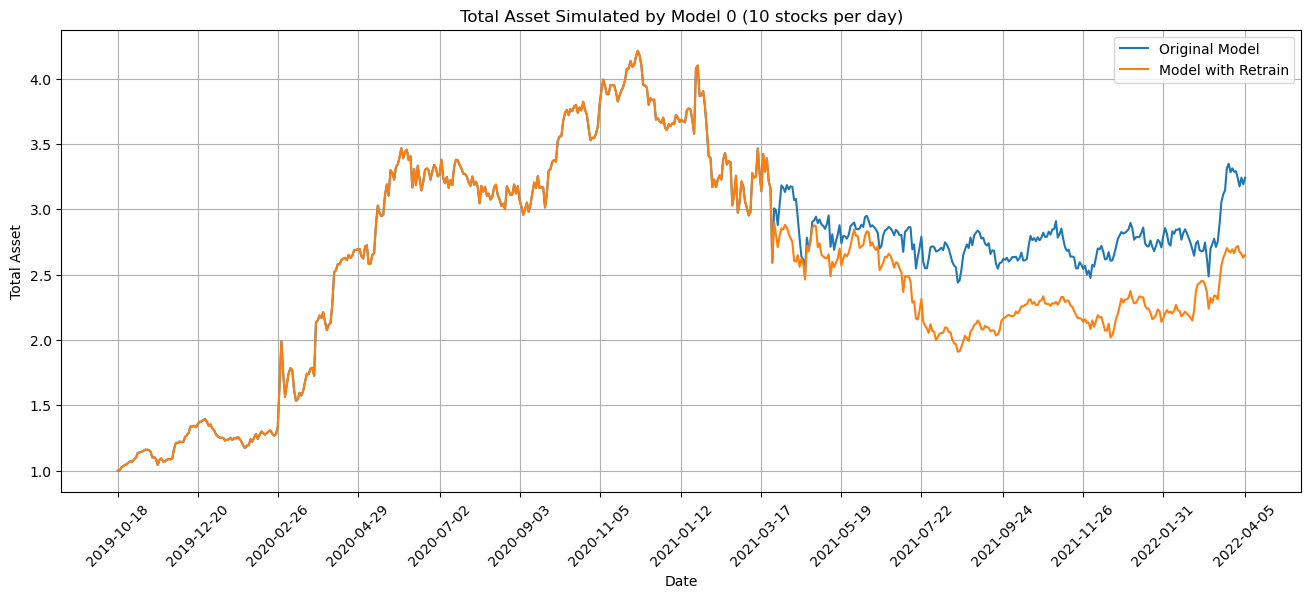

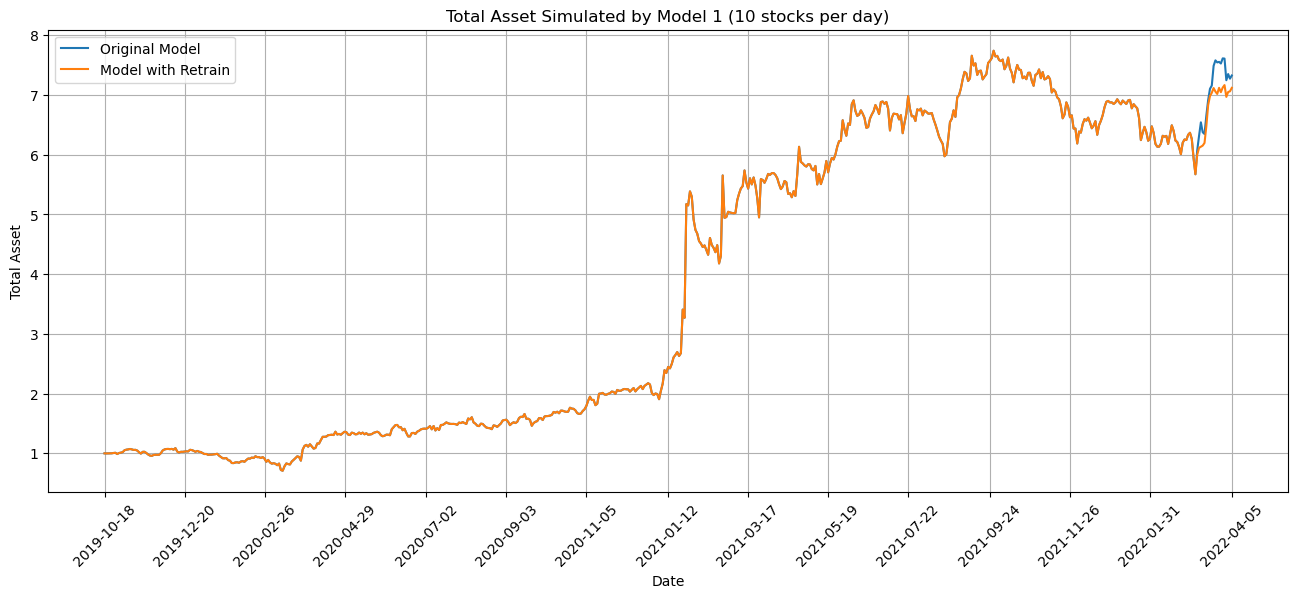

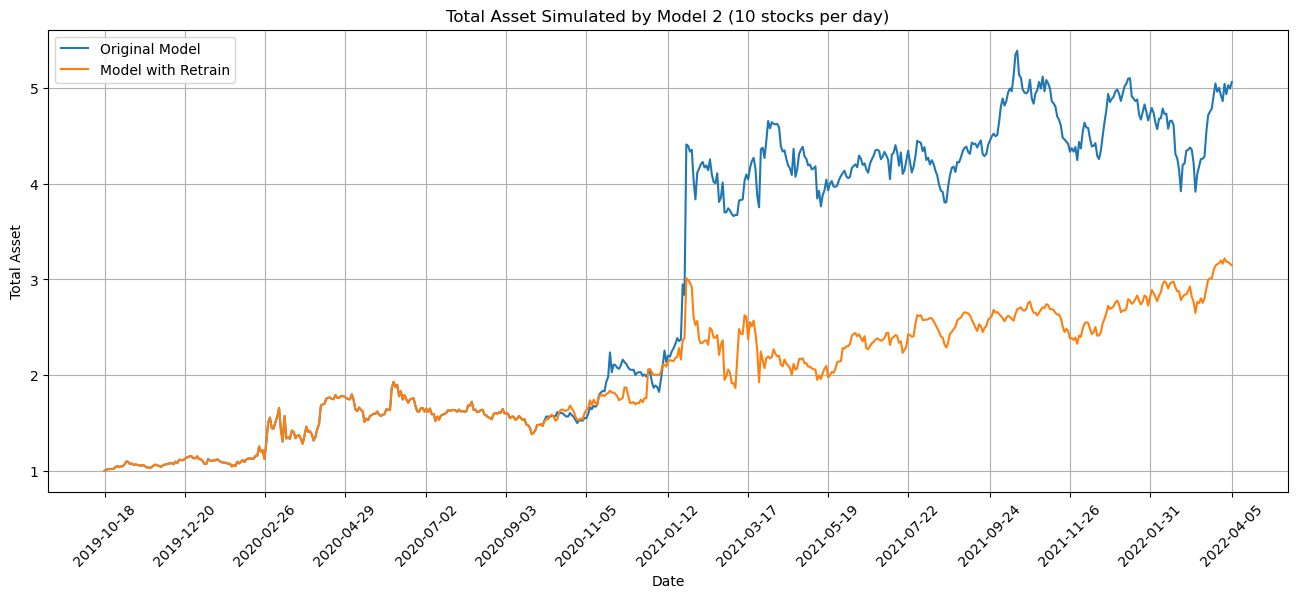

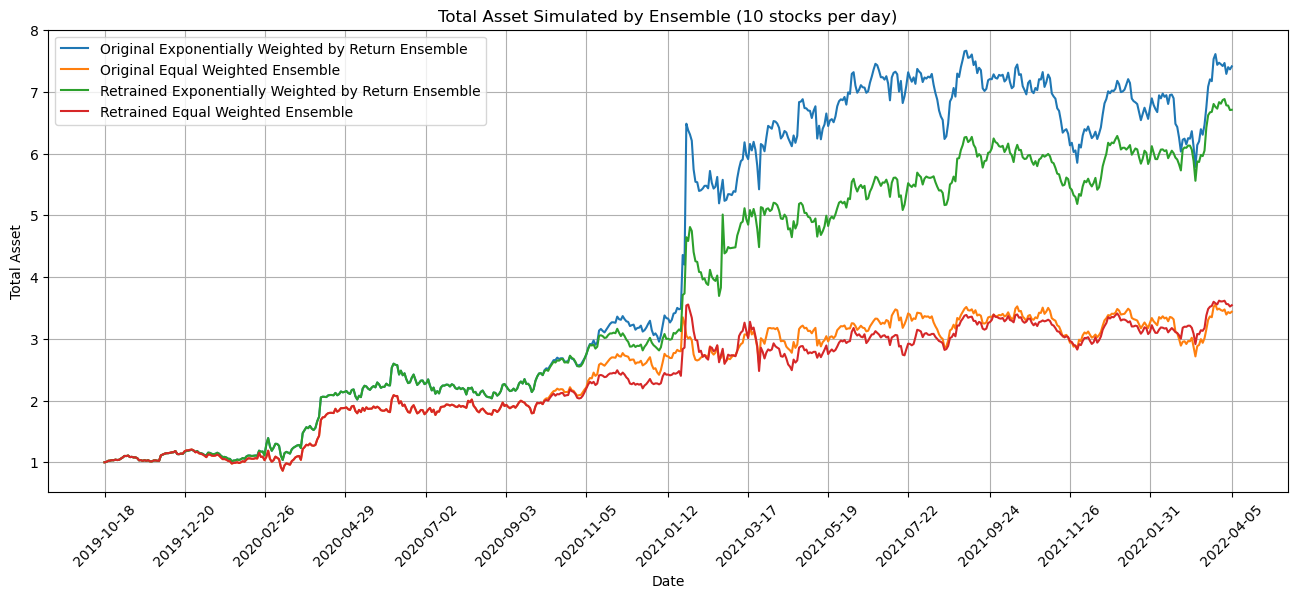

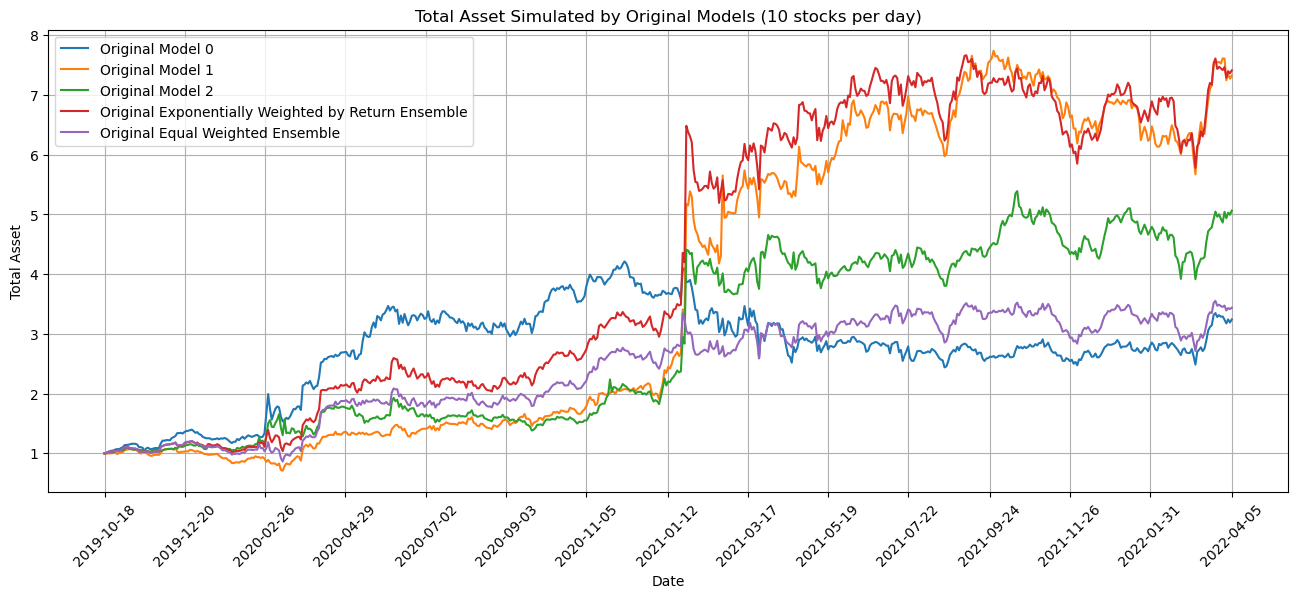

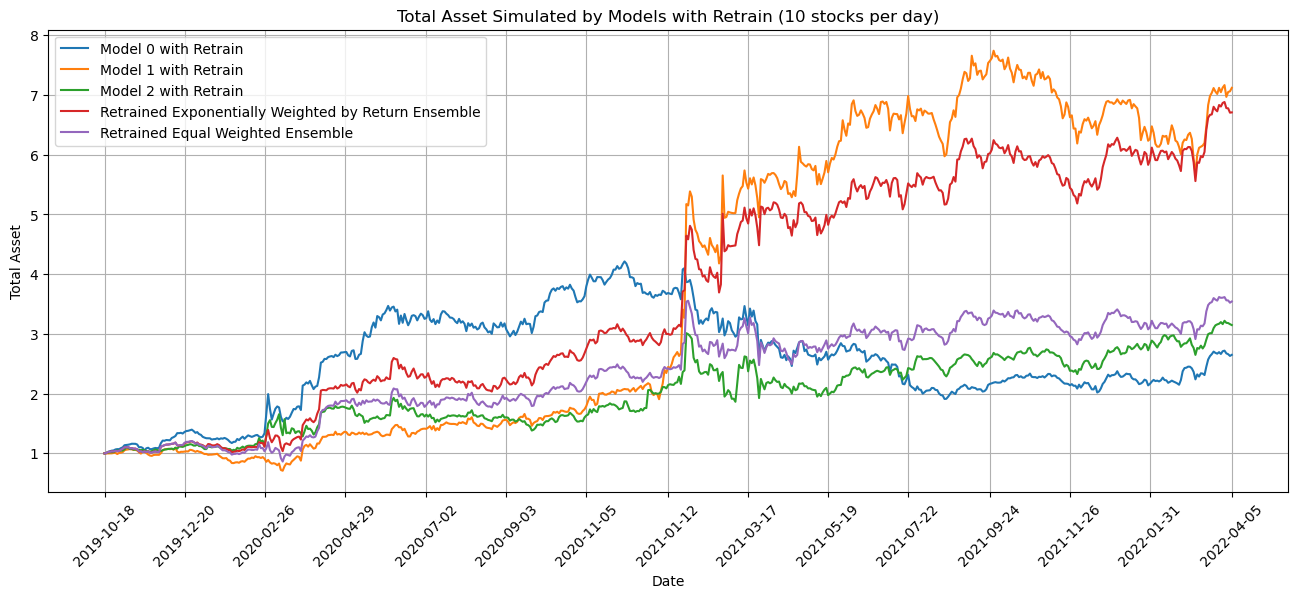

Iteration 32 of 58
Standardization data are from 2021-06-18 to 2021-11-08
Training data are from 2021-11-09 to 2022-04-01
Testing data are from 2022-03-08 to 2022-05-02
Training data have shape (185895, 20, 30), (185895,)
Testing data have shape (45900, 20, 30), (45900,)
Training model 0 using seed 124
Epoch 1/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0261 - val_loss: 0.0262 - lr: 0.0100
Epoch 2/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0254 - val_loss: 0.0257 - lr: 0.0100
Epoch 3/500
146/146 [==============================] - 1s 4ms/step - loss: 0.0251 - val_loss: 0.0264 - lr: 0.0100
Epoch 4/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0249 - val_loss: 0.0261 - lr: 0.0100
Epoch 5/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0248 - val_loss: 0.0268 - lr: 0.0100
Epoch 6/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0247 - val_loss: 0.0267 - lr: 0.0100
Epoch 7/500


146/146 [==============================] - 1s 5ms/step - loss: 0.0238 - val_loss: 0.0258 - lr: 0.0025
Epoch 15/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0238 - val_loss: 0.0263 - lr: 0.0025
Epoch 16/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0237 - val_loss: 0.0265 - lr: 0.0025
Epoch 17/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0237 - val_loss: 0.0264 - lr: 0.0025
Epoch 18/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0235 - val_loss: 0.0258 - lr: 0.0012
Epoch 19/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0235 - val_loss: 0.0257 - lr: 0.0012
Epoch 20/500
146/146 [==============================] - 1s 6ms/step - loss: 0.0235 - val_loss: 0.0260 - lr: 0.0012
Epoch 21/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0235 - val_loss: 0.0260 - lr: 0.0012
Epoch 22/500
146/146 [==============================] - 1s 5ms/step - loss: 0.0235 - val_loss

Total asset on 2022-04-08 will be 6.287148168077233
It should be the same as 6.287148168077302
top_stocks by retrained equal weighted ensemble to buy on 2022-04-07 are ['TECK', 'TIP', 'TMF', 'MXL', 'YANG', 'SPIP', 'TDW', 'STIP', 'VTIP', 'LABD']
Total asset on 2022-04-08 will be 3.32032541865735
It should be the same as 3.3203254186573927
top_stocks by original model 0 to buy on 2022-04-08 are ['MTN', 'SLM', 'CF', 'WLK', 'PRKS', 'CUK', 'EVRI', 'MGM', 'CCL', 'AX']
top_stocks by retrained model 0 to buy on 2022-04-08 are ['JEF', 'FAF', 'SLB', 'WDFC', 'AAL', 'TWO', 'MTN', 'DAY', 'PFSI', 'YEXT']
Total asset on 2022-04-11 will be 3.0715558918661707
It should be the same as 3.071555891866228
Total asset on 2022-04-11 will be 2.406062052359809
It should be the same as 2.406062052359865
Total asset on 2022-04-11 will be 6.35912640069667
It should be the same as 6.359126400696755
top_stocks by original model 1 to buy on 2022-04-08 are ['SMTC', 'SWKS', 'SLM', 'YANG', 'DAY', 'VRTS', 'GFI', 'LSCC',

top_stocks by original model 0 to buy on 2022-04-13 are ['INFY', 'MLKN', 'CTLT', 'A', 'SYNA', 'ZBRA', 'RWT', 'STNE', 'ATKR', 'WIT']
top_stocks by retrained model 0 to buy on 2022-04-13 are ['TCOM', 'AAXJ', 'GXC', 'NIU', 'YUMC', 'CQQQ', 'YINN', 'HTHT', 'MCHI', 'FXI']
Total asset on 2022-04-14 will be 3.08585474676644
It should be the same as 3.085854746766497
Total asset on 2022-04-14 will be 2.4257002416599938
It should be the same as 2.4257002416600493
Total asset on 2022-04-14 will be 6.41102935470328
It should be the same as 6.4110293547033645
top_stocks by original model 1 to buy on 2022-04-13 are ['CWEB', 'KOD', 'IDXX', 'AR', 'WIT', 'YUMC', 'MSFT', 'ZLAB', 'NIU', 'YINN']
top_stocks by retrained model 1 to buy on 2022-04-13 are ['WIT', 'YINN', 'RCUS', 'GDS', 'JD', 'VKTX', 'TOON', 'PDD', 'ZLAB', 'MRVL']
Total asset on 2022-04-14 will be 6.792276157039636
It should be the same as 6.792276157039687
Total asset on 2022-04-14 will be 6.605014384590264
It should be the same as 6.60501438

Total asset on 2022-04-20 will be 6.773971379951764
It should be the same as 6.773971379951816
Total asset on 2022-04-20 will be 6.7208439363317325
It should be the same as 6.720843936331797
Total asset on 2022-04-20 will be 9.21301770944863
It should be the same as 9.213017709448675
top_stocks by original model 2 to buy on 2022-04-19 are ['TMF', 'WB', 'CLM', 'CSCO', 'KOLD', 'BLK', 'KOD', 'AB', 'ACMR', 'MOMO']
top_stocks by retrained model 2 to buy on 2022-04-19 are ['PDD', 'AB', 'SE', 'MOMO', 'OMCL', 'NKTR', 'EPAM', 'TFI', 'SSTK', 'HDB']
Total asset on 2022-04-20 will be 4.531283123974652
It should be the same as 4.531283123974673
Total asset on 2022-04-20 will be 2.940741274156239
It should be the same as 2.9407412741562626
Total asset on 2022-04-20 will be 4.411969675140608
It should be the same as 4.411969675140641
top_stocks by original return weighted ensemble to buy on 2022-04-19 are ['NDAQ', 'SE', 'ING', 'ACMR', 'BLK', 'NOK', 'CWT', 'CSCO', 'AB', 'KOLD']
Total asset on 2022-04-

Total asset on 2022-04-25 will be 2.7999282633989733
It should be the same as 2.7999282633989973
Total asset on 2022-04-25 will be 4.2007090862591365
It should be the same as 4.200709086259167
top_stocks by original return weighted ensemble to buy on 2022-04-22 are ['MCHI', 'ETSY', 'JD', 'AMBA', 'PLUG', 'ARR', 'CQQQ', 'KWEB', 'ENPH', 'SEDG']
Total asset on 2022-04-25 will be 6.3658151925628825
It should be the same as 6.3658151925629385
top_stocks by original equal weighted ensemble to buy on 2022-04-22 are ['MCHI', 'ETSY', 'JD', 'AMBA', 'PLUG', 'CQQQ', 'ARR', 'KWEB', 'ENPH', 'SEDG']
Total asset on 2022-04-25 will be 2.9348554416798907
It should be the same as 2.934855441679915
top_stocks by retrained return weighted ensemble to buy on 2022-04-22 are ['YINN', 'OLED', 'CQQQ', 'KT', 'JD', 'ENPH', 'KWEB', 'NIO', 'PLUG', 'SEDG']
Total asset on 2022-04-25 will be 5.6420841615871185
It should be the same as 5.642084161587187
top_stocks by retrained equal weighted ensemble to buy on 2022-04-2

Total asset on 2022-04-28 will be 5.529057488538255
It should be the same as 5.52905748853832
top_stocks by retrained equal weighted ensemble to buy on 2022-04-27 are ['VLY', 'SDS', 'FELE', 'SSTK', 'UFPI', 'SRTY', 'CADE', 'NVR', 'BOKF', 'FFIN']
Total asset on 2022-04-28 will be 2.924755607474369
It should be the same as 2.9247556074744114
top_stocks by original model 0 to buy on 2022-04-28 are ['MRO', 'KO', 'POR', 'TTE', 'CWT', 'THC', 'ENOV', 'DORM', 'AWR', 'SRTY']
top_stocks by retrained model 0 to buy on 2022-04-28 are ['EME', 'TTE', 'AWR', 'FFIV', 'DOV', 'PBH', 'TMF', 'ARCC', 'HCSG', 'ENOV']
Total asset on 2022-04-29 will be 2.8252532990965737
It should be the same as 2.825253299096631
Total asset on 2022-04-29 will be 2.1899576289255287
It should be the same as 2.189957628925584
Total asset on 2022-04-29 will be 5.7879709963626755
It should be the same as 5.787970996362757
top_stocks by original model 1 to buy on 2022-04-28 are ['UTHR', 'EXTR', 'NVS', 'FCG', 'AMGN', 'CWT', 'TMF', '

top_stocks by original model 0 to buy on 2022-05-03 are ['AMED', 'AXP', 'ON', 'GOOG', 'SCHB', 'GOOGL', 'WING', 'NFLX', 'CVNA', 'TQQQ']
top_stocks by retrained model 0 to buy on 2022-05-03 are ['NVMI', 'MCO', 'GOOGL', 'SKYW', 'GOOG', 'T', 'LEG', 'ARVN', 'TXN', 'RDFN']
Total asset on 2022-05-04 will be 2.6363746419008036
It should be the same as 2.636374641900862
Total asset on 2022-05-04 will be 2.1469199265403245
It should be the same as 2.146919926540379
Total asset on 2022-05-04 will be 5.67422405904048
It should be the same as 5.674224059040564
top_stocks by original model 1 to buy on 2022-05-03 are ['CVE', 'EYE', 'PBF', 'WING', 'ERY', 'ARVN', 'H', 'MAR', 'WH', 'HLT']
top_stocks by retrained model 1 to buy on 2022-05-03 are ['ESS', 'AVB', 'VLO', 'BMI', 'GLNG', 'PLD', 'ON', 'EYE', 'KRYS', 'BTAI']
Total asset on 2022-05-04 will be 5.910313492672435
It should be the same as 5.910313492672482
Total asset on 2022-05-04 will be 6.1224629870314695
It should be the same as 6.122462987031534

In [10]:
# %run C:\Projects\Stock_price_prediction\Experiments\utils_CNN.ipynb
# Data and model parameters
ftd = 100
ltd = 199
seq_length = 20
num_of_models = 3
first_run = True
num_iter = 0

# Retrain parameters
warm_up = 6
num_runs = [0]*num_of_models # Check retrain condition if num_runs is 10 or more
retrain_seed = [122]*num_of_models # starts with last seed 122 and then add one every time a model needs to be retrained

# True: retrain the model if the corresponding retrain entry is true
# False: ignore train + retrain lists and never retrains
implement_retrain = True
# implement_retrain = False
# Whether a model needs to be retrained
retrain = [False]*num_of_models
# Whether a model needs to go through training; always True if their retrain ever becomes True at some point
train = [False]*num_of_models

# Simulation parameters
model_dict = {}
total_dict = {}
total_asset_dict = {}
position_dict_all = {}
return_dict = {}
graph = True
num_stocks = 10

# Model paths
model_folder_path = 'models/'
retrain_folder_path = 'retrain_models/'

# Initialize investment variables
for i in range(num_of_models):
    total_dict[f'orig_{i}'] = 1
    total_asset_dict[f'orig_{i}'] = [1]
    position_dict_all[f'orig_{i}'] = {}
    total_dict[f'retr_{i}'] = 1
    total_asset_dict[f'retr_{i}'] = [1]
    position_dict_all[f'retr_{i}'] = {}
    # Add a retro key for exp weighted ensemble calculation after successful retrain
    # But use no retro when calculating returns, SR etc
    total_dict[f'retr_{i}_retro'] = 1
    total_asset_dict[f'retr_{i}_retro'] = [1]
    position_dict_all[f'retr_{i}_retro'] = {}
total_dict['orig_ensemble'] = 1
total_asset_dict['orig_ensemble'] = [1]
position_dict_all['orig_ensemble'] = {}
total_dict['orig_equal'] = 1
total_asset_dict['orig_equal'] = [1]
position_dict_all['orig_equal'] = {}
total_dict['retr_ensemble'] = 1
total_asset_dict['retr_ensemble'] = [1]
position_dict_all['retr_ensemble'] = {}
total_dict['retr_equal'] = 1
total_asset_dict['retr_equal'] = [1]
position_dict_all['retr_equal'] = {}

# for num_iter in range(num_iters):
for num_iter in range(32):
    
    if num_iter == 0:
        first_run = True
    else:
        first_run = False
    
    # Check retrain condition if num_runs >= 10 
    num_runs = [k+1 for k in num_runs]
    
    print(f'Iteration {num_iter+1} of {num_iters}')
    
    ftd = 100 + num_iter * seq_length
    ltd = 199 + num_iter * seq_length
    
    # Obtain data
    data_train, x_train, y_train, data_test, x_test, y_test, ret_d_train, ret_d_test, sic_train, sic_test = prep_train_test_data(data, seq_length, ftd, ltd, all_days)

    for i in range(num_of_models):
        
        # Always import the same original model
        model_dict[f'orig_{i}'] = keras.models.load_model(f"models/model_{i}_{all_days[ftd]}_{all_days[ltd]}.keras")
        
        # Import/retrain/train potentially retrained model
        retrain_model_path = f"retrain_models/model_{i}_{all_days[ftd]}_{all_days[ltd]}.keras"
        if os.path.exists(retrain_model_path):
            print('Loading retrained model')
            model_dict[f'retr_{i}'] = keras.models.load_model(retrain_model_path)
            # Set train to True because if 1. all models are trained, then retrained models are loaded and training won't happen
            # 2. program was interrupted, then loaded retrained model needs to be trained
            train[i] = True
            
            # If the program was somehow interrupted, retrain may be True, but the model does not need to be retrained from scratch
            if retrain[i]:
                retrain_seed[i] = max(retrain_seed) + 1
                retrain[i] = False
        elif retrain[i]:
            retrain_seed[i] = max(retrain_seed) + 1
            print(f'Retraining model {i} using seed {retrain_seed[i]}')
            model, replace = retrain_model(data, seq_length, ftd, ltd, retrain_seed[i], warm_up, num_stocks, model_params,
                                                             portfolio_dict, tickers, i, SR_dict, 
                                                             pred_score_avg_dict, excess_return_dict)
            # Set retrain and train
            retrain[i] = False
            if replace:
                model_dict[f'retr_{i}'] = model
                model_dict[f'retr_{i}'].model.save(f"retrain_models/model_{i}_{all_days[ftd]}_{all_days[ltd]}.keras")
                train[i] = True
                num_runs[i] = 1
            elif not train[i]:
                model_dict[f'retr_{i}'] = keras.models.load_model(f"models/model_{i}_{all_days[ftd]}_{all_days[ltd]}.keras")
            # else: do nothing and keep the same model
        elif train[i]:
            print(f'Training model {i} using seed {retrain_seed[i]}')
            try:
                model_dict[f'retr_{i}'].retrain_model(x_train, y_train, ret_d_train, sic_train)
                model_dict[f'retr_{i}'].model.save(f"retrain_models/model_{i}_{all_days[ftd]}_{all_days[ltd]}.keras")
            except:
                tf.random.set_seed(retrain_seed[i])
                random.seed(retrain_seed[i])
                np.random.seed(retrain_seed[i])
                K.set_value(model_dict[f'retr_{i}'].optimizer.learning_rate, 1e-2)
                history = model_dict[f'retr_{i}'].fit(
                    x=[y_train, x_train, ret_d_train, sic_train],
                    y=None,
                    batch_size=model_params['batch_size'],
                    epochs=model_params['epochs'],
                    callbacks=[keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=model_params['plateau_patience'], min_lr=1e-3),
                               keras.callbacks.EarlyStopping(monitor="val_loss", patience=model_params['retrain_patience'], 
                               restore_best_weights=True, verbose=model_params['verbose'])],
                    validation_split=model_params['validation_split'],
                    verbose=model_params['verbose']
                    )
                model_dict[f'retr_{i}'].save(f"retrain_models/model_{i}_{all_days[ftd]}_{all_days[ltd]}.keras")
            
        else:
            model_path = f"models/model_{i}_{all_days[ftd]}_{all_days[ltd]}.keras"
            model_dict[f'retr_{i}'] = keras.models.load_model(model_path)

    # Simulate investment (include SR calculation)
    if num_iter % 10 == 0 or num_iter == num_iters-1:
        graph = True
    else:
        graph = False
    total_asset_dict, total_dict, position_dict_all, portfolio_dict, pred_score_avg_dict, excess_return_dict, SR_dict, retrain, return_dict = simulate_comparison(model_dict, ftd, ltd, num_stocks, total_dict, first_run, total_asset_dict, position_dict_all, graph,
                                                                                data_test, seq_length, nt, num_runs, retrain, return_dict,
                                                                                # SR arguments
                                                                                num_iter, portfolio_dict, pred_score_avg_dict, excess_return_dict, SR_dict)

    gc.collect()


In [11]:
# Calculate the overall SR
SR_whole_period = pd.DataFrame(columns=['pred_score', 'avg_excess_ret', 'std_excess_ret', 'SR'])

for i in range(num_of_models):
    pred_score_avg_dict[f'orig_{i}'] /= num_iters * seq_length
    pred_score_avg_dict[f'retr_{i}'] /= num_iters * seq_length
    excess_return_avg_orig = np.mean(excess_return_dict[f'orig_{i}'][0])
    excess_return_std_orig = np.std(excess_return_dict[f'orig_{i}'][0])
    excess_return_avg_retr = np.mean(excess_return_dict[f'retr_{i}'][0])
    excess_return_std_retr = np.std(excess_return_dict[f'retr_{i}'][0])
    
    # Calculate the SR table for original models
    SR_whole_period.loc[f'orig_{i}', 'pred_score'] = pred_score_avg_dict[f'orig_{i}']
    SR_whole_period.loc[f'orig_{i}', 'avg_excess_ret'] = excess_return_avg_orig
    SR_whole_period.loc[f'orig_{i}', 'std_excess_ret'] = excess_return_std_orig
    SR_whole_period.loc[f'orig_{i}', 'SR'] = excess_return_avg_orig / excess_return_std_orig * np.sqrt(252)
    
    # Calculate the SR table for retrained models
    SR_whole_period.loc[f'retr_{i}', 'pred_score'] = pred_score_avg_dict[f'retr_{i}']
    SR_whole_period.loc[f'retr_{i}', 'avg_excess_ret'] = excess_return_avg_retr
    SR_whole_period.loc[f'retr_{i}', 'std_excess_ret'] = excess_return_std_retr
    SR_whole_period.loc[f'retr_{i}', 'SR'] = excess_return_avg_retr / excess_return_std_retr * np.sqrt(252)     

# Ensemble
pred_score_avg_dict['orig_ensemble'] /= num_iters * seq_length
excess_return_avg_orig = np.mean(excess_return_dict['orig_ensemble'][0])
excess_return_std_orig = np.std(excess_return_dict['orig_ensemble'][0])
SR_whole_period.loc['orig_ensemble', 'pred_score'] = pred_score_avg_dict[f'orig_ensemble']
SR_whole_period.loc['orig_ensemble', 'avg_excess_ret'] = excess_return_avg_orig
SR_whole_period.loc['orig_ensemble', 'std_excess_ret'] = excess_return_std_orig
SR_whole_period.loc['orig_ensemble', 'SR'] = excess_return_avg_orig / excess_return_std_orig * np.sqrt(252)

pred_score_avg_dict['orig_equal'] /= num_iters * seq_length
excess_return_avg_orig = np.mean(excess_return_dict['orig_equal'][0])
excess_return_std_orig = np.std(excess_return_dict['orig_equal'][0])
SR_whole_period.loc['orig_equal', 'pred_score'] = pred_score_avg_dict[f'orig_equal']
SR_whole_period.loc['orig_equal', 'avg_excess_ret'] = excess_return_avg_orig
SR_whole_period.loc['orig_equal', 'std_excess_ret'] = excess_return_std_orig
SR_whole_period.loc['orig_equal', 'SR'] = excess_return_avg_orig / excess_return_std_orig * np.sqrt(252)

pred_score_avg_dict[f'retr_ensemble'] /= num_iters * seq_length
excess_return_avg_retr = np.mean(excess_return_dict['retr_ensemble'][0])
excess_return_std_retr = np.std(excess_return_dict['retr_ensemble'][0])
SR_whole_period.loc['retr_ensemble', 'pred_score'] = pred_score_avg_dict[f'retr_ensemble']
SR_whole_period.loc['retr_ensemble', 'avg_excess_ret'] = excess_return_avg_retr
SR_whole_period.loc['retr_ensemble', 'std_excess_ret'] = excess_return_std_retr
SR_whole_period.loc['retr_ensemble', 'SR'] = excess_return_avg_retr / excess_return_std_retr * np.sqrt(252)

pred_score_avg_dict['retr_equal'] /= num_iters * seq_length
excess_return_avg_orig = np.mean(excess_return_dict['retr_equal'][0])
excess_return_std_orig = np.std(excess_return_dict['retr_equal'][0])
SR_whole_period.loc['retr_equal', 'pred_score'] = pred_score_avg_dict[f'retr_equal']
SR_whole_period.loc['retr_equal', 'avg_excess_ret'] = excess_return_avg_orig
SR_whole_period.loc['retr_equal', 'std_excess_ret'] = excess_return_std_orig
SR_whole_period.loc['retr_equal', 'SR'] = excess_return_avg_orig / excess_return_std_orig * np.sqrt(252)
print(SR_whole_period)

                        pred_score avg_excess_ret std_excess_ret        SR
orig_0                    0.512273       0.001109       0.024013  0.733231
retr_0                    0.508254       0.000919       0.023425  0.622636
orig_1                    0.479364       0.001898        0.02921   1.03145
retr_1                     0.48411       0.001924       0.029068  1.050877
orig_2                    0.509932       0.001572       0.028953  0.861698
retr_2                    0.492683       0.001208       0.025746   0.74476
orig_ensemble    0.421882202580365       0.001878       0.027376  1.089029
orig_equal     0.41527854250064694       0.001107       0.021737  0.808441
retr_ensemble   0.4125397570008304        0.00175       0.024434  1.136955
retr_equal      0.4038974538117796       0.001171        0.02279  0.815574


In [ ]:
# Save everything
for key, value in SR_dict.items():
    value.to_csv(f'SR_{key}.csv')
SR_whole_period.to_csv(f'All_SRs.csv')

In [ ]:
import json

with open('total_asset_dict.json', 'w') as f:
    json.dump(total_asset_dict, f)
    
# with open('total_asset_dict.json', 'r') as fr:
#     test = json.load(fr)

In [ ]:
# excess_ret_save = {}
# for key, value in excess_return_dict.items():
#     excess_ret_save[key] = list(value[0])
# with open('excess_return_dict.json', 'w') as f:
#     json.dump(excess_ret_save, f)